# CamVid

* UNet with MobileNetV2 & EfficientNet as encoder, with symmetrical decoder.
* Effect of bayesian inference

# Install & Import

In [ ]:
!pip install torchmetrics -q
!pip install fvcore -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 594.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import sys
import os
import copy
import random
import json
import math
from collections import OrderedDict
from dataclasses import dataclass
from functools import partial
from datetime import date
from prettytable import PrettyTable
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim, Tensor, ones_like, zeros_like
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from fvcore.nn import FlopCountAnalysis

import torchvision
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from torchvision.datasets import VOCSegmentation
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torchsummary import summary

from fvcore.nn import FlopCountAnalysis
from torch.profiler import profile, record_function, ProfilerActivity

from typing import Any, Callable, List, Optional, Sequence, Tuple, Union, Dict
# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cuda:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

module_dir = "/content/drive/My Drive/ShorelineNet_pytorch/"

# append local module to path
module_path = os.path.abspath(os.path.join(module_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

Mounted at /content/drive/


In [ ]:
from model.Bayesian_net import Bayesian_net
from model._Unet import _Unet
from model.MBConfig import MBConvConfig

from utils.bayes_func import bayes_eval, bayes_forward
from utils.train_transforms import HFlip, HueSatCon, Rotation, Crop, Affine, Resize, ToTensor, Normalize

# Archived

### Pascal VOC 2012

Training set: 1464

Validation set: 1449

Testing set is not available and only evaluated through submission

In [ ]:
# if 'data' not in os.listdir('/content/'):
#   !mkdir '/content/data/'
#   !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/VOCtrainval_11-May-2012.tar' '/content/data/'

# download_dataset = 'VOCdevkit' not in os.listdir('/content/data/')

# train_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
#                                                      year="2012",
#                                                      image_set="train",
#                                                      download=download_dataset)

# val_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
#                                                      year="2012",
#                                                      image_set="val",
#                                                      download=download_dataset)

# # test_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
# #                                                      year="2007",
# #                                                      image_set="test",
# #                                                      download=download_dataset)

# print(f'Training set length: {train_dataset}')
# print(f'Validation set length: {val_dataset}')
# # print(f'Test set length: {test_dataset}')

In [ ]:
# Global variables (PASCAL VOC 2012)
# CLASSES = [
#   "background",
#   "aeroplane",
#   "bicycle",
#   "bird",
#   "boat",
#   "bottle",
#   "bus",
#   "car",
#   "cat",
#   "chair",
#   "cow",
#   "diningtable",
#   "dog",
#   "horse",
#   "motorbike",
#   "person",
#   "pottedplant",
#   "sheep",
#   "sofa",
#   "train",
#   "tvmonitor",
# ]

# # dummy pixel (placed at boundaries)
# DROP_PIX = 255
# FILL_PIX = 21

# CLASS_MAP_ALL = {i: v for (i, v) in enumerate(CLASSES)}
# CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
# CLASS_MAP_ALL[FILL_PIX] = 'ambiguous'

# NUM_CLASSES = len(CLASS_MAP.keys())
# SEED = 0


In [ ]:
# METHODS FOR PASCAL
# def load_pascal_into_memory(dataset:Dataset, t)->MemoryDataset:
#     n = len(dataset)
#     # preallocate tensor memory
#     X = torch.zeros((n, 3, 256, 256), dtype=torch.float32, device=DEVICE, requires_grad=False)
#     Y = torch.zeros((n, 1, 256, 256), dtype=torch.float32, device=DEVICE, requires_grad=False)

#     to_tensor = transforms.PILToTensor()
#     resize_x = transforms.Resize((256, 256), transforms.InterpolationMode.BILINEAR, antialias=True)
#     resize_y = transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST, antialias=False)

#     for i in tqdm(range(n)):
#       x, y = dataset[i]

#       x = to_tensor(x).to(torch.float).to(DEVICE)
#       y = to_tensor(y).to(torch.float).to(DEVICE)

#       x = resize_x(x)
#       y = resize_y(y)

#       x = x / 255.0
#       y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

#       X[i] = x
#       Y[i] = y

#     return MemoryDataset(X, Y, t)


# def get_pascal_train_dataset(transforms) -> Dataset:
#     download_dataset = 'data' not in os.listdir('/content/')

#     train_dataset = VOCSegmentation(root="/content/data",
#                                     year="2012",
#                                     image_set="train",
#                                     download=download_dataset)
#     return load_pascal_into_memory(train_dataset, transforms)

# def get_pascal_val_dataset(transforms) -> Dataset:
#     download_dataset = 'data' not in os.listdir('/content/')

#     val_dataset = VOCSegmentation(root="/content/data",
#                                   year="2012",
#                                   image_set="val",
#                                   download=download_dataset)
#     return load_pascal_into_memory(val_dataset, transforms)

# def color_map(N=256, normalized=False):
#     def bitget(byteval, idx):
#         return ((byteval & (1 << idx)) != 0)

#     dtype = 'float32' if normalized else 'uint8'
#     cmap = np.zeros((N, 3), dtype=dtype)
#     for i in range(N):
#         r = g = b = 0
#         c = i
#         for j in range(8):
#             r = r | (bitget(c, 0) << 7-j)
#             g = g | (bitget(c, 1) << 7-j)
#             b = b | (bitget(c, 2) << 7-j)
#             c = c >> 3

#         cmap[i] = np.array([r, g, b])

#     cmap = cmap/255 if normalized else cmap
#     cmap = cmap/255
#     return cmap

# voc_cmap = ListedColormap(color_map())

### Cityscapes

Has to be loaded from google drive - dataset is 11GB

Abandoned because image resolution is too high & not a practical scope

In [ ]:
# !mkdir '/content/data'
# !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/leftImg8bit_trainvaltest.zip' '/content/data/'
# !unzip '/content/data/leftImg8bit_trainvaltest.zip'

# !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/gtFine_trainvaltest.zip' '/content/data/'
# !unzip '/content/data/gtFine_trainvaltest.zip'

# train_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                                 split='train',
#                                                 mode='fine',
#                                                 target_type='semantic')


# val_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                               split='val',
#                                               mode='fine',
#                                               target_type='semantic')

# test_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                               split='test',
#                                               mode='fine',
#                                               target_type='semantic')


# print(f'Train dataset: {len(train_dataset)}')
# print(f'Val dataset: {len(val_dataset)}')
# print(f'Test dataset: {len(test_dataset)}')

# split = val_dataset

# id = np.random.randint(1, len(split))

# plt.figure(figsize=(8, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(split[id][0])
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(split[id][1])
# plt.axis('off')

# Datasets



## CamVid

In [ ]:
if 'CamVid' not in os.listdir('/content'):
  !mkdir '/content/data'
  !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/camvid.zip' '/content/data/'
  !unzip -q '/content/data/camvid.zip'

## Define some Global Variables

In [ ]:
# get classes for CamVid
# class_dict = pd.read_csv('/content/CamVid/class_dict.csv')

RGB2CLSNAME = {
    (128, 128, 128): "Sky",

    (0, 128, 64): "Building",
    (128, 0, 0): "Building",
    (64, 192, 0): "Building",
    (64, 0, 64): "Building",
    (192, 0, 128): "Building",

    (192, 192, 128): "Pole",
    (0, 0, 64): "Pole",

    (128, 64, 128): "Road",
    (128, 0, 192): "Road",
    (192, 0, 64): "Road",

    (0, 0, 192): "Sidewalk",
    (64, 192, 128): "Sidewalk",
    (128, 128, 192): "Sidewalk",

    (128, 128, 0): "Tree",
    (192, 192, 0): "Tree",

    (192, 128, 128): "SignSymbol",
    (128, 128, 64): "SignSymbol",
    (0, 64, 64): "SignSymbol",

    (64, 64, 128): "Fence",

    (64, 0, 128): "Car",
    (64, 128, 192): "Car",
    (192, 128, 192): "Car",
    (192, 64, 128): "Car",
    (128, 64, 64): "Car",

    (64, 64, 0): "Pedestrian",
    (192, 128, 64): "Pedestrian",
    (64, 0, 192): "Pedestrian",
    (64, 128, 64): "Pedestrian",

    (0, 128, 192): "Bicyclist",
    (192, 0, 192): "Bicyclist",

    (0, 0, 0): "Void"
}


DROP_PIX: Optional[int] = None
FILL_PIX = 11

WIDTH = 480
HEIGHT = 360

CLASSES = sorted(list(set(RGB2CLSNAME.values())))
RGB2CLASS = {rgb:{c:i for i,c in enumerate(CLASSES)}[name] for (rgb, name) in RGB2CLSNAME.items()}
CLASS2RGB = {c:rgb for (rgb, c) in RGB2CLASS.items()}

CLASS_MAP_ALL={i:c for i,c in enumerate(CLASSES)}
CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
CLASS_MAP.pop(FILL_PIX)
NUM_CLASSES = len(CLASS_MAP.items())


## Transformations

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t((image, target))
        return image, target

### Training Transforms

Imported from local modules: `Flip`, `HueSatCon`, `Rotation`, `Crop`, `Affine`, `Resize`, `ToTensor`, `Normalize`

In [ ]:
from torch import is_tensor

class Crop(object):
    def __init__(
        self,
        scale:Optional[Tuple[float, float]]=[1.0, 1.0],
        fill_pix: Optional[int]=FILL_PIX,
    ) -> None:
        assert(scale[1] > scale[0])
        self.fill_pix = fill_pix
        self.scale = scale

    def __call__(
        self, data: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        (x, y) = data

        h, w = y.shape[1:]
        s_min, s_max = self.scale[0], self.scale[1]

        s = random.random() * (s_max - s_min) + s_min
        h_rand = random.random()
        w_rand = random.random()

        padding = (int(w_rand*(1-s)*w),
                  int(h_rand*(1-s)*h),
                  int((1-w_rand)*(1-s)*w),
                  int((1-h_rand)*(1-s)*h))

        # if s >= 1:
        #   t = 1/2
        #   k = 2-s
        #   w_pad, h_pad = int(w * k * t), int(h * k * t)
        #   even_padding = (w_pad, h_pad, w_pad, h_pad)

        #   pad_x = transforms.Pad(even_padding, fill=0, padding_mode='constant')
        #   pad_y = transforms.Pad(even_padding, fill=FILL_PIX, padding_mode='constant')

        #   x = pad_x(x)
        #   y = pad_y(y)

        #   crop_amount_w = w * (1+ 2 * k * t - k)
        #   crop_amount_h = h * (1+ 2 * k * t - k)
        #   # Crop
        #   padding = (int(-w_rand*crop_amount_w),
        #             int(-h_rand*crop_amount_h),
        #             int(-(1-w_rand)*crop_amount_w),
        #             int(-(1-h_rand)*crop_amount_h))

        crop_x = transforms.Pad(padding, fill=0, padding_mode='constant')
        crop_y = transforms.Pad(padding, fill=FILL_PIX, padding_mode='constant')

        x = crop_x(x)
        y = crop_y(y)

        return (x, y)

### Test set Transforms

`Normalize_test`, `Resize_test`, all would be imported if needed

These functions only operate on images, these set of augmentations are for test images with no ground truth labels

## Dataset & Dataloader

In [ ]:
class MemoryDataset(Dataset):
    def __init__(self,
                 X:Tensor,
                 y:Tensor,
                 transform:Optional[transforms.Compose]=None,
    ) -> None:
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, H, W)
        y : Tensor with shape (n, 1, H, W)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            # x, y = self.transform((x, y))
            x, y = self.transform(x, y) # to be consistent with torch
        return x, y

def get_train_transforms(intensity:float=1) -> transforms.Compose:
    '''
    Returns the transformations for the training set for given intensity
    '''
    z = intensity
    train_transforms = Compose([
      HFlip(prob=0.5),
      HueSatCon(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, prob=1),
      Crop((0.7, 1.3), fill_pix=FILL_PIX),
      # Affine(affine_percentage=0.2*z, shear_deg=0, fill_pix=FILL_PIX, prob=1),
      # Rotation(10*z, fill_pix=FILL_PIX, prob=1),
      # Crop(crop_percentage=1-z*0.2, prob=1),
      Resize((HEIGHT, WIDTH)),
      # ToTensor(),
      # RandomResizedCrop((HEIGHT, WIDTH), (0.5, 2), (1, 1)),
      Normalize(),
    ])
    return train_transforms


class DatasetManager():
  '''
  Holds dataset objects in a dict and manages augmentation properties for training set
  '''
  def __init__(self, intensity: Optional[float]=1) -> None:
    train_transforms = get_train_transforms(intensity=intensity)

    val_transforms = Compose([
        # Resize((HEIGHT, WIDTH)),
        # ToTensor(),
        Normalize(),
    ])

    test_transforms = Compose([
        # Resize_test((HEIGHT, WIDTH)),
        # ToTensor(),
        # Normalize_test()
    ])

    # train_dataset = get_train_dataset(train_transforms)
    # val_dataset = get_val_dataset(val_transforms)

    train_dataset = load_camvid_into_memory('train', train_transforms)
    val_dataset = load_camvid_into_memory('val', None)
    test_dataset = load_camvid_into_memory('test', None)

    self.datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

  def update_train_transforms(self, intensity:float=1) -> None:
    train_transforms = get_train_transforms(intensity)
    self.datasets['train'].transforms = train_transforms
    print(f'Updated training dataset augmentation intensity to {intensity}')
    return


In [ ]:
# METHODS FOR CAMVID

def load_camvid_into_memory(split:str, t:transforms.Compose)->MemoryDataset:
    root_dir = '/content/CamVid'

    H, W = (480, 640) if split == 'train' else (360, 480)
    n = len(os.listdir(f'{root_dir}/{split}'))
    # preallocate tensor memory
    X = torch.zeros((n, 3, H, W), dtype=torch.float, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, H, W), dtype=torch.float, device=DEVICE, requires_grad=False)

    to_tensor = transforms.PILToTensor()
    resize_x = transforms.Resize((H, W), transforms.InterpolationMode.BILINEAR, antialias=True)
    resize_y = transforms.Resize((H, W), transforms.InterpolationMode.NEAREST, antialias=False)

    normalize = Normalize()

    for i in tqdm(range(n)):
      filename = os.listdir(f'{root_dir}/{split}')[i]
      x_path = os.path.join(root_dir, split, filename)
      y_path = os.path.join(root_dir, f'{split}_labels', filename.split('.')[0]+'_L.png')

      x = read_image(x_path).to(DEVICE)
      y = read_image(y_path).to(DEVICE)

      # x = to_tensor(x).to(torch.int8).to(DEVICE)
      y = map_rgbLabel_to_grayscale(y)

      x = resize_x(x)
      y = resize_y(y)

      x = x / 255.0
      if DROP_PIX is not None:
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      if split != 'train':
        x, y = normalize((x, y))

      X[i] = x
      Y[i] = y

    return MemoryDataset(X, Y, t)

def map_rgbLabel_to_grayscale(image: np.array) -> torch.Tensor:
    '''
    Takes a (3 x w x h) int8 rgb label and returns a (1 x w x h) label
    '''
    height, width = image.shape[1], image.shape[2]
    out = torch.zeros((1, height, width), dtype=torch.int, device=image.device)

    for (rgb, cls) in RGB2CLASS.items():
      boolean_array = (image[0] == rgb[0])
      boolean_array = boolean_array * (image[1] == rgb[1])
      boolean_array = boolean_array * (image[2] == rgb[2])
      out[0, boolean_array] = cls

    return out


In [ ]:
# create dataset manager
dataset_manager = DatasetManager()

# create dataloaders
train_dataloader = DataLoader(dataset_manager.datasets['train'], batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_manager.datasets['val'], batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset_manager.datasets['test'], batch_size=1, shuffle=True)

# # note that new instances of dataloaders are generated for every training
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

### Visualization helpers

* `imshow_image`
* `imshow_label`
* `imshow_uncertainty`

In [ ]:
# helper functions
from matplotlib.colors import ListedColormap
colors = [CLASS2RGB[i] for i in range(NUM_CLASSES+1)]
camvid_cmap = ListedColormap([list([c/255 for c in rgb]) for rgb in colors])

def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

def imshow_image(image):
  plt.imshow(unnormalize(image).permute(1, 2, 0).cpu())
  plt.axis('off')

def imshow_label(label, cmap=camvid_cmap):
  if len(label.shape) == 3:
    label = label.permute(1, 2, 0)
  elif len(label.shape) == 2:
    pass
  plt.imshow(label.cpu(), cmap=cmap, interpolation='none', vmin=0, vmax=NUM_CLASSES)
  plt.axis('off')

def imshow_uncertainty(uncertainty: Tensor, normalize=True):
  if normalize:
    u_max, u_min = uncertainty.max(), uncertainty.min()
    uncertainty = (uncertainty - u_min) / (u_max - u_min)
  if len(uncertainty.shape) == 3:
    uncertainty = uncertainty.permute(1, 2, 0)
  # TODO: normalize to 0 - 1?
  plt.imshow(uncertainty.cpu())
  plt.axis('off')

### Preview images

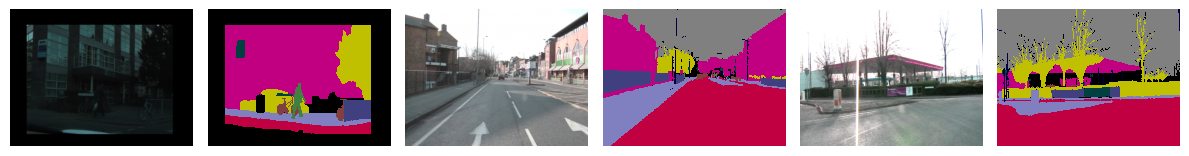

In [ ]:
split = 'train'

plt.figure(figsize=(12, 6))
for i in range(3):
  x_batch_sample, y_batch_sample = next(iter(dataloaders[split]))
  plt.subplot(1, 6, i*2+1)
  imshow_image(x_batch_sample[0])
  plt.subplot(1, 6, i*2+2)
  imshow_label(y_batch_sample[0].to(int))

# note: clipping error message can be ignored
plt.tight_layout()

In [ ]:
# xs, ys = next(iter(dataloaders['val']))
# x, y = xs[0], ys[0]

# aug = Crop((0.5, 2.0))

# plt.figure(figsize=(10, 8))
# plt.subplot(1, 3, 1)
# imshow_image(x)

# plt.subplot(1, 3, 2)
# x, y = aug((x, y))

# imshow_image(x)

# plt.tight_layout()

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

## Network Properties

Define some helper functions to calculate:
* parameter count
* storage
* FLOPS
* CPU/GPU run time

In [ ]:
def _format_memory(nbytes):
    """Returns a formatted memory size string"""
    KB = 1024
    MB = 1024 * KB
    GB = 1024 * MB
    if abs(nbytes) >= GB:
        return f"{nbytes * 1.0 / GB:.2f} Gb"
    elif abs(nbytes) >= MB:
        return f"{nbytes * 1.0 / MB:.2f} Mb"
    elif abs(nbytes) >= KB:
        return f"{nbytes * 1.0 / KB:.2f} Kb"
    else:
        return str(nbytes) + " b"

def _format_time(time_us):
    """Defines how to format time in FunctionEvent"""
    US_IN_SECOND = 1000.0 * 1000.0
    US_IN_MS = 1000.0
    if time_us >= US_IN_SECOND:
        return f"{time_us / US_IN_SECOND:.3f}s"
    if time_us >= US_IN_MS:
        return f"{time_us / US_IN_MS:.3f}ms"
    return f"{time_us:.3f}us"

In [ ]:
# helper functions for counting parameters and storage
def count_parameters(model, print_table=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if print_table:
        print(table)
    return total_params


def calculate_storage(model, print_buffer=True):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    if print_buffer:
        print(f"Buffer size: {buffer_size/1024**2:.3f} MB")

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb


In [ ]:
def count_FLOPS(net: nn.Module) -> float:
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, 'all')
    flops = FlopCountAnalysis(net, x_batch).total()

  # print(f'Flops: {flops.total()/1e9:.3f} G')
  return flops

In [ ]:
def compute_cpu_runtime_memory(net: nn.Module, n:Optional[int]=5) -> Tuple[float, float]:
  '''
  Computes the cpu and gpu run time in ms
  Returns
  -----------
  runtimes: Array[float], cpu runtime in ms
  memories: Array[float], cpu memory in mb
  '''
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to('cpu')
  # MEMORY & INFERENCE TIME
  net.to('cpu')
  x_batch = x_batch.to('cpu')

  runtimes, memories = [], []

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(False, 'all')
    for _ in tqdm(range(n)):
      with profile(activities=[ProfilerActivity.CPU],
                  profile_memory=True,
                  record_shapes=False) as prof:
        with record_function("model_inference"):
          net(x_batch)
          # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')
      for event in prof.key_averages():
        if event.key == 'model_inference':
          runtimes.append(event.cpu_time/1000)
        if event.key == 'aten::empty':
          memories.append(event.cpu_memory_usage/1024/1024)

  runtimes, memories = np.array(runtimes), np.array(memories)

  return runtimes, memories



In [ ]:
def compute_gpu_runtime_memory(net: nn.Module, n:Optional[int]=5, debug=False) -> Tuple[float, float]:
  '''
  Computes the gpu run time in ms
  Returns
  -----------
  runtimes: Array[float], cpu runtime in ms
  memories: Array[float], cpu memory in mb
  '''
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
  # MEMORY & INFERENCE TIME
  net.to(DEVICE)
  x_batch = x_batch.to(DEVICE)

  runtimes, memories = [], []

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(False, 'all')
    for _ in tqdm(range(n)):
      with profile(activities=[ProfilerActivity.CPU,ProfilerActivity.CUDA],
                  profile_memory=True,
                  record_shapes=False) as prof:
        with record_function("model_inference"):
          net(x_batch)
          # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')
      for event in prof.key_averages():
        if event.key == 'model_inference':
          runtimes.append(event.cuda_time/1000)
        if event.key == 'aten::empty':
          memories.append(event.cuda_memory_usage/1024/1024)

  runtimes, memories = np.array(runtimes), np.array(memories)

  if debug:
    return prof

  return runtimes, memories


In [ ]:
# # MEMORY & INFERENCE TIME
# net.to('cpu')
# x_batch = x_batch.to('cpu')
# with profile(activities=[
#         ProfilerActivity.CPU], profile_memory=True, record_shapes=False) as prof:
#     net.eval()
#     net.set_bayes_mode(False, 'all')
#     with record_function("model_inference"):
#         net(x_batch)
#         # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')


In [ ]:
# for event in prof.key_averages():
#   if event.key == 'model_inference':
#     print(event)
#     print(f'CPU time: {event.cpu_time/1000}ms')
#   if event.key == 'aten::empty':
#     print(event)
#     print(f'cpu memory: {event.cpu_memory_usage/1024/1024}Mb')

## UNet

### Deconv Variations

In [ ]:
class Deconv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        use_res_connect: Optional[bool] = None,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        layers: List[nn.Module] = []

        # depthwise (can be a deconv block)
        layers.append(
            conv_layer(
                cfg.input_channels,
                cfg.out_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )

        self.block = nn.Sequential(*layers)
        # if stochastic_depth_prob > 0.0:
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        return result

In [ ]:
class Dw_deconv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        use_res_connect: Optional[bool] = None,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        layers: List[nn.Module] = []

        # depthwise (can be a deconv block)
        layers.append(
            conv_layer(
                cfg.input_channels,
                cfg.input_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                groups=cfg.input_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )

        # project
        layers.append(
            Conv2dNormActivation(
                cfg.input_channels,
                cfg.out_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=None,
            )
        )

        self.block = nn.Sequential(*layers)
        # if stochastic_depth_prob > 0.0:
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        return result

### Network Config
Configuration for efficientnet and mobilenet

In [ ]:
def _efficientnet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 5, 2, 24, 40, 2, 0, 1),
        bneck_conf(6, 3, 2, 40, 80, 3, 0, 0),
        bneck_conf(6, 5, 1, 80, 112, 3, 0.5, 1),
        bneck_conf(6, 5, 2, 112, 192, 4, 0.5, 0),
        bneck_conf(6, 3, 1, 192, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting


def _mobilenet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 3, 2, 24, 32, 3, 0, 1),
        bneck_conf(6, 3, 2, 32, 64, 4, 0, 0),
        bneck_conf(6, 3, 1, 64, 96, 3, 0.5, 1),
        bneck_conf(6, 3, 2, 96, 160, 3, 0.5, 0),
        bneck_conf(6, 3, 1, 160, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting

network_scales = {
    "regularDecoder": (1.0, 1.0, 224),
    "mobilenet-dw": (1.0, 1.0, 224),
    "efficientnet-b0": (1.0, 1.0, 224),
    "efficientnet-b1": (1.0, 1.1, 240),
    "efficientnet-b2": (1.1, 1.2, 260),
    "efficientnet-b3": (1.2, 1.4, 300),
    "efficientnet-b4": (1.4, 1.8, 380),
    "efficientnet-b5": (1.6, 2.2, 456),
    "efficientnet-b6": (1.8, 2.6, 528),
    "efficientnet-b7": (2.0, 3.1, 600),
    "mobilenet-v2": (1.0, 1.0, 224),
    "efficientnet-b0-hswish": (1.0, 1.0, 224),
}

network_cfgs = {
    "regularDecoder": _mobilenet_cfg,
    "mobilenet-dw": _mobilenet_cfg,
    "efficientnet-b0": _efficientnet_cfg,
    "efficientnet-b1": _efficientnet_cfg,
    "efficientnet-b2": _efficientnet_cfg,
    "efficientnet-b3": _efficientnet_cfg,
    "efficientnet-b4": _efficientnet_cfg,
    "efficientnet-b5": _efficientnet_cfg,
    "efficientnet-b6": _efficientnet_cfg,
    "efficientnet-b7": _efficientnet_cfg,
    "mobilenet-v2": _mobilenet_cfg,
    "efficientnet-b0-hswish": _efficientnet_cfg,
}

### Unet

Wrapper class for building the network for a given configuration


In [ ]:
class Unet(_Unet):
    def __init__(
        self,
        encoder_name: str = "efficientnet-b0",
        input_dim: Optional[Union[int, Tuple[int, int]]] = None,
        width_mult: Optional[float] = None,
        depth_mult: Optional[float] = None,
        stochastic_depth_prob: float = 0.2,
        use_se: Optional[bool] = False,
        dropout_p: float = 0.5,
        num_classes: int = 3,
        last_channel: Optional[int] = None,  # set 0 to disable, None for 4x
        skip_mode: Optional[str] = "upsample",  # "upsample", "none", "all"
        skip_op: Optional[str] = "concat",  # "concat", "add"
        shallowDeconv: Optional[bool] = False,
        dropout_loc: Optional[str] = None,  # "last", "middle"
        constant_dropout: Optional[bool] = True,
    ) -> None:
        assert (
            encoder_name in network_cfgs.keys()
        ), f"invalid encoder_name mode {encoder_name}"

        assert skip_mode in [
            "upsample",
            "none",
            "all",
        ], f"invalid skip loc {skip_mode}"

        assert skip_op in ["concat", "add"], f"invalid skip mode {skip_op}"

        assert dropout_loc in [
            "last",
            "middle",
            None,
        ], f"invalid dropout location {dropout_loc}"

        def set_layer_dropout(cfg, constant_dropout, dropout_p) -> None:
            total_layers = len(cfg)
            for i, layer in enumerate(cfg):
                if constant_dropout:
                    layer.dropout_p = dropout_p if layer.dropout_p > 0 else 0
                else:
                    # linearly interpolate the dropout rate
                    layer.dropout_p = dropout_p * i / (total_layers - 1)

        def set_dropout(cfg, dropout_loc, dropout_p, constant_dropout=False):
            total_layers = len(cfg)

            if dropout_loc == "middle":
                # enable dropout in the middle of the network
                for i in range(total_layers - 1):
                    cfg[i].dropout_p = 0
                cfg[-1].dropout_p = dropout_p
            elif dropout_loc == "last":
                # turn off all dropout
                for layer in cfg:
                    layer.dropout_p = 0
            elif dropout_loc == "all":
                for layer in cfg:
                    layer.dropout_p = 1
            else:
                set_layer_dropout(cfg, constant_dropout, dropout_p)

        d = network_scales[encoder_name][2] if not input_dim else input_dim
        width_mult = network_scales[encoder_name][0] if not width_mult else width_mult
        depth_mult = network_scales[encoder_name][1] if not depth_mult else depth_mult
        cfg = network_cfgs[encoder_name](width_mult, depth_mult)

        if encoder_name.startswith("efficientnet"):
            use_se = True if use_se is None else use_se
            activation_layer = nn.SiLU
            if encoder_name == "efficientnet-b0-hswish":
                activation_layer = nn.Hardswish
        elif encoder_name.startswith("mobilenet"):
            use_se = False if use_se is None else use_se
            activation_layer = nn.ReLU
        elif encoder_name in ["regularDecoder", "mobilenet-dw"]:
            use_se = False
            activation_layer = nn.ReLU
        else:
            raise NotImplementedError

        # ---------- Modify Skip & Dropout ------------
        if skip_mode != "upsample":
            # overwrite default skip connections
            for i in range(len(cfg) - 1):
                cfg[i].use_skip = True if skip_mode == "all" else False

        set_dropout(cfg, dropout_loc, dropout_p, constant_dropout)
        last_dropout_p = dropout_p if dropout_loc == "last" else 0

        # ---------- Build Decoder Config ------------
        decoder_cfg = self._decoder_config(cfg, skip_op)
        if shallowDeconv:
            self._set_cfg_shallow(decoder_cfg)
        # modify decoder block
        if encoder_name == "regularDecoder":
            self._set_decoder_block(decoder_cfg, Deconv)
        elif encoder_name == "mobilenet-dw":
            self._set_decoder_block(decoder_cfg, Dw_deconv)

        super().__init__(
            encoder_cfg=cfg,
            decoder_cfg=decoder_cfg,
            input_dim=d,
            stochastic_depth_prob=stochastic_depth_prob,
            num_classes=num_classes,
            last_channel=last_channel,
            skip_mode=skip_op,
            use_se=use_se,
            activation_layer=activation_layer,
            # shallowDeconv=shallowDeconv,
            last_dropout_p=last_dropout_p,
        )

    def _set_decoder_block(self, decoder_cfg, block):
        for i, cfg in enumerate(decoder_cfg):
            decoder_cfg[i].block = block

    def _decoder_config(self, encoder_cfg, skip_op: str) -> List[MBConvConfig]:
        decoder_cfg: List[MBConvConfig] = []
        oup = encoder_cfg[0].input_channels
        skip = 0
        prev_n=1
        for (i, cfg) in enumerate(encoder_cfg):

            skip = cfg.out_channels if cfg.use_skip else 0
            cfg_copy = copy.copy(cfg)
            cfg_copy.input_channels = cfg.out_channels
            if skip_op == "concat":
                cfg_copy.input_channels += skip
            cfg_copy.out_channels = oup

            temp_n = cfg.num_layers
            cfg_copy.num_layers = prev_n
            prev_n = temp_n

            decoder_cfg.append(cfg_copy)

            oup = cfg.out_channels

        # decoder_cfg[-1].expand_ratio = 3

        return decoder_cfg[::-1]

    def _set_cfg_shallow(self, setting):
        # set n for decoder to be all 1
        for cfg in setting:
            cfg.num_layers = 1

## network instantiation

In [ ]:
# net_name = "regularDecoder"
net_name = "mobilenet-dw"
net_name = "mobilenet-v2"
# net_name = "efficientnet-b0"

net = Unet(net_name,
           input_dim=(HEIGHT, WIDTH),
           width_mult=1,
           depth_mult=1,
           dropout_p=0.3,
           constant_dropout=False,
           stochastic_depth_prob=0,
           use_se=False,
           num_classes=NUM_CLASSES,
           last_channel=0,
           shallowDeconv=False,
           dropout_loc=None,
           skip_mode='upsample',
           skip_op='concat')

print("----UNET----")
size_all_mb = calculate_storage(net)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net)
print(f"Total Trainable Params: {total_params/1e6 :.3f}M")

net.to(DEVICE)
print(f'moved network to {DEVICE}')

----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
moved network to cuda:0


In [ ]:
# runtimes, memories = compute_cpu_runtime_memory(net, n=5)

# print(f'Runtime: {runtimes.mean():.2f}ms +- {runtimes.std():.2f}')
# print(f'Memory: {memories.mean():.2f}Mb +- {memories.std():.2f}')

# Runtime: 416.07ms +- 53.25
# Memory: 372.54ms +- 2.28

In [ ]:
# runtimes, memories = compute_gpu_runtime_memory(net, n=5)

# print(f'Runtime: {runtimes.mean():.2f}ms +- {runtimes.std():.2f}')
# print(f'Memory: {memories.mean():.2f}Mb +- {memories.std():.2f}')

# Inverted Residual
# model size: 14.237MB
# Total Trainable Params: 3.669M
# Runtime: 11.49ms +- 0.01
# Memory: 179.39Mb +- 0.00

# Inverted Residual (0.75)
# model size: 8.021MB
# Total Trainable Params: 2.057M
# Runtime: 10.57ms +- 0.01
# Memory: 156.60Mb +- 0.00
# 51

# with SE
# model size: 17.651MB
# Total Trainable Params: 4.565M
# Runtime: 14.03ms +- 0.01
# Memory: 179.13Mb +- 0.00
# 52

# Depth-wise
# model size: 7.789MB
# Total Trainable Params: 2.004M
# Runtime: 7.89ms +- 0.01
# Memory: 125.83Mb +- 0.07
# 50

# Regular:
# model size: 12.857MB
# Total Trainable Params: 3.336M
# Runtime: 8.03ms +- 0.01
# Memory: 102.00Mb +- 0.00
# 48

In [ ]:
# FLOPS

# from fvcore.nn import FlopCountAnalysis

# x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
# flops = FlopCountAnalysis(net, x_batch)

# print(f'Flops: {flops.total()/1e9:.3f} G')


In [ ]:
# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

### Dummy pass to see initial outputs

In [ ]:
# x_batch_sample, y_batch_sample = next(iter(test_dataloader))

# # net = net
# # net = training_manager.net

# with torch.no_grad():
#   net.eval()
#   net.set_bayes_mode(False, 'all')
#   plt.subplot(1, 3, 1)
#   plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
#   plt.axis('off')

#   plt.subplot(1, 3, 2)
#   imshow_label(y_batch_sample[0])
#   plt.axis('off')
#   net.train()

#   pred = net(x_batch_sample.to(DEVICE))
#   plt.subplot(1, 3, 3)
#   imshow_label(torch.argmax(pred[0], dim=0))
#   plt.axis('off')
#   net.train()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


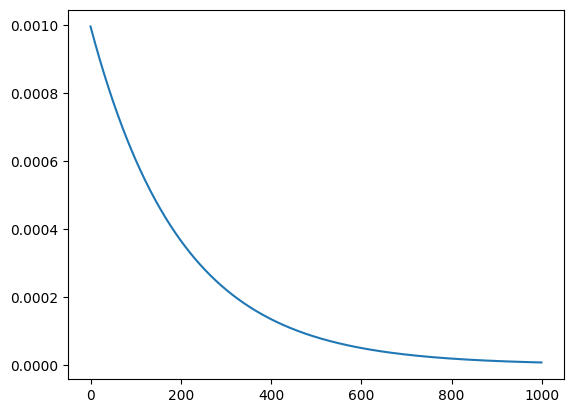

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
# # scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=10000, power=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

lrs = []
for _ in range(1000):
  scheduler.step()
  # lr = optimizer.param_groups[0]['lr']
  lrs.append(scheduler.get_last_lr())


plt.plot(lrs)

# plt.plot([(1-(i+1)/100)**0.9*1e-3 for i in range(100)])

In [ ]:
# batch = 5
# iterations = 5000
# training_size = 367

# epochs = iterations / math.ceil(training_size / batch)
# print(epochs)

# epochs = 300
# iterations = epochs * math.ceil(training_size / batch)
# print(iterations)

In [ ]:
del(net)

## Loss

In [ ]:
class FocalLoss(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    # place mask over placeholder pixels (loss do not propagate through them)
    mask = torch.where(y_true == FILL_PIX, zeros_like(y_true), ones_like(y_true))

    y_true = (y_true * mask).squeeze(dim=1)
    # one-hot encode labels
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=NUM_CLASSES).float().permute(0, 3, 1, 2)

    y_pred = y_pred * mask
    focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (focal_loss * mask).sum() / (mask.sum()+1e-16)

    return loss

class CELoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=FILL_PIX, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    return loss


## Metric

In [ ]:
# TODO: DICE accuracy

### Raw pixel accuracy

In [ ]:
class AccuracyMetric_archived(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax)->dict:
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class, avg, and global accuracies
    '''
    metrics = {}

    ious = self.iou(y_pred_softmax, y_true.squeeze(dim=1))
    for i, c in CLASS_MAP.items():
      metrics[f'iou/{c}'] = ious[i]
    # metrics['iou/mean'] = ious.mean()

    # select most probable class
    y_pred = torch.argmax(y_pred_softmax, 1, keepdim=True)

    # compute per-class accuracy
    for i, c in CLASS_MAP.items():
      # filter gt pixels for class c
      correct_pixels = (y_true == i) * (y_pred == y_true)
      # index by the class name
      metrics[f'acc/{c}'] = correct_pixels.sum()/((y_true == i).sum() + 1e-16)

    # compute average per-class accuracy
    avg_accuracy = 0
    for a in metrics.values():
      avg_accuracy += a
    # metrics['acc/avg'] = avg_accuracy / len(metrics.values())

    # compute global accuracy
    mask = y_true != FILL_PIX # binary mask
    # correct pixels
    diff = y_pred == y_true
    # filter
    metrics['acc/global'] = (diff*mask).sum() / mask.sum()

    return metrics


### IOU

In [ ]:
class IOUMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class and mean IOUs
    '''
    out = {}
    ious = self.iou(y_pred_softmax, y_true)
    for i, c in CLASS_MAP.items():
      out[c] = ious[i]
    out['mean'] = ious.mean()
    return out

## Confusion Matrix

In [ ]:
class AccuracyMetric(object):
  def __init__(self):
    pass

  def __call__(self, confusion_matrix:Tensor)->dict:
    '''
    Args
    ---------
    confusion_matrix: Tensor (c x c)
    n: int
    '''
    cm = confusion_matrix
    metrics = {}

    TPs = torch.diagonal(cm, 0)
    FPs = torch.sum(cm, dim=0) - TPs
    FNs = torch.sum(cm, dim=1) - TPs

    accs = TPs / (TPs + FNs)

    ious = TPs / (FNs + FPs + TPs)

    avg_acc = accs.mean()
    miou = ious.mean()

    for c in range(NUM_CLASSES):
      metrics[f'iou/{CLASS_MAP[c]}'] = ious[c].item()
    metrics['iou/mean'] = miou.item()

    for c in range(NUM_CLASSES):
      metrics[f'acc/{CLASS_MAP[c]}'] = accs[c].item()
    metrics['acc/avg'] = avg_acc.item()
    metrics['acc/global'] = TPs.sum().item() / (cm.sum().item() + 1e-16)

    return metrics


def get_confusion_matrix(y_gt: Tensor, y_pred: Tensor, num_classes: int) -> Tensor:
  """
  Compute the bins to update the confusion matrix with, code adapted from torchmetrics
  Args
  ----------
  y_gt: torch.tensor (n, 1, 224, 224)
  y_pred: torch.tensor (n, 1, 224, 224)
  num_classes: int

  Returns
  ----------
  confusion_matrix: torch.tensor(num_classes, num_classes)
  """

  unique_mapping = y_gt.to(torch.long) * num_classes + y_pred.to(torch.long)
  bins = torch.bincount(unique_mapping.flatten(), minlength=num_classes*(num_classes+1))
  # print(bins)
  # print(bins.reshape(12, 11))
  # print(bins.reshape(12, 11)[0, :])

  return bins[:num_classes**2].reshape(num_classes, num_classes)


In [ ]:
def count_classes(y_gt: Tensor) -> Dict[str, int]:
  '''
  Returns a dictionary containing counts of whether classes appear in image

  Args
  ----------
  y_gt: torch.tensor (n, 1, 224, 224)
  '''
  out = {c: 0 for c in CLASS_MAP.values()}

  for y in y_gt:
    for i, c in CLASS_MAP.items():
       if i in y_gt:
        out[c] += 1

  return out

In [ ]:
def calibrate_accs(accs, counts, m) -> Dict[str, int]:
  '''
  computes the proper per-class accuracy and ious based on counts, along with MIOU and avg acc
  '''
  # print(counts)
  total_ious, total_accs = 0, 0
  for c, n in counts.items():
    accs[f'iou/{c}'] = accs[f'iou/{c}'].item() / (n + 1e-16)
    total_ious += accs[f'iou/{c}']

    accs[f'acc/{c}'] = accs[f'acc/{c}'].item() / (n + 1e-16)
    total_accs += accs[f'acc/{c}']

  accs['iou/mean'] = total_ious / NUM_CLASSES
  accs['acc/avg'] = total_accs / NUM_CLASSES
  accs['acc/global'] = accs['acc/global'].item() / m

  return accs


In [ ]:
# xs, ys = next(iter(dataloaders['train']))

# print(xs.shape)
# print(ys.shape)
# old_metric = AccuracyMetric_archived()
# metric = Accuracy_metric()

# y_logit = training_manager.net(xs)
# y_pred = torch.argmax(y_logit, 1, keepdim=True)
# old_scores = old_metric(ys, y_logit)

# unique_mapping = ys.to(torch.long) * NUM_CLASSES + y_pred.to(torch.long)
# bins = torch.bincount(unique_mapping.flatten(), minlength=NUM_CLASSES*(NUM_CLASSES+1))

# cm = get_confusion_matrix(ys, y_pred, NUM_CLASSES)
# new_scores = metric(cm, xs.shape[0])

# new_scores

# Bayesian Functions

## Bayes Forward
Imported from local modules

    Performs k forward passes with stochastic regularisation

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor (k x c x W x H) buffer

    Returns
    -----------
    y_softmax            : torch.tensor (c x W x H)
    y_pred               : torch.tensor (W x H)
    y_pred_std_per_class : torch.tensor (c x W x H)
    y_pred_std_avg       : torch.tensor (W x H)

## Bayes Evaluation Pass

Only outputs the final predictions, used for inference on test set & saves some computation

    Performs k forward passes with dropout layers, returns prediction

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor(k x c x W x H) buffer

    Returns
    -----------
    y_pred               : torch.tensor (W x H)

## Calibration

In [ ]:
def compute_calibration_statistics(total_counts, total_corrects, confs):
  '''
  Computes the calibration statistics given the buckets
  '''
  num_buckets = len(total_counts)
  n = total_counts.sum()

  step = 1/num_buckets

  ECE = 0
  MCE = 0

  for i in range(num_buckets):
    conf = confs[i]
    acc = total_corrects[i]/total_counts[i]
    calibration_error = total_counts[i] * np.absolute(conf - acc)

    ECE += calibration_error / n
    MCE = max(calibration_error / n, MCE)

  return ECE, MCE

In [ ]:
def get_calibration(net:nn.Module,
                    dataloader:DataLoader,
                    k:int,
                    mode: Optional[str]='all',
                    num_buckets:Optional[int]=10
):
  '''
  Returns array of buckets for the reliability plot

  Args
  -----------
  net: nn.Module
  dataloader: torch.Dataloader
  k: set to 0 for regular forward pass, or larger than 0 for bayes forward pass
  mode: sets the mode of which bayesian inference to perform
  num_buckets: number of buckets to separate between 0 to 100 probabiliy

  Returns
  -----------
  total_counts: (num_buckets, ) np array, number of instances with confidence in the bucket
  total_corrects: (num_buckets, ) np array, number of correct instances with confidence in the bucket
  total_confs: (num_buckets, ) np array, the confidence score for each bucket by the network
  '''
  total_counts = np.array([1e-16]*num_buckets, dtype=np.float32)
  total_corrects = np.array([0]*num_buckets, dtype=np.float32)
  total_confs = np.array([0]*num_buckets, dtype=np.float32)

  # loop through images and make predictions
  for X_batch, y_batch in tqdm(dataloader):
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        net.eval()
        # bayes forward pass
        if k == 0:
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
        elif k > 0:
          net.set_bayes_mode(True, mode)
          y_softmax, _, _, _ = bayes_forward(net, x, k)

        counts, corrects, conf = get_calibration_per_prediction(y, y_softmax, num_buckets)
        total_counts += counts
        total_corrects += corrects
        total_confs += conf

  # buckets = total_corrects / total_counts

  return total_counts, total_corrects, total_confs/total_counts

def get_calibration_per_prediction(y_gt, y_softmax, num_buckets):
  '''
  Computes reliability values for each image

  Args
  -----------
  y_gt: torch.tensor (1 x W x H)
  y_softmax: torch.tensor (c x W x H)
  num_buckets: int

  Returns
  -----------
  counts: np.array (num_buckets, ) counts in each bin
  correct: np.array (num_buckets, ) number of corrects in each bin
  conf: np.array (num_buckets, ) the average confidence p
  '''
  mask = (y_gt!=FILL_PIX).to(float)
  out_count = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  out_correct = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  out_conf = np.array([0 for _ in range(num_buckets)], dtype=np.float32)
  step = 1/num_buckets
  # get probability and prediction
  y_prob, y_pred = torch.max(y_softmax, dim=0)
  indices = y_prob // step

  for i in range(num_buckets):
    idx_mask = mask*(indices==i)
    out_count[i] = (idx_mask).sum()
    out_correct[i] = (idx_mask*(y_pred==y_gt)).sum()
    out_conf[i] = (idx_mask*y_prob).sum().item()
  return out_count, out_correct, out_conf


## Epistemic & Aleatoric Uncertainties

In [ ]:
def compute_bayesian_uncertainties(net, X:Tensor, k:int, mode:Optional[str]='all')->Tuple[Tensor, Tensor]:
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (c x W x H), a single input image
  k  : int, indicating number of repeated forwards passes
  mode: str, indicating what mode of bayesian inference to do

  Returns
  -----------
  predictive_entropy: torch.tensor (W x H)
  mutual_information: torch.tensor (W x H)
  y_pred: torch.tensor (W x H)
  '''
  assert (k>=1)

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, mode)
    # write image to buffer
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
    for i in range(k):
      buffer[i] = X

    eps = 1e-8
    y_logits = net(buffer)
    y_softmax = y_logits.softmax(dim=1) # k x c x W x H
    avg_over_k = y_softmax.mean(dim=0) # c x W x H
    predictive_entropy = -(avg_over_k * torch.log(avg_over_k+eps)).sum(dim=0) # W x H
    mutual_information = predictive_entropy + 1/k * (y_softmax*torch.log(y_softmax+eps)).sum(dim=0).sum(dim=0) # W x H

    epistemic_uncertainty = mutual_information
    aleatoric_uncertainty = predictive_entropy - epistemic_uncertainty

    y_pred = torch.argmax(avg_over_k, dim=0)

  return predictive_entropy, mutual_information, y_pred

## PAvPU

In [ ]:
def PAvPU(gt: Tensor,
          pred: Tensor,
          uncertainty: Tensor,
          min_uncertainty: float,
          max_uncertainty: float,
          acc_threshold: Optional[float]=0.5,
          window: Optional[int]=4,
          num_buckets=100)->float:
  '''
  Computes PAvPU for a single image
  Args
  --------
  gt: Tensor (1 x w x h)
  pred: Tensor (1 x w x h)
  uncertainty: Tensor (1 x w x h)
  acc_threshold: float indicating threshold for correct/wrong
  window: slider size
  Returns
  --------
  pa: List[float] P(accurate|certain)
  pu: List[float] P(inaccurate|uncertain)
  PAvPU: List[float]
  '''

  pas, pus, pavpus = [], [], []


  def compute_pavpu(a, mask, percentage_certain, p_threshold):
    c = (percentage_certain < p_threshold).to(float)
    u = (percentage_certain >= p_threshold).to(float)

    nac = (a * c * mask).sum()
    nic = ((1-a) * c * mask).sum()
    niu = ((1-a) * (1-c) * mask).sum()
    nau = (a * (1-c) * mask).sum()

    pa = nac/(nac + nic + 1e-16)
    pu = niu/(nic + niu + 1e-16)

    pavpu = (nac + niu) / (nac + nau + nic + niu + 1e-16)

    return pa.item(), pu.item(), pavpu.item()

  sum_pool = nn.AvgPool2d(kernel_size=window, stride=window, divisor_override=1)

  # valid pixels
  mask = (gt!=FILL_PIX).to(float)
  # indicates no. of "active pixels" in the pooled dimension
  active_pixels = (sum_pool(mask).to(float))

  # turn off outputs on invalid pixels so they don't count towards the sum
  corrects = (pred==gt)*mask.to(float)
  uncertainty = (uncertainty*mask).to(float)

  norm_factor = uncertainty.sum()

  # compute average per patch
  percentage_correct = sum_pool(corrects) / (active_pixels+1e-16)
  percentage_certain = sum_pool(uncertainty) / (active_pixels+1e-16)

  # percentage_certain /= norm_factor

  a = (percentage_correct >= acc_threshold).to(int)
  i = (percentage_correct == acc_threshold).to(int)

  # indicates patches with no valid pixels
  binary_mask = (active_pixels!=0).to(int)
  # print(binary_mask.sum())

  for n in range(num_buckets):
    step = n * 1/num_buckets

    # max_uncertainty, min_uncertainty = percentage_certain.max(), percentage_certain.min()

    uncertainty_threshold = min_uncertainty + step * (max_uncertainty - min_uncertainty)
    # uncertainty_threshold = step

    pa, pu, pavpu = compute_pavpu(a, binary_mask, percentage_certain, uncertainty_threshold)

    pas.append(pa)
    pus.append(pu)
    pavpus.append(pavpu)

  return pas, pus, pavpus



In [ ]:
def compute_average_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
)->Tuple[float, float, float]:

  if not dataloader:
    dataloader = val_dataloader

  avg_wa_p, avg_entropy, avg_mutual_info = 0, 0, 0
  with torch.no_grad():
    for X_batch, y_batch in tqdm(dataloader):
      # force loop to be over single images
        for (x, y) in zip(X_batch, y_batch):
          mask = (y!=FILL_PIX).to(float) # (w x h)
          # mask = torch.ones_like(y).to(float)

          # normal forward pass
          net.eval()
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
          # compute entropy (adjusted by fill pix)
          entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) * mask # (w x h)
          avg_wa_p += entropy.sum() / (mask.sum() + 1e-16)

          # bayes pass
          net.eval()
          net.set_bayes_mode(True, 'all')

          entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')
          # buffer = x.unsqueeze(0).repeat(k, 1, 1, 1) # (k x 3 x w x h)
          # # softmax averaged across k forward passes
          # y_softmax = net(buffer).softmax(dim=1).mean(dim=0) # (11 x w x h)
          # # compute entropy (adjusted by fill pix)
          # entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) * mask # (w x h)
          # print(y_softmax)
          entropy = entropy * mask
          mutual_info = mutual_info * mask

          avg_entropy += entropy.sum() / (mask.sum() + 1e-16)
          avg_mutual_info += mutual_info.sum() / (mask.sum() + 1e-16)

  avg_wa_p = avg_wa_p / len(dataloader.dataset)
  avg_entropy = avg_entropy / len(dataloader.dataset)
  avg_mutual_info = avg_mutual_info / len(dataloader.dataset)

  return avg_wa_p.item(), avg_entropy.item(), avg_mutual_info.item()


In [ ]:
def compute_min_max_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
) -> Dict[str, Tuple[float, float]]:
    if not dataloader:
      dataloader = val_dataloader

    output = {'wa': [np.inf, -np.inf],
              'PE': [np.inf, -np.inf],
              'MI': [np.inf, -np.inf],}

    def parse_min(tensor, mask):
        return torch.where(mask == 1, tensor, torch.inf).min()

    def parse_max(tensor, mask):
        return torch.where(mask == 1, tensor, -torch.inf).max()

    with torch.no_grad():
      for X_batch, y_batch in tqdm(dataloader):
        # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            mask = (y!=FILL_PIX).to(float) # (w x h)

            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
            # compute entropy (adjusted by fill pix)
            entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) # (w x h)

            output['wa'][0] = min(output['wa'][0], parse_min(entropy, mask))
            output['wa'][1] = max(output['wa'][1], parse_max(entropy, mask))

            # bayes pass
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')

            output['PE'][0] = min(output['PE'][0], parse_min(entropy, mask))
            output['PE'][1] = max(output['PE'][1], parse_max(entropy, mask))
            output['MI'][0] = min(output['MI'][0], parse_min(mutual_info, mask))
            output['MI'][1] = max(output['MI'][1], parse_max(mutual_info, mask))

      return output


In [ ]:
def compute_mean_std_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
) -> Dict[str, Tuple[float, float]]:
    if not dataloader:
      dataloader = val_dataloader
    #                x  x^2
    track  = {'wa': [0, 0],
              'PE': [0, 0],
              'MI': [0, 0],}

    with torch.no_grad():
      for X_batch, y_batch in tqdm(dataloader):
        # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            mask = (y!=FILL_PIX).to(float) # (w x h)

            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
            # compute entropy (adjusted by fill pix)
            entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) # (w x h)

            output['wa'][0] += (entropy * mask).sum()
            output['wa'][1] += (entropy **2 * mask).sum()

            # bayes pass
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')

            output['PE'][0] = (entropy * mask).sum()
            output['PE'][1] = (entropy **2 * mask).sum()
            output['MI'][0] = (mutual_info * mask).sum()
            output['MI'][1] = (mutual_info **2 * mask).sum()

      n = len(dataloader.dataset)
      output = {}
      for k, (x, x2) in track.items():
        output[k] = [x/n, (x2/n - (x/n)**2)**0.5]

      return output

In [ ]:
def compute_auc(ys, xrange:Optional[int]=1):
  n = len(ys)
  step = xrange/n

  auc = 0
  prev = ys[0]
  for i in range(n):
    curr = ys[i]
    area = (curr+prev)/2 * step
    auc += area
    prev = curr

  return auc

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [ ]:
class TrainingManager():
  def __init__(self, datasets, config):
    self.datasets = datasets
    self.config = config

    self._load()
    # self.net = copy.deepcopy(net).to(DEVICE) # no longer importing net

  def _load(self):
    # hyperparameters from config
    self.batch_size = self.config.get('batch_size', 16)
    self.total_epochs = self.config.get('total_epochs', 100)
    self.weight_decay = self.config.get('weight_decay', 1e-4)
    self.lr = self.config.get('lr', 1e-4)
    self.k = self.config.get('k', 10)
    self.patience = self.config.get('patience', 20)
    self.track_metrics = self.config.get('track_metrics', ['loss'])
    self.num_classes = self.config.get('num_classes', 3)
    self.bayes_mode = self.config.get('bayes_mode', 'all')
    self.eval_subset = self.config.get('eval_subset', None)


    # initiate dataloader
    self.dataloaders = {'train': DataLoader(self.datasets['train'], batch_size=self.batch_size, shuffle=True),
                        'val': DataLoader(self.datasets['val'], batch_size=1, shuffle=True),
                        'test': DataLoader(self.datasets['test'], batch_size=1, shuffle=False)}

    # initiate net
    self.net = Unet(encoder_name=self.config['model'],
                    num_classes=self.config['num_classes'],
                    width_mult=self.config.get('width_mult', None),
                    depth_mult=self.config.get('depth_mult', None),
                    input_dim=self.config['input_dim'],
                    stochastic_depth_prob=self.config['stochastic_depth_prob'],
                    use_se=self.config.get('use_se', None),
                    dropout_p=self.config['dropout_p'],
                    constant_dropout = self.config['dropout_mode'] == 'constant',
                    last_channel=self.config.get('last_channel', None),
                    skip_mode=self.config.get('skip_mode', 'upsample'),
                    skip_op=self.config.get('skip_op', 'concat'),
                    shallowDeconv=self.config.get('shallowDeconv', False),
                    dropout_loc=self.config.get('dropout_loc', None),
                    )

    print("----UNET----")
    size_all_mb = calculate_storage(self.net)
    print("model size: {:.3f}MB".format(size_all_mb))
    total_params = count_parameters(self.net)
    print(f"Total Trainable Params: {total_params/1e6 :.3f}M")
    print('------------')

    self.net.to(DEVICE)
    self.best_net = None

    self.loss_func = self.config.get('loss', 'CE')
    if self.loss_func == 'Focal':
      self.criterion = FocalLoss()
    elif self.loss_func == 'CE':
      self.criterion = CELoss()
    else:
      print('Invalid loss function')
      raise ValueError()

    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)
    if self.config['scheduler'] == 'poly':
      # total_iters = self.total_epochs * math.ceil(len(self.dataloaders['train'].dataset)/self.batch_size)
      total_iters = self.total_epochs
      self.scheduler = optim.lr_scheduler.PolynomialLR(self.optimizer, total_iters=total_iters, power=0.9)
      print(f'Training for {total_iters} iterations')
    elif self.config['scheduler'] == 'exp':
      self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.995)
      self.total_epochs = 10000
    else:
      self.scheduler = optim.lr_scheduler.ConstantLR(self.optimizer, total_iters=self.total_epochs, factor=1)
    # TODO: add other scheduler options, or handle no scheduler

    self.epoch = 0
    self.early_stop = False
    self.history = {'lr': []}

    for split in ['train', 'val', 'val_b']:
      self.history[f'loss/{split}'] = []
      self.history[f'acc/avg/{split}'] = []
      self.history[f'acc/global/{split}'] = []
      self.history[f'iou/mean/{split}'] = []
      for c in CLASS_MAP.values():
        self.history[f'acc/{c}/{split}'] = []
        self.history[f'iou/{c}/{split}'] = []

    self.history['best_val_loss'] = 999
    self.history['best_val_miou'] = 0
    self.history['best_val_acc'] = 0
    self.history['best_epoch'] = 0
    self.patience_count = 0

  def train(self, epochs, eval_mode='bayes'):
    # torch.cuda.empty_cache() # helps clearing RAM
    # self.net.train()
    # self.net.set_bayes_mode(True, net.set_bayes_mode)
    self.early_stop=False
    for e in range(epochs):
      self.net.train()
      self.net.set_bayes_mode(True, 'all')
      # create temporary dict to hold epoch results for train set
      train_loss = 0
      confusion_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_logits = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_logits)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # update loss
        batch_size = X_batch.shape[0]
        train_loss += loss.item() * batch_size
        # update confusion matrix
        y_pred = torch.argmax(y_logits, 1, keepdim=True)
        confusion_matrix += get_confusion_matrix(y_batch, y_pred, NUM_CLASSES)

      self.scheduler.step()

      # compute average train loss
      n_train = len(self.dataloaders['train'].dataset)
      train_loss /= n_train

      # compute metrics
      accs = self.metric(confusion_matrix)

      # log epoch loss and accuracy
      self.history['loss/train'].append(train_loss)
      for k,v in accs.items():
        self.history[f'{k}/train'].append(v)

      val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode, subset=self.eval_subset)

      if val_loss is not None:
        self.history['loss/val'].append(val_loss)
        for name in val_accs.keys():
          self.history[f'{name}/val'].append(val_accs.get(name, 0))

      if val_loss_b is not None:
        self.history['loss/val_b'].append(val_loss_b)
        for name in val_accs_b.keys():
          self.history[f'{name}/val_b'].append(val_accs_b.get(name, 0))

      self._update_best_net()
      self.history['lr'].append(self.scheduler.get_last_lr()[0])
      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Train: Acc(g) = {self.history['acc/global/train'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/train'][-1]*100:.4f}, mIOU = {self.history['iou/mean/train'][-1]*100:.4f}, Loss = {self.history['loss/train'][-1]:.4f}")
      print(f"Val: Acc(g) = {self.history['acc/global/val'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/val'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val'][-1]*100:.4f}, Loss = {self.history['loss/val'][-1]:.4f}")
      if eval_mode == 'all' or eval_mode == 'bayes':
        print(f"Bayes_validation: Acc = {self.history['acc/global/val_b'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val_b'][-1]*100:.4f}, Loss = {self.history['loss/val_b'][-1]:.4f}")

      if self.early_stop or self.epoch >= self.total_epochs:
        print('finished training')
        return

  # def _lr(self)->float:
  #   return self.optimizer.param_groups[0]['lr']

  def _set_lr(self, lr:float)->None:
    self.optimizer.param_groups[0]['lr'] = lr

  def _update_best_net(self, min_epochs=10):
    # metric = 'loss/val'
    if self.epoch < min_epochs or len(self.history['loss/val']) <= 1:
      return

    update_best = False
    loss = self.history['loss/val'][-1]
    acc = self.history['acc/avg/val'][-1]
    miou = self.history['iou/mean/val'][-1]

    curr_min_loss = self.history.get('best_val_loss', 999)
    curr_max_acc = self.history.get('best_val_acc', 0)
    curr_max_miou = self.history.get('best_val_miou', 0)

    if 'loss' in self.track_metrics and loss < curr_min_loss:
      print(f'loss decreased by {(curr_min_loss-loss)/curr_min_loss*100 :.3f} %')
      self.history['best_val_loss'] = loss
      update_best = True

    if 'acc' in self.track_metrics and acc > curr_max_acc:
      print(f'acc increased by {(acc-curr_max_acc)/(curr_max_acc+1e-16)*100 :.3f} %')
      self.history['best_val_acc'] = acc
      update_best = True

    if 'miou' in self.track_metrics and miou > curr_max_miou:
      print(f'miou increased by {(miou-curr_max_miou)/(curr_max_miou+1e-16)*100 :.3f} %')
      self.history['best_val_miou'] = miou
      update_best = True

    if miou < curr_max_miou and acc < curr_max_acc:
      self.patience_count += 1

    if update_best:
      print('saving best net...')
      self.best_net = copy.deepcopy(self.net)
      self.history['best_epoch'] = self.epoch
      self.patience_count = 0

    if self.patience_count >= self.patience:
      print(f'Acc(c) or miou have not improved for {self.patience} epochs, terminate training')
      self.early_stop = True

  def _evaluate_regular(self,
                        dataloader:DataLoader,
                        net:Optional[nn.Module]=None
  ) -> Tuple[int, dict[str, float]]:
    net = net if net != None else self.net
    net.eval()
    net.set_bayes_mode(False, 'all')
    total_loss = 0
    confusion_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)

    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_logits = net(X)
        # compute loss & acc
        loss = self.criterion(y, y_logits)

        y_pred = torch.argmax(y_logits, 1, keepdim=True)
        cm = get_confusion_matrix(y, y_pred, NUM_CLASSES)
        confusion_matrix += cm

        total_loss += loss * len(X)

    n = len(dataloader.dataset)
    loss = total_loss.item()/n

    accs = self.metric(confusion_matrix)

    return loss, accs

  def _evaluate_bayes(self, dataloader, k=None, net=None):
    net = net if net != None else self.net

    if k == None:
      k = self.k

    h, w = self.config['input_dim']
    buffer_tensor = torch.empty(size=(k, 3, h, w), dtype=torch.float32, device=DEVICE)

    total_loss = 0
    confusion_matrix = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)

    for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_logits, _, _, _ = bayes_forward(net, x, k, self.bayes_mode, buffer_tensor)
        y_logits = y_logits.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_logits)

        y_pred = torch.argmax(y_logits, 1, keepdim=True)
        cm = get_confusion_matrix(y, y_pred, NUM_CLASSES)
        confusion_matrix += cm

        total_loss += loss

    n = len(dataloader.dataset)
    loss = total_loss.item()/n

    accs = self.metric(confusion_matrix)

    return loss, accs

  def evaluate(self,
               eval_dataset:str='val',
               mode:str='bayes',
               subset:Optional[int]=None,
               k:Optional[int]=None
    ) -> Tuple[int, dict, int, dict]:
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all', 'none'])

    temp_dict = {}
    for c in CLASS_MAP.values():
      temp_dict[f'acc/{c}'] = 0
      temp_dict[f'iou/{c}'] = 0
    temp_dict['acc/avg'] = 0
    temp_dict['acc/global'] = 0
    temp_dict['iou/mean'] = 0

    # generate subset
    if not subset:
      dataloader = self.dataloaders[eval_dataset]
    else:
      indices = torch.randperm(len(self.datasets[eval_dataset]))[:subset]
      sub_eval_dataset = torch.utils.data.Subset(self.datasets[eval_dataset], indices)
      dataloader = DataLoader(sub_eval_dataset, batch_size=1, shuffle=True)

    # initiate temporary values
    loss, accs, loss_b, accs_b = 0, temp_dict, 0, temp_dict
    if mode == 'regular':
      loss, accs = self._evaluate_regular(dataloader)
    elif mode == 'bayes':
      loss_b, accs_b = self._evaluate_bayes(dataloader, k=k)
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, accs = self._evaluate_regular(dataloader)
      loss_b, accs_b = self._evaluate_bayes(dataloader, k=k)
    else:
      return

    return loss, accs, loss_b, accs_b

  def load(self, directory, load_best=False):
    self._load_config_from_dir(directory)
    self._load_network_from_dir(directory, load_best)
    self._load_history_from_dir(directory)

    return

  def _load_config_from_dir(self, directory):
    print('Loading config...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    config_path = os.path.join(root_dir, directory, 'config.json')
    with open(config_path) as f:
      self.config = json.load(f)
    if type(self.config['input_dim']) is list:
      dim1, dim2 = self.config['input_dim']
      # rewrite as tuple
      self.config['input_dim'] = (dim1, dim2)
    self._load()
    return

  def _load_network_from_dir(self, directory, load_best=False):
    print('Loading network weights...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    if 'model.pt' not in os.listdir(os.path.join(root_dir, directory)):
      print('No trained weights found, using untrained network')
    else:
      # load network
      if load_best:
        ckpt_path = os.path.join(root_dir, directory, 'model_best.pt')
      else:
        ckpt_path = os.path.join(root_dir, directory, 'model.pt')
      ckpt = torch.load(os.path.join(ckpt_path), map_location=DEVICE)
      self.net.load_state_dict(ckpt)
    print(f'Loaded network at {ckpt_path}')
    return

  def _load_history_from_dir(self, directory):
    print('Loading history...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    history_path = os.path.join(root_dir, directory, 'history.json')
    with open(history_path) as f:
      self.history = json.load(f)
    self.epoch = self.history['epoch']

    print(f'loaded network trained for {self.epoch} epochs')


# Results Manager

In [ ]:
class ResultsManager():
  def __init__(self, training_manager:TrainingManager):
    self.training_manager = training_manager
    self.history = training_manager.history
    self.config = training_manager.config

    self.directory = self._create_experiment_dir()
    # self._save_config()

  def _create_experiment_dir(self) -> str:
    dataset = self.config.get("dataset", 'camvid')
    result_dir = f'/content/drive/MyDrive/ShorelineNet_pytorch/results/{dataset}/'
    exp = self.config['experiment']

    experiment_dir = os.path.join(result_dir, exp)

    if exp not in os.listdir(result_dir):
      os.mkdir(experiment_dir)
      print(f'created directory {experiment_dir}')
    else:
      num_items = len(os.listdir(experiment_dir))
      if num_items > 0:
        print('Warning: duplicate experiment name!')
        print(f'Directory at {experiment_dir} already exists and contains {num_items} items')

    return experiment_dir

  def _save_model(self, save_best:Optional[bool]=True):
    print(f'saving model at {self.training_manager.epoch} epochs...')
    # TODO: save best model (on validation set)
    torch.save(self.training_manager.net.state_dict(), os.path.join(self.directory, 'model.pt'))
    print(f"saving best model at {self.history['best_epoch']} epochs...")
    if save_best and self.training_manager.best_net != None:
      torch.save(self.training_manager.best_net.state_dict(), os.path.join(self.directory, 'model_best.pt'))
    return

  def _save_history(self):
    print('saving history...')
    # add date and epoch to history
    history = self.history.copy()
    # history['date'] = str(date.today())
    history['epoch'] = self.training_manager.epoch
    filepath = os.path.join(self.directory, 'history.json')
    with open(filepath, "w") as f:
      json.dump(history, f, indent=2)
    return

  def _save_config(self):
    print('saving config...')
    filepath = os.path.join(self.directory, 'config.json')
    with open(filepath, "w") as f:
      json.dump(self.config, f, indent=2)
    return

  def _save_performance(self, k:Optional[int]=10):
    print('saving performance...')
    performance = {'train': {}, 'val': {}, 'test': {}}

    # TRAIN & VALIDATION SET
    print('   retrieving information for train & val set...')
    for split in ['train', 'val']:
      performance[split] = {}
      for metric in ['loss', 'acc/avg', 'acc/global', 'iou/mean']:
        performance[split][metric] = self.history[f'{metric}/{split}'][-1]
      performance[split]['iou'] = {}
      for c in CLASS_MAP.values():
        performance[split]['iou'][f'{c}'] = self.history[f'iou/{c}/{split}'][-1]

    # TEST SET
    print(f'   evaluating on test set, bayes k={k} ...')
    l, a, l_b, a_b = self.training_manager.evaluate('test', mode='all', k=k)

    performance['test']['loss'] = l
    performance['test']['loss/bayes'] = l_b
    for metric in ['acc/avg', 'acc/global', 'iou/mean']:
      performance['test'][f'{metric}'] = a[metric]
      performance['test'][f'{metric}/bayes'] = a_b[metric]

    print(f"Test mIOU={performance['test']['iou/mean']:.3f}")
    print(f"Bayes mIOU={performance['test']['iou/mean/bayes']:.3f}")

    performance['test']['iou'] = {}
    performance['test']['acc'] = {}
    for c in CLASS_MAP.values():
      performance['test']['iou'][f'{c}'] = a[f'iou/{c}']
      performance['test']['iou'][f'{c}/bayes'] = a_b[f'iou/{c}']
      performance['test']['acc'][f'{c}'] = a[f'acc/{c}']
      performance['test']['acc'][f'{c}/bayes'] = a_b[f'acc/{c}']

    filepath = os.path.join(self.directory, 'performance.json')
    with open(filepath, "w") as f:
      json.dump(performance, f, indent=2)
    print(f"saved network performance properties to {filepath}")

    return performance

  def _save_properties(self):
    net = self.training_manager.net
    print('saving network properties...')
    properties = {}
    properties['date'] = str(date.today())
    properties['experiment'] = self.config['experiment']
    properties['description'] = self.config['description']

    # Calculate network storage
    properties['size'] = {
        'total': calculate_storage(net, False),
        'encoder': calculate_storage(net.encoder, False),
        'decoder': calculate_storage(net.decoder, False),
    }
    properties['params'] = {
        'total': count_parameters(net)/1e6,
        'encoder': count_parameters(net.encoder)/1e6,
        'decoder': count_parameters(net.decoder)/1e6,
    }
    print(f"model size: {properties['size']['total']:.3f}MB")
    print(f"total params: {properties['params']['total']:.3f}M")

    # FLOPS
    properties['GFLOP'] = count_FLOPS(net)/1e9
    print(f"GFLOPs: {properties['GFLOP']:.3f}")

    # Inference time and memory
    print('calculating gpu runtime and memory...')
    gpu_runtimes, gpu_memories = compute_gpu_runtime_memory(net)

    print('calculating cpu runtime and memory...')
    cpu_runtimes, cpu_memories = compute_cpu_runtime_memory(copy.deepcopy(net))

    properties['runtime']={'cpu': cpu_runtimes.mean(), 'gpu': gpu_runtimes.mean()}
    properties['runtime_std']={'cpu': cpu_runtimes.std(), 'gpu': gpu_runtimes.std()}
    properties['memory']={'cpu': cpu_memories.mean(), 'gpu': gpu_memories.mean()}
    properties['memory_std']={'cpu': cpu_memories.std(), 'gpu': gpu_memories.std()}

    print(f"GPU Runtime: {properties['runtime']['gpu']:.2f}ms +- {properties['runtime_std']['gpu']:.2f}")
    print(f"GPU Memory: {properties['memory']['gpu']:.2f}Mb +- {properties['memory_std']['gpu']:.2f}")

    # save
    filepath = os.path.join(self.directory, 'network.json')
    with open(filepath, "w") as f:
      json.dump(properties, f, indent=2)
      print(f"saved network properties to {filepath}")

    # make sure network is back to device
    net.to(DEVICE)

    return properties

  def _save_calibration(self):
    print('saving calibration...')
    self.plot_calibration(save=True)

  def _save_pavpu(self):
    print('saving pavpu...')
    self.compute_and_plot_PAvPU(save=True)

  def save(self,
           save_properties=True,
           save_performance=True,
           save_calibration=True,
           save_pavpu=True,
           save_best=False,
           save_plot=False):
    # config.json
    self._save_config()

    # history.json: (training history)
    self._save_history()

    # save history plot
    self.plot(save=True)

    # save model
    self._save_model(save_best=save_best)

    # performance.json: (loss, metric, calibration)
    if save_performance:
      self._save_performance()

    # calibration.json: (ECE, MCE)
    if save_calibration:
      self._save_calibration()

    # pavpu.json:
    if save_pavpu:
      self._save_pavpu()

    # save network properties (FLOPS, params, etc)
    if save_properties:
      self._save_properties()

    print(f'Finished saving everything to {self.directory}.')

    return


  def plot(self, save=False):
    self.plot_history(save=save)

  def compute_and_plot_PAvPU(self, k=10, window=4, num_buckets=100, save=False):
    net = self.training_manager.net
    # avg_wa, avg_entropy, avg_mutual_info = compute_average_uncertainty(net, k=k)
    # # avg_wa, avg_bayes=0.16457550678050517, 0.2196
    # print(f'average uncertainty (wa): {avg_wa}')
    # print(f'average predictive entropy (bayes): {avg_entropy}')
    # print(f'average mutual information (bayes): {avg_mutual_info}')

    print('computing uncertainty ranges...')
    uncertainty_ranges = compute_min_max_uncertainty(net, k=k)
    print(f"WA: min={uncertainty_ranges['wa'][0]}, max={uncertainty_ranges['wa'][1]}")
    print(f"PE: min={uncertainty_ranges['PE'][0]}, max={uncertainty_ranges['PE'][1]}")
    print(f"MI: min={uncertainty_ranges['MI'][0]}, max={uncertainty_ranges['MI'][1]}")

    statistics = {}

    for mode in ['PE', 'MI', 'wa']:
      statistics[f"pa/{mode}"] = np.zeros(num_buckets)
      statistics[f"pu/{mode}"] = np.zeros(num_buckets)
      statistics[f"pavpu/{mode}"] = np.zeros(num_buckets)

    count = 0
    print('computing pavpu on test set...')
    with torch.no_grad():
      for X_batch, y_batch in tqdm(self.training_manager.dataloaders['test']):
          count += 1
          # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            eps=1e-5
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
            y_pred = torch.argmax(y_softmax, dim=0).unsqueeze(0)
            # compute entropy
            entropy = -(y_softmax * torch.log(y_softmax+eps)).sum(dim=0).unsqueeze(0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    entropy,
                                    uncertainty_ranges['wa'][0],
                                    uncertainty_ranges['wa'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/wa'] += np.array(pas)
            statistics['pu/wa'] += np.array(pus)
            statistics['pavpu/wa'] += np.array(pavpus)

            # BAYES PASS
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    entropy,
                                    uncertainty_ranges['PE'][0],
                                    uncertainty_ranges['PE'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/PE'] += np.array(pas)
            statistics['pu/PE'] += np.array(pus)
            statistics['pavpu/PE'] += np.array(pavpus)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    mutual_info,
                                    uncertainty_ranges['MI'][0],
                                    uncertainty_ranges['MI'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/MI'] += np.array(pas)
            statistics['pu/MI'] += np.array(pus)
            statistics['pavpu/MI'] += np.array(pavpus)

      for k, v in statistics.items():
        n = len(self.training_manager.dataloaders['test'].dataset)
        statistics[k] = v/count

      # add the average uncertainties to the statistics
      statistics["min_p/wa"]= uncertainty_ranges['wa'][0]
      statistics["max_p/wa"]= uncertainty_ranges['wa'][1]
      statistics["min_p/PE"]= uncertainty_ranges['PE'][0]
      statistics["max_p/PE"]= uncertainty_ranges['PE'][1]
      statistics["min_p/MI"]= uncertainty_ranges['MI'][0]
      statistics["max_p/MI"]= uncertainty_ranges['MI'][1]

      # compute AUCs
      statistics['auc/wa'] = compute_auc(statistics["pavpu/wa"])
      statistics['auc/PE'] = compute_auc(statistics["pavpu/PE"])
      statistics['auc/MI'] = compute_auc(statistics["pavpu/MI"])

      x = np.arange(0, 1, 1/num_buckets)
      plt.figure(figsize=(20, 5))
      plt.subplot(1, 3, 1)
      plt.title('PA')
      plt.plot(x[1:], statistics['pa/wa'][1:], label='wa')
      plt.plot(x[1:], statistics['pa/PE'][1:], label='PE')
      plt.plot(x[1:], statistics['pa/MI'][1:], label='MI')
      plt.legend()

      plt.subplot(1, 3, 2)
      plt.title('PU')
      plt.plot(x, statistics['pu/wa'], label='wa')
      plt.plot(x, statistics['pu/PE'], label='PE')
      plt.plot(x, statistics['pu/MI'], label='MI')
      plt.legend()

      plt.subplot(1, 3, 3)
      plt.title('PAvPU')
      plt.plot(x, statistics['pavpu/wa'], label=f"wa:{statistics['auc/wa']:.2f}")
      plt.plot(x, statistics['pavpu/PE'], label=f"PE:{statistics['auc/PE']:.2f}")
      plt.plot(x, statistics['pavpu/MI'], label=f"MI:{statistics['auc/MI']:.2f}")
      plt.legend()

      return statistics

      if save:
        plt.savefig(os.path.join(self.directory, 'pavpu.png'), dpi=200)
        print(f"Saved pavpu to {os.path.join(self.directory, 'pavpu.png')}")

        filepath = os.path.join(self.directory, 'pavpu.json')
        with open(filepath, "w") as f:
          json.dump(statistics, f, indent=2)

        print(f"saved to {filepath}")

      return statistics

  def compute_and_plot_PAvPU_prob(self, k=10, window=4, num_buckets=100, save=False):
    net = self.training_manager.net

    statistics = {}

    for mode in ['bayes', 'wa']:
      statistics[f"pa/{mode}"] = np.zeros(num_buckets)
      statistics[f"pu/{mode}"] = np.zeros(num_buckets)
      statistics[f"pavpu/{mode}"] = np.zeros(num_buckets)

    count = 0
    with torch.no_grad():
      for X_batch, y_batch in tqdm(self.training_manager.dataloaders['test']):
          count += 1
          if count == 20:
            break
          # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
            y_prob, y_pred = torch.max(y_softmax, dim=0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred.unsqueeze(0),
                                    -y_prob.unsqueeze(0),
                                    0,
                                    1,
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/wa'] += np.array(pas)
            statistics['pu/wa'] += np.array(pus)
            statistics['pavpu/wa'] += np.array(pavpus)

            # BAYES PASS
            net.eval()
            net.set_bayes_mode(True, 'all')

            # entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')
            y_softmax, _, _, _  = bayes_forward(net, x, k, mode='all')
            y_prob, y_pred = torch.max(y_softmax, dim=0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred.unsqueeze(0),
                                    -y_prob.unsqueeze(0),
                                    0,
                                    1,
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/bayes'] += np.array(pas)
            statistics['pu/bayes'] += np.array(pus)
            statistics['pavpu/bayes'] += np.array(pavpus)

      for k, v in statistics.items():
        n = len(self.training_manager.dataloaders['test'].dataset)
        statistics[k] = v/count

      # compute AUCs
      statistics['auc/wa'] = compute_auc(statistics["pavpu/wa"])
      statistics['auc/bayes'] = compute_auc(statistics["pavpu/bayes"])

      x = np.arange(0, 1, 1/num_buckets)
      plt.figure(figsize=(20, 5))
      plt.subplot(1, 3, 1)
      plt.title('PA')
      plt.plot(x[1:], statistics['pa/wa'][1:], label='wa')
      plt.plot(x[1:], statistics['pa/bayes'][1:], label='bayes')
      plt.legend()

      plt.subplot(1, 3, 2)
      plt.title('PU')
      plt.plot(x, statistics['pu/wa'], label='wa')
      plt.plot(x, statistics['pu/bayes'], label='bayes')
      plt.legend()

      plt.subplot(1, 3, 3)
      plt.title('PAvPU')
      plt.plot(x, statistics['pavpu/wa'], label=f"wa:{statistics['auc/wa']:.2f}")
      plt.plot(x, statistics['pavpu/bayes'], label=f"bayes:{statistics['auc/bayes']:.2f}")
      plt.legend()

      return statistics

      if save:
        plt.savefig(os.path.join(self.directory, 'pavpu.png'), dpi=200)
        print(f"Saved pavpu to {os.path.join(self.directory, 'pavpu.png')}")

        filepath = os.path.join(self.directory, 'pavpu.json')
        with open(filepath, "w") as f:
          json.dump(statistics, f, indent=2)

        print(f"saved to {filepath}")

      return statistics

  def plot_history(self, save=False):
    '''
    Plots training history

    loss    miou    acc(c, g)

    ious(t) ious(v) ious(vb)
    '''
    plt.figure(figsize=(20, 10))

    # history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
    history = self.history

    x = list(range(1, self.training_manager.epoch+1, 1))
    plt.subplot(2, 3, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('mIOU')
    plt.plot(x, history['iou/mean/train'], label='train',)
    plt.plot(x, history['iou/mean/val'], label='val')
    plt.plot(x, history['iou/mean/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('Accuracy')
    plt.plot(x, history['acc/global/train'], label='train(g)',)
    plt.plot(x, history['acc/global/val'], label='val(g)')
    plt.plot(x, history['acc/global/val_b'], label='val_b(g)')

    plt.plot(x, history['acc/avg/train'], label='train(c)',)
    plt.plot(x, history['acc/avg/val'], label='val(c)')
    plt.plot(x, history['acc/avg/val_b'], label='val_b(c)')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.title('IOU Train')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/train'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 5)
    plt.title('IOU Val')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 6)
    plt.title('IOU Bayes')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val_b'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    if save:
      plt.savefig(os.path.join(self.directory, 'history.png'), dpi=200)
      print(f"Saved history to {os.path.join(self.directory, 'history.png')}")
    return

  def plot_acc_vs_k(self,
                    ks:Optional[List[int]]=None,
                    dataloader:Optional[DataLoader]=None,
                    num_repeats:Optional[int]=5,
                    save:Optional[bool]=False,
                    net:Optional[nn.Module]=None
  )-> None:
    '''
    plots accuracy vs k
    '''
    if ks is None:
      ks = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

    assert(0 not in ks)

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    # evaluate bayesian forward for different ks
    out = {'loss': [], 'loss_std': [],
           'acc_g': [], 'acc_g_std': [],
           'acc_a': [], 'acc_a_std': [],
           'miou': [], 'miou_std': [],
           }
    print('evaluating...')

    # weight averaging (i.e. regular)
    wa_loss, wa_accs = self.training_manager._evaluate_regular(dataloader, net)

    for k in ks:
      if k == 0:
        pass
      temp = {'loss': [], 'acc_g':[], 'acc_a': [], 'miou':[]}
      for i in tqdm(range(num_repeats)):
        l, a = self.training_manager._evaluate_bayes(dataloader, k, net)
        temp['loss'].append(l)
        temp['acc_g'].append(a['acc/global'])
        temp['acc_a'].append(a['acc/avg'])
        temp['miou'].append(a['iou/mean'])

      for k, arr in temp.items():
        out[k].append(np.array(arr).mean())
        out[f'{k}_std'].append(np.array(arr).std())


    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Loss')
    plt.errorbar(ks, out['loss'], yerr=out['loss_std'], label='Bayes')
    plt.plot(ks, [wa_loss]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Acc(g)')
    plt.errorbar(ks, out['acc_g'], yerr=out['acc_g_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/global']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('Acc(c)')
    plt.errorbar(ks, out['acc_a'], yerr=out['acc_a_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/avg']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('mIOU')
    plt.errorbar(ks, out['miou'], yerr=out['miou_std'], label='Bayes')
    plt.plot(ks, [wa_accs['iou/mean']]*len(ks), label='WA')
    plt.legend()

    metric_json = {}

    metric_json[0] = {
          'loss': wa_loss,
          'acc_g': wa_accs['acc/global'],
          'acc_a': wa_accs['acc/avg'],
          'miou': wa_accs['iou/mean'],
      }
    for (i, k) in enumerate(ks):
      metric_json[k] = {
          'loss': out['loss'][i],
          'acc_g': out['acc_g'][i],
          'acc_a': out['acc_a'][i],
          'miou': out['miou'][i],
          'loss_std': out['loss_std'][i],
          'acc_g_std': out['acc_g_std'][i],
          'acc_a_std': out['acc_a_std'][i],
          'miou_std': out['miou_std'][i],
      }

    if save:
      plt.savefig(os.path.join(self.directory, 'ks_vs_metric.png'), dpi=200)
      print(f"saved to {os.path.join(self.directory, 'ks_vs_metric.png')}")

      filepath = os.path.join(self.directory, 'ks_vs_metric.json')
      with open(filepath, "w") as f:
        json.dump(metric_json, f, indent=2)

      print(f"saved to {filepath}")

    return

  def plot_calibration(self,
                        num_buckets:Optional[int]=10,
                        ks:Optional[List[int]]=None, # include 0 for normal pass
                        dataloader:Optional[DataLoader]=None,
                        save:Optional[bool]=False,
                        net:Optional[nn.Module]=None):
    if ks is None:
      ks = [0, 5, 10]

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    if net is None:
      net = self.training_manager.net

    statistics = {}

    plt.figure(figsize=(8, 6))

    linear_line = np.array(range(num_buckets+1)) / (num_buckets)
    plt.plot(linear_line, linear_line, color='black', zorder=2)

    print(f'computing calibration for k={ks}')
    for i, k in enumerate(ks):
      # get the buckets
      total_counts, total_corrects, confs = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)

      # compute statistics
      ECE, MCE = compute_calibration_statistics(total_counts, total_corrects, confs)
      statistics[k] = {'MCE': float(MCE), 'ECE': float(ECE)}
      # calculate the accuracy of each bucket
      acc = total_corrects / total_counts

      plt.plot(confs, acc, label=f'k={k}, ECE={ECE:.3f}')

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.legend()

    if save:
      filepath = os.path.join(self.directory, 'calibration.png')
      plt.savefig(filepath, dpi=200)
      print(f"saved to {filepath}")

      filepath = os.path.join(self.directory, 'calibration.json')
      with open(filepath, "w") as f:
        json.dump(statistics, f, indent=2)
      print(f"saved to {filepath}")

    return statistics

  def plot_calibration_vs_k(self,
                            num_repeats:Optional[int]=5,
                            num_buckets:Optional[int]=NUM_CLASSES,
                            ks:Optional[List[int]]=None, # include 0 for normal pass
                            dataloader:Optional[DataLoader]=None,
                            save:Optional[bool]=False,
                            net:Optional[nn.Module]=None):

    plt.figure(figsize=(24, 6))

    if ks is None:
      ks = [0, 2, 4, 8, 16, 32]

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    if net is None:
      net = self.training_manager.net

    statistics = {k: {'MCEs': [], 'ECEs': []} for k in ks}
    statistics['MCEs'] = []
    statistics['MCE_stds'] = []
    statistics['ECEs'] = []
    statistics['ECE_stds'] = []

    for repeat in range(num_repeats):
      print(f'computing calibration for k={ks}, repeat {repeat}')
      for i, k in enumerate(ks):
        # get the buckets
        total_counts, total_corrects, confs = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)

        # compute statistics
        ECE, MCE = compute_calibration_statistics(total_counts, total_corrects, confs)
        statistics[k]['MCEs'].append(MCE)
        statistics[k]['ECEs'].append(ECE)

        # calculate the accuracy of each bucket
        acc = total_corrects / total_counts

        if repeat == 0:
          plt.subplot(1, 3, 1)
          linear_line = np.array(range(num_buckets+1)) / (num_buckets)
          plt.plot(linear_line, linear_line, color='black', zorder=2)
          plt.plot(confs, acc, label=f'k={k}, ECE={ECE:.3f}')
          plt.xlim(0, 1)
          plt.ylim(0, 1)

          plt.legend()

    for k in ks:
      MCE_mean, MCE_std = np.array(statistics[k]['MCEs']).mean(), np.array(statistics[k]['MCEs']).std()
      statistics['MCEs'].append(MCE_mean)
      statistics['MCE_stds'].append(MCE_std)
      ECE_mean, ECE_std = np.array(statistics[k]['ECEs']).mean(), np.array(statistics[k]['ECEs']).std()
      statistics['ECEs'].append(ECE_mean)
      statistics['ECE_stds'].append(ECE_std)

    plt.subplot(1, 3, 2)
    plt.title("Expected Calibration Error with varying T")
    plt.errorbar(ks, statistics['ECEs'], yerr=statistics['ECE_stds'])
    plt.ylabel('Error')
    plt.xlabel('T')

    plt.subplot(1, 3, 3)
    plt.title("Maximum Calibration Error with varying T")
    plt.errorbar(ks, statistics['MCEs'], yerr=statistics['MCE_stds'])
    plt.ylabel('Error')
    plt.xlabel('T')

    if save:
      filepath = os.path.join(self.directory, 'calibration_full.png')
      plt.savefig(filepath, dpi=200)
      print(f"saved to {filepath}")

      filepath = os.path.join(self.directory, 'calibration_full.json')
      with open(filepath, "w") as f:
        json.dump(statistics, f, indent=2)
      print(f"saved to {filepath}")

    return statistics

  def plot_uncertainty_decomposition(self, indices=None, k=10, save=False):
      net = self.training_manager.net
      k = 10 if not k else k

      if indices == None:
        indices = [0, 1, 2, 3, 4, 5, 6]

      plt.figure(figsize=(18, 14))
      xs, ys = dataloaders['test'].dataset[indices]

      with torch.no_grad():
        for i in range(len(indices)):
          x, y = xs[i], ys[i]
          # y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)
          entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')
          plt.subplot(7, 7, i*7+1)
          imshow_image(x)
          plt.axis('off')

          plt.subplot(7, 7, i*7+2)
          if i == 0:
            plt.title(f'Ground truth')
          imshow_label(y)
          plt.axis('off')

          plt.subplot(7, 7, i*7+3)
          if i == 0:
            plt.title(f'Prediction')
          imshow_label(y_pred)
          plt.axis('off')

          plt.subplot(7, 7, i*7+4)
          if i == 0:
            plt.title(f'Wrong Preds')
          mask = y!=FILL_PIX
          plt.imshow(((y_pred!=y)*mask).squeeze().cpu(), cmap='binary')
          plt.axis('off')

          plt.subplot(7, 7, i*7+5)
          if i == 0:
            plt.title(f'Mutual Information')
          imshow_uncertainty(mutual_info.cpu())
          plt.axis('off')

          plt.subplot(7, 7, i*7+6)
          if i == 0:
            plt.title(f'Predictive Entropy')
          imshow_uncertainty((entropy).cpu())
          plt.axis('off')

          net.eval()
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
          entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0)
          plt.subplot(7, 7, i*7+7)
          if i == 0:
            plt.title(f'Softmax Entropy')
          imshow_uncertainty(entropy)
          plt.axis('off')

        plt.tight_layout()

      if save:
        plt.savefig(os.path.join(self.directory, 'uncertainties.png'), dpi=200)
        print(f"saved to {os.path.join(self.directory, 'uncertainties.png')}")
        SAVE=False

  def plot_qualitative_results(self, indices=None, k=10, save=False):
      net = self.training_manager.net
      k = 10 if not k else k
      indices = [0, 1, 3, 4] if not indices else indices

      plt.figure(figsize=(12, 10))

      with torch.no_grad():
        xs, ys = dataloaders['test'].dataset[indices]
        for i in range(len(indices)):
          # x, y = next(iter(dataloaders['val']))
          x, y = xs[i], ys[i]
          y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)

          # net.set_bayes_mode(False, 'all')
          # y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
          plt.subplot(4, 5, i*5+1)
          imshow_image(x)
          plt.axis('off')
          if i == 0:
            plt.title('Input Image')

          plt.subplot(4, 5, i*5+2)
          imshow_label(y)
          plt.axis('off')
          if i == 0:
            plt.title('Ground Truth')

          plt.subplot(4, 5, i*5+3)
          imshow_label(y_pred)
          plt.axis('off')
          if i == 0:
            plt.title(f'Prediction (k={k})')

          y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
          plt.subplot(4, 5, i*5+4)
          imshow_label(y_pred)
          plt.axis('off')
          if i == 0:
            plt.title(f'Prediction (WA)')


          plt.subplot(4, 5, i*5+5)
          imshow_uncertainty(y_std.cpu())
          plt.axis('off')
          if i == 0:
            plt.title(f'Uncertainty')

        plt.tight_layout()

      if save:
        plt.savefig(os.path.join(self.directory, 'qualitative.png'), dpi=200)
        print(f"saved to {os.path.join(self.directory, 'qualitative.png')}")


# Experiments Section

In [ ]:
torch.cuda.empty_cache()

config = {
    'experiment': '5-Large-expLR',
    'description': 'Training the large network with unlimited epochs & early stop',
    'dataset': 'Thesis',
    'num_classes': NUM_CLASSES,
    'input_dim': (HEIGHT, WIDTH),
    'width_mult': 2.0,
    'depth_mult': 1,
    'model': 'mobilenet-v2',
    'loss': 'CE',
    'lr': 1e-3,
    'scheduler': 'exp',
    'batch_size': 3,
    'total_epochs': 2000,
    'weight_decay': 1e-4,
    'stochastic_depth_prob': 0,
    'use_se': False,
    'dropout_p': 0.1,
    'dropout_mode': 'linear', # linear, constant
    'dropout_loc': None, # None(default), middle, last, all
    'shallowDeconv': True,
    'skip_mode': 'all', # upsample (default), none, all
    'skip_op': 'concat',
    'last_channel': 0, # set to None for default, 0 to disable
    'k': 10,
    'eval_subset': None,
    'patience': 100,
    'track_metrics': ['acc', 'miou'], #['acc', 'miou', 'loss']
}

training_manager = TrainingManager(dataset_manager.datasets, config)
result_manager = ResultsManager(training_manager)

----UNET----
Buffer size: 0.320 MB
model size: 40.453MB
Total Trainable Params: 10.521M
------------


In [ ]:
training_manager.load('Thesis/Baseline')
result_manager = ResultsManager(training_manager)
# training_manager._load_network_from_dir('Thesis/5-Baseline-expLR')

# training_manager.evaluate('test', mode='all')
# result_manager._save_performance()

# {'Bicyclist': 52, 'Building': 100, 'Car': 100, 'Fence': 56, 'Pedestrian': 90, 'Pole': 100, 'Road': 100, 'Sidewalk': 98, 'SignSymbol': 100, 'Sky': 100, 'Tree': 93}
# {'Bicyclist': 142, 'Building': 231, 'Car': 232, 'Fence': 96, 'Pedestrian': 218, 'Pole': 232, 'Road': 232, 'Sidewalk': 227, 'SignSymbol': 226, 'Sky': 232, 'Tree': 218}


In [ ]:
training_manager.config

In [ ]:
root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
for folder in tqdm(os.listdir(os.path.join(root_dir, 'Thesis'))):
  folder_path = os.path.join(root_dir, f'Thesis/{folder}')
  if len(os.listdir(folder_path)) > 1:
    print(folder)
    try:
      training_manager.load(f'Thesis/{folder}')
      result_manager = ResultsManager(training_manager)
      result_manager._save_performance()
    except:
      print(f'{folder} FAILED !-!-!-!-!-!-!-!-!-!-!-!-!-!-!-!-!-!')
      pass


In [ ]:
# training_manager.net

# training_manager.evaluate('test', mode='regular', subset=None)

# load config + history and everything
training_manager.load('Thesis/5-Lite-expLR')
training_manager.config['lr'] = (training_manager.history['lr'][-1])
training_manager._load()
training_manager._load_history_from_dir('Thesis/5-Lite-expLR')
training_manager._load_network_from_dir('Thesis/5-Lite-expLR')
# load only the weights
# training_manager._load_network_from_dir('Thesis/0-10M-600e')

# load only the history
# training_manager._load_history_from_dir('Thesis/0-10M-600e')
result_manager = ResultsManager(training_manager)

# training_manager.history['lr'] = [lr[0] for lr in training_manager.history['lr']]



In [ ]:
# # a temporary loop to recompute all the calibration & pavpu stats
# experiments = ['4-Drop-0.3', '4-Drop-0.5', '4-sd-0.1', '4-sd-0.3', '4-sd-0.5', '4-sd-drop-0.1', '4-sd-drop-0.3', '4-sd-drop-0.5' ]

# for exp in experiments:
#     dir = 'Thesis/' + exp
#     training_manager.load(dir)
#     result_manager = ResultsManager(training_manager)

#     result_manager.plot_calibration(num_buckets=11, ks=[0, 2, 4, 8, 16], save=True)
#     _ = result_manager.compute_and_plot_PAvPU(k=10, window=1, num_buckets=100, save=True)

In [ ]:
# training_manager.evaluate('test', mode='regular', subset=None)
training_manager._evaluate_regular(training_manager.dataloaders['test'], net=training_manager.best_net)

In [ ]:
training_manager.train(epochs=1000, eval_mode='regular')

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1
Train: Acc(g) = 65.5684, Acc(c) = 30.0562, mIOU = 22.8996, Loss = 1.0266
Val: Acc(g) = 77.9463, Acc(c) = 41.5671, mIOU = 32.7944, Loss = 0.6563


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2
Train: Acc(g) = 78.0501, Acc(c) = 41.6832, mIOU = 33.6760, Loss = 0.6591
Val: Acc(g) = 78.0239, Acc(c) = 41.5810, mIOU = 33.3283, Loss = 0.6742


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3
Train: Acc(g) = 81.4487, Acc(c) = 45.1616, mIOU = 37.4613, Loss = 0.5647
Val: Acc(g) = 85.9762, Acc(c) = 53.4672, mIOU = 44.6052, Loss = 0.4476


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4
Train: Acc(g) = 83.0965, Acc(c) = 48.7685, mIOU = 41.0928, Loss = 0.5133
Val: Acc(g) = 86.6957, Acc(c) = 50.8594, mIOU = 44.1894, Loss = 0.4182


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5
Train: Acc(g) = 83.8665, Acc(c) = 50.7320, mIOU = 43.0136, Loss = 0.4928
Val: Acc(g) = 86.9575, Acc(c) = 51.2270, mIOU = 44.2483, Loss = 0.4021


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6
Train: Acc(g) = 85.5353, Acc(c) = 54.4161, mIOU = 46.5972, Loss = 0.4414
Val: Acc(g) = 87.0437, Acc(c) = 55.1566, mIOU = 46.1630, Loss = 0.4056


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7
Train: Acc(g) = 85.1859, Acc(c) = 55.2073, mIOU = 47.1057, Loss = 0.4616
Val: Acc(g) = 86.9175, Acc(c) = 60.0656, mIOU = 50.6802, Loss = 0.3924


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8
Train: Acc(g) = 86.4272, Acc(c) = 58.0117, mIOU = 49.7878, Loss = 0.4099
Val: Acc(g) = 87.7473, Acc(c) = 57.1142, mIOU = 49.1546, Loss = 0.3845


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9
Train: Acc(g) = 86.5106, Acc(c) = 59.2068, mIOU = 50.8527, Loss = 0.4187
Val: Acc(g) = 81.7461, Acc(c) = 53.9322, mIOU = 44.0867, Loss = 0.5696


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10
Train: Acc(g) = 87.8574, Acc(c) = 62.0179, mIOU = 53.6771, Loss = 0.3706
Val: Acc(g) = 87.8519, Acc(c) = 60.9026, mIOU = 52.1592, Loss = 0.3797


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 642779409885406464.000 %
miou increased by 549047708511352576.000 %
saving best net...
Epoch 11
Train: Acc(g) = 87.1411, Acc(c) = 61.0129, mIOU = 52.6402, Loss = 0.3870
Val: Acc(g) = 88.7704, Acc(c) = 64.2779, mIOU = 54.9048, Loss = 0.3483


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.208 %
miou increased by 2.619 %
saving best net...
Epoch 12
Train: Acc(g) = 88.1635, Acc(c) = 63.5577, mIOU = 55.1527, Loss = 0.3611
Val: Acc(g) = 88.6849, Acc(c) = 64.4116, mIOU = 56.3427, Loss = 0.3572


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 13
Train: Acc(g) = 88.4588, Acc(c) = 64.3798, mIOU = 55.9953, Loss = 0.3522
Val: Acc(g) = 88.0226, Acc(c) = 62.6753, mIOU = 53.7843, Loss = 0.3822


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.092 %
saving best net...
Epoch 14
Train: Acc(g) = 88.3614, Acc(c) = 64.3182, mIOU = 55.8610, Loss = 0.3532
Val: Acc(g) = 89.3985, Acc(c) = 63.6303, mIOU = 56.3942, Loss = 0.3344


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 15
Train: Acc(g) = 88.9513, Acc(c) = 66.1290, mIOU = 57.7495, Loss = 0.3366
Val: Acc(g) = 87.7112, Acc(c) = 63.5673, mIOU = 54.4722, Loss = 0.3794


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 4.681 %
miou increased by 5.907 %
saving best net...
Epoch 16
Train: Acc(g) = 89.0358, Acc(c) = 66.5270, mIOU = 58.0323, Loss = 0.3291
Val: Acc(g) = 90.5747, Acc(c) = 67.4266, mIOU = 59.7254, Loss = 0.2894


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 2.356 %
saving best net...
Epoch 17
Train: Acc(g) = 89.7286, Acc(c) = 67.6138, mIOU = 59.3507, Loss = 0.3088
Val: Acc(g) = 90.1342, Acc(c) = 69.0152, mIOU = 58.7937, Loss = 0.3022


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.859 %
saving best net...
Epoch 18
Train: Acc(g) = 89.5790, Acc(c) = 68.0709, mIOU = 59.5814, Loss = 0.3166
Val: Acc(g) = 90.9678, Acc(c) = 66.1185, mIOU = 60.2383, Loss = 0.2721


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 1.427 %
miou increased by 3.911 %
saving best net...
Epoch 19
Train: Acc(g) = 89.9141, Acc(c) = 68.7263, mIOU = 60.3838, Loss = 0.3022
Val: Acc(g) = 91.4602, Acc(c) = 70.0002, mIOU = 62.5944, Loss = 0.2588


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 20
Train: Acc(g) = 89.9851, Acc(c) = 69.2374, mIOU = 60.8745, Loss = 0.3018
Val: Acc(g) = 90.1587, Acc(c) = 62.6345, mIOU = 57.0204, Loss = 0.3073


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 21
Train: Acc(g) = 90.5021, Acc(c) = 69.9007, mIOU = 61.7177, Loss = 0.2851
Val: Acc(g) = 91.5757, Acc(c) = 67.5297, mIOU = 61.3469, Loss = 0.2564


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 22
Train: Acc(g) = 89.9147, Acc(c) = 69.4906, mIOU = 61.0712, Loss = 0.3002
Val: Acc(g) = 90.3483, Acc(c) = 69.1209, mIOU = 60.5740, Loss = 0.2851


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 23
Train: Acc(g) = 90.6316, Acc(c) = 70.6738, mIOU = 62.3615, Loss = 0.2784
Val: Acc(g) = 80.8302, Acc(c) = 58.9486, mIOU = 45.3767, Loss = 0.6170


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 24
Train: Acc(g) = 90.7072, Acc(c) = 70.6466, mIOU = 62.4871, Loss = 0.2772
Val: Acc(g) = 90.2773, Acc(c) = 68.5779, mIOU = 59.9040, Loss = 0.2976


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 4.272 %
miou increased by 0.525 %
saving best net...
Epoch 25
Train: Acc(g) = 90.8212, Acc(c) = 71.1887, mIOU = 62.9056, Loss = 0.2711
Val: Acc(g) = 91.5943, Acc(c) = 72.9906, mIOU = 62.9228, Loss = 0.2515


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 26
Train: Acc(g) = 90.7779, Acc(c) = 71.5322, mIOU = 63.2527, Loss = 0.2719
Val: Acc(g) = 90.3937, Acc(c) = 66.9643, mIOU = 60.5005, Loss = 0.3041


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 1.702 %
saving best net...
Epoch 27
Train: Acc(g) = 91.1100, Acc(c) = 72.6579, mIOU = 64.4373, Loss = 0.2656
Val: Acc(g) = 92.0135, Acc(c) = 70.6607, mIOU = 63.9935, Loss = 0.2426


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 28
Train: Acc(g) = 91.3401, Acc(c) = 73.2521, mIOU = 65.0868, Loss = 0.2548
Val: Acc(g) = 89.4369, Acc(c) = 68.6455, mIOU = 59.5668, Loss = 0.3194


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 3.473 %
miou increased by 3.978 %
saving best net...
Epoch 29
Train: Acc(g) = 91.2433, Acc(c) = 72.5479, mIOU = 64.2388, Loss = 0.2592
Val: Acc(g) = 91.9889, Acc(c) = 75.5259, mIOU = 66.5390, Loss = 0.2381


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 30
Train: Acc(g) = 91.5151, Acc(c) = 73.9923, mIOU = 65.8071, Loss = 0.2511
Val: Acc(g) = 91.0456, Acc(c) = 69.0313, mIOU = 62.3627, Loss = 0.2690


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 31
Train: Acc(g) = 90.9226, Acc(c) = 72.5914, mIOU = 64.2205, Loss = 0.2668
Val: Acc(g) = 91.1703, Acc(c) = 64.7766, mIOU = 59.1373, Loss = 0.2717


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 32
Train: Acc(g) = 91.6269, Acc(c) = 73.9847, mIOU = 65.8134, Loss = 0.2464
Val: Acc(g) = 90.3878, Acc(c) = 69.4354, mIOU = 60.2938, Loss = 0.2947


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.295 %
miou increased by 1.174 %
saving best net...
Epoch 33
Train: Acc(g) = 91.2759, Acc(c) = 73.0856, mIOU = 64.7188, Loss = 0.2571
Val: Acc(g) = 92.4834, Acc(c) = 75.7486, mIOU = 67.3200, Loss = 0.2244


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 34
Train: Acc(g) = 92.0441, Acc(c) = 74.9656, mIOU = 66.9480, Loss = 0.2320
Val: Acc(g) = 92.5754, Acc(c) = 74.2554, mIOU = 66.5314, Loss = 0.2231


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 35
Train: Acc(g) = 91.8087, Acc(c) = 74.0359, mIOU = 65.7882, Loss = 0.2411
Val: Acc(g) = 91.7888, Acc(c) = 73.4204, mIOU = 65.0052, Loss = 0.2540


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 36
Train: Acc(g) = 92.0132, Acc(c) = 75.0629, mIOU = 66.9375, Loss = 0.2351
Val: Acc(g) = 86.6543, Acc(c) = 68.4700, mIOU = 59.2986, Loss = 0.3945


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.143 %
saving best net...
Epoch 37
Train: Acc(g) = 92.1565, Acc(c) = 75.5680, mIOU = 67.5891, Loss = 0.2299
Val: Acc(g) = 92.5166, Acc(c) = 75.3144, mIOU = 67.4159, Loss = 0.2236


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 38
Train: Acc(g) = 92.2725, Acc(c) = 75.3274, mIOU = 67.3627, Loss = 0.2262
Val: Acc(g) = 92.0150, Acc(c) = 72.8578, mIOU = 65.1601, Loss = 0.2449


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.492 %
saving best net...
Epoch 39
Train: Acc(g) = 92.0735, Acc(c) = 75.1961, mIOU = 67.0174, Loss = 0.2329
Val: Acc(g) = 90.8590, Acc(c) = 76.1210, mIOU = 63.7736, Loss = 0.2789


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 40
Train: Acc(g) = 92.0153, Acc(c) = 75.5289, mIOU = 67.2960, Loss = 0.2350
Val: Acc(g) = 89.1265, Acc(c) = 69.5881, mIOU = 60.4827, Loss = 0.3400


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 41
Train: Acc(g) = 91.9638, Acc(c) = 75.7638, mIOU = 67.5701, Loss = 0.2352
Val: Acc(g) = 91.5729, Acc(c) = 69.3373, mIOU = 62.6606, Loss = 0.2544


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 42
Train: Acc(g) = 92.1506, Acc(c) = 75.5288, mIOU = 67.4562, Loss = 0.2324
Val: Acc(g) = 92.4759, Acc(c) = 74.2093, mIOU = 66.7994, Loss = 0.2267


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 43
Train: Acc(g) = 92.6042, Acc(c) = 76.6788, mIOU = 68.7258, Loss = 0.2163
Val: Acc(g) = 91.1825, Acc(c) = 73.6196, mIOU = 63.3021, Loss = 0.2667


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.205 %
saving best net...
Epoch 44
Train: Acc(g) = 92.5468, Acc(c) = 76.8462, mIOU = 68.7691, Loss = 0.2168
Val: Acc(g) = 93.0261, Acc(c) = 74.1835, mIOU = 67.5539, Loss = 0.2088


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 1.186 %
miou increased by 2.120 %
saving best net...
Epoch 45
Train: Acc(g) = 92.6687, Acc(c) = 77.3217, mIOU = 69.3869, Loss = 0.2132
Val: Acc(g) = 93.2785, Acc(c) = 77.0239, mIOU = 68.9857, Loss = 0.2016


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 46
Train: Acc(g) = 92.6747, Acc(c) = 77.1064, mIOU = 69.1766, Loss = 0.2132
Val: Acc(g) = 89.4430, Acc(c) = 68.2367, mIOU = 60.1960, Loss = 0.3255


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 47
Train: Acc(g) = 92.6610, Acc(c) = 77.0439, mIOU = 69.1217, Loss = 0.2135
Val: Acc(g) = 90.3488, Acc(c) = 71.5173, mIOU = 62.7950, Loss = 0.2943


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 48
Train: Acc(g) = 92.8077, Acc(c) = 77.7116, mIOU = 69.7019, Loss = 0.2083
Val: Acc(g) = 93.2550, Acc(c) = 75.9880, mIOU = 68.9561, Loss = 0.2025


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 49
Train: Acc(g) = 92.6066, Acc(c) = 77.7860, mIOU = 69.8507, Loss = 0.2152
Val: Acc(g) = 91.1206, Acc(c) = 75.8049, mIOU = 65.2344, Loss = 0.2637


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.995 %
miou increased by 0.412 %
saving best net...
Epoch 50
Train: Acc(g) = 92.9445, Acc(c) = 78.0316, mIOU = 70.2534, Loss = 0.2062
Val: Acc(g) = 93.0047, Acc(c) = 77.7903, mIOU = 69.2698, Loss = 0.2052


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 51
Train: Acc(g) = 92.9612, Acc(c) = 78.2095, mIOU = 70.3252, Loss = 0.2037
Val: Acc(g) = 92.9754, Acc(c) = 76.0123, mIOU = 68.5111, Loss = 0.2095


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 1.691 %
saving best net...
Epoch 52
Train: Acc(g) = 92.5818, Acc(c) = 77.7671, mIOU = 69.8030, Loss = 0.2161
Val: Acc(g) = 92.5602, Acc(c) = 79.1055, mIOU = 68.8934, Loss = 0.2175


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 1.300 %
saving best net...
Epoch 53
Train: Acc(g) = 93.1813, Acc(c) = 78.8980, mIOU = 71.1032, Loss = 0.1963
Val: Acc(g) = 93.3842, Acc(c) = 78.2699, mIOU = 70.1706, Loss = 0.1957


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 54
Train: Acc(g) = 92.9802, Acc(c) = 78.4477, mIOU = 70.4333, Loss = 0.2020
Val: Acc(g) = 92.9139, Acc(c) = 76.8407, mIOU = 68.0640, Loss = 0.2068


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 55
Train: Acc(g) = 93.2166, Acc(c) = 78.9284, mIOU = 71.1408, Loss = 0.1968
Val: Acc(g) = 93.2138, Acc(c) = 77.2725, mIOU = 68.9853, Loss = 0.2066


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 56
Train: Acc(g) = 93.1618, Acc(c) = 78.8549, mIOU = 71.1090, Loss = 0.1978
Val: Acc(g) = 93.0757, Acc(c) = 76.3377, mIOU = 68.6131, Loss = 0.2068


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 57
Train: Acc(g) = 93.2311, Acc(c) = 79.1669, mIOU = 71.3173, Loss = 0.1954
Val: Acc(g) = 92.5390, Acc(c) = 75.5425, mIOU = 67.3478, Loss = 0.2246


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 58
Train: Acc(g) = 93.1745, Acc(c) = 79.2740, mIOU = 71.4303, Loss = 0.1965
Val: Acc(g) = 91.9946, Acc(c) = 71.5148, mIOU = 64.5272, Loss = 0.2502


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.752 %
saving best net...
Epoch 59
Train: Acc(g) = 93.3024, Acc(c) = 79.4896, mIOU = 71.7240, Loss = 0.1917
Val: Acc(g) = 93.5100, Acc(c) = 79.0847, mIOU = 70.6985, Loss = 0.1922


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 60
Train: Acc(g) = 93.0076, Acc(c) = 79.0704, mIOU = 71.1940, Loss = 0.2023
Val: Acc(g) = 92.9863, Acc(c) = 75.6695, mIOU = 68.7327, Loss = 0.2093


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 61
Train: Acc(g) = 93.6006, Acc(c) = 80.1353, mIOU = 72.5006, Loss = 0.1837
Val: Acc(g) = 93.5432, Acc(c) = 76.4546, mIOU = 69.6817, Loss = 0.1904


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 62
Train: Acc(g) = 93.3714, Acc(c) = 79.3559, mIOU = 71.5824, Loss = 0.1911
Val: Acc(g) = 93.1848, Acc(c) = 75.9001, mIOU = 69.1646, Loss = 0.2037


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 63
Train: Acc(g) = 93.3932, Acc(c) = 79.5210, mIOU = 71.6703, Loss = 0.1907
Val: Acc(g) = 90.4825, Acc(c) = 67.3590, mIOU = 60.5401, Loss = 0.3122


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 64
Train: Acc(g) = 93.1739, Acc(c) = 79.4767, mIOU = 71.5747, Loss = 0.1965
Val: Acc(g) = 93.2771, Acc(c) = 76.4560, mIOU = 69.1254, Loss = 0.2009


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 65
Train: Acc(g) = 93.6715, Acc(c) = 80.7159, mIOU = 73.2790, Loss = 0.1813
Val: Acc(g) = 93.5799, Acc(c) = 76.0116, mIOU = 69.9504, Loss = 0.1901


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.591 %
miou increased by 0.317 %
saving best net...
Epoch 66
Train: Acc(g) = 93.0152, Acc(c) = 79.1663, mIOU = 71.2955, Loss = 0.2035
Val: Acc(g) = 93.4924, Acc(c) = 79.5726, mIOU = 70.9225, Loss = 0.1910


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 67
Train: Acc(g) = 93.6151, Acc(c) = 80.3498, mIOU = 72.6869, Loss = 0.1821
Val: Acc(g) = 93.3355, Acc(c) = 78.5074, mIOU = 70.5388, Loss = 0.1977


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 68
Train: Acc(g) = 93.4215, Acc(c) = 79.9357, mIOU = 72.1534, Loss = 0.1891
Val: Acc(g) = 93.2875, Acc(c) = 77.5605, mIOU = 69.8813, Loss = 0.2005


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 69
Train: Acc(g) = 93.6506, Acc(c) = 80.5256, mIOU = 72.9512, Loss = 0.1812
Val: Acc(g) = 93.6620, Acc(c) = 78.2277, mIOU = 70.7887, Loss = 0.1841


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 70
Train: Acc(g) = 93.3308, Acc(c) = 80.4182, mIOU = 72.6074, Loss = 0.1935
Val: Acc(g) = 92.0123, Acc(c) = 73.5221, mIOU = 66.1634, Loss = 0.2511


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 71
Train: Acc(g) = 93.8415, Acc(c) = 81.3967, mIOU = 73.9014, Loss = 0.1765
Val: Acc(g) = 93.4152, Acc(c) = 76.0870, mIOU = 69.6626, Loss = 0.2009


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 72
Train: Acc(g) = 93.5989, Acc(c) = 80.5234, mIOU = 72.8797, Loss = 0.1831
Val: Acc(g) = 92.3118, Acc(c) = 76.2721, mIOU = 68.2190, Loss = 0.2378


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 73
Train: Acc(g) = 93.7028, Acc(c) = 80.4638, mIOU = 72.7417, Loss = 0.1801
Val: Acc(g) = 92.3095, Acc(c) = 75.9291, mIOU = 67.5298, Loss = 0.2454


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.103 %
saving best net...
Epoch 74
Train: Acc(g) = 93.7563, Acc(c) = 81.2328, mIOU = 73.6364, Loss = 0.1776
Val: Acc(g) = 93.0322, Acc(c) = 79.6547, mIOU = 70.0711, Loss = 0.2048


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 1.591 %
miou increased by 1.046 %
saving best net...
Epoch 75
Train: Acc(g) = 93.7407, Acc(c) = 81.2911, mIOU = 73.6721, Loss = 0.1770
Val: Acc(g) = 93.5769, Acc(c) = 80.9218, mIOU = 71.6644, Loss = 0.1897


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.183 %
saving best net...
Epoch 76
Train: Acc(g) = 94.0103, Acc(c) = 81.8560, mIOU = 74.2950, Loss = 0.1702
Val: Acc(g) = 93.6477, Acc(c) = 80.0098, mIOU = 71.7953, Loss = 0.1862


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.784 %
saving best net...
Epoch 77
Train: Acc(g) = 93.5974, Acc(c) = 80.8201, mIOU = 73.0094, Loss = 0.1827
Val: Acc(g) = 92.3029, Acc(c) = 81.5562, mIOU = 68.4422, Loss = 0.2336


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 78
Train: Acc(g) = 93.8373, Acc(c) = 81.7000, mIOU = 74.1358, Loss = 0.1757
Val: Acc(g) = 93.4598, Acc(c) = 78.8687, mIOU = 70.8799, Loss = 0.1962


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 79
Train: Acc(g) = 93.8525, Acc(c) = 81.4659, mIOU = 73.9604, Loss = 0.1756
Val: Acc(g) = 93.1710, Acc(c) = 79.5922, mIOU = 71.0369, Loss = 0.2111


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 80
Train: Acc(g) = 93.6655, Acc(c) = 81.4009, mIOU = 73.7921, Loss = 0.1791
Val: Acc(g) = 93.1526, Acc(c) = 77.0162, mIOU = 69.9542, Loss = 0.2072


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 81
Train: Acc(g) = 94.0014, Acc(c) = 81.9371, mIOU = 74.4478, Loss = 0.1700
Val: Acc(g) = 92.4147, Acc(c) = 76.0388, mIOU = 67.9918, Loss = 0.2359


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 82
Train: Acc(g) = 93.6834, Acc(c) = 80.9875, mIOU = 73.3508, Loss = 0.1821
Val: Acc(g) = 93.1760, Acc(c) = 75.0060, mIOU = 68.4883, Loss = 0.2085


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.287 %
saving best net...
Epoch 83
Train: Acc(g) = 94.1185, Acc(c) = 82.0472, mIOU = 74.5806, Loss = 0.1665
Val: Acc(g) = 93.6009, Acc(c) = 79.7030, mIOU = 72.0014, Loss = 0.1946


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.576 %
saving best net...
Epoch 84
Train: Acc(g) = 93.7153, Acc(c) = 81.3848, mIOU = 73.8355, Loss = 0.1793
Val: Acc(g) = 93.7894, Acc(c) = 80.4626, mIOU = 72.4161, Loss = 0.1851


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 85
Train: Acc(g) = 94.1077, Acc(c) = 82.5054, mIOU = 75.0553, Loss = 0.1652
Val: Acc(g) = 93.3852, Acc(c) = 78.1534, mIOU = 70.4972, Loss = 0.1964


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 86
Train: Acc(g) = 94.1633, Acc(c) = 82.1032, mIOU = 74.5317, Loss = 0.1665
Val: Acc(g) = 92.5115, Acc(c) = 79.4062, mIOU = 68.0332, Loss = 0.2230


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 87
Train: Acc(g) = 94.2710, Acc(c) = 82.7014, mIOU = 75.3761, Loss = 0.1616
Val: Acc(g) = 93.6779, Acc(c) = 77.5201, mIOU = 70.9799, Loss = 0.1900


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 88
Train: Acc(g) = 94.2715, Acc(c) = 82.5194, mIOU = 75.1832, Loss = 0.1643
Val: Acc(g) = 93.5854, Acc(c) = 79.8428, mIOU = 71.5857, Loss = 0.1915


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 89
Train: Acc(g) = 93.9676, Acc(c) = 82.1001, mIOU = 74.5045, Loss = 0.1740
Val: Acc(g) = 91.7193, Acc(c) = 77.4998, mIOU = 67.1607, Loss = 0.2519


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.588 %
saving best net...
Epoch 90
Train: Acc(g) = 93.8987, Acc(c) = 81.6202, mIOU = 74.0668, Loss = 0.1751
Val: Acc(g) = 94.1542, Acc(c) = 80.3142, mIOU = 72.8421, Loss = 0.1737


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.104 %
saving best net...
Epoch 91
Train: Acc(g) = 94.3322, Acc(c) = 83.0397, mIOU = 75.6994, Loss = 0.1598
Val: Acc(g) = 93.9825, Acc(c) = 80.5765, mIOU = 72.9176, Loss = 0.1787


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 92
Train: Acc(g) = 94.1089, Acc(c) = 82.6384, mIOU = 75.1513, Loss = 0.1647
Val: Acc(g) = 93.6036, Acc(c) = 78.8256, mIOU = 71.4828, Loss = 0.1925


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 93
Train: Acc(g) = 94.1175, Acc(c) = 82.8339, mIOU = 75.4437, Loss = 0.1655
Val: Acc(g) = 93.5319, Acc(c) = 80.2988, mIOU = 71.4431, Loss = 0.1928


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 94
Train: Acc(g) = 94.4529, Acc(c) = 83.3346, mIOU = 76.0300, Loss = 0.1569
Val: Acc(g) = 93.9206, Acc(c) = 79.2649, mIOU = 72.2414, Loss = 0.1816


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 95
Train: Acc(g) = 94.0692, Acc(c) = 82.5139, mIOU = 75.1095, Loss = 0.1697
Val: Acc(g) = 93.6036, Acc(c) = 80.3549, mIOU = 72.0616, Loss = 0.1897


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 96
Train: Acc(g) = 94.2085, Acc(c) = 83.0876, mIOU = 75.5877, Loss = 0.1630
Val: Acc(g) = 93.7409, Acc(c) = 80.5681, mIOU = 71.8500, Loss = 0.1841


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.698 %
miou increased by 0.681 %
saving best net...
Epoch 97
Train: Acc(g) = 94.4001, Acc(c) = 83.0872, mIOU = 75.7296, Loss = 0.1582
Val: Acc(g) = 93.8350, Acc(c) = 82.1258, mIOU = 73.4140, Loss = 0.1828


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 98
Train: Acc(g) = 94.0878, Acc(c) = 82.6051, mIOU = 74.9912, Loss = 0.1667
Val: Acc(g) = 87.3361, Acc(c) = 63.8320, mIOU = 54.7803, Loss = 0.4613


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 99
Train: Acc(g) = 94.3916, Acc(c) = 83.0512, mIOU = 75.7775, Loss = 0.1582
Val: Acc(g) = 93.8251, Acc(c) = 79.6901, mIOU = 72.4397, Loss = 0.1836


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 100
Train: Acc(g) = 94.5251, Acc(c) = 83.5591, mIOU = 76.3631, Loss = 0.1537
Val: Acc(g) = 93.9101, Acc(c) = 80.5749, mIOU = 73.1061, Loss = 0.1833


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.028 %
saving best net...
Epoch 101
Train: Acc(g) = 94.2886, Acc(c) = 83.2312, mIOU = 75.9059, Loss = 0.1615
Val: Acc(g) = 93.9461, Acc(c) = 82.1486, mIOU = 72.9412, Loss = 0.1744


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 102
Train: Acc(g) = 94.3125, Acc(c) = 83.3778, mIOU = 76.0425, Loss = 0.1618
Val: Acc(g) = 93.2556, Acc(c) = 79.9793, mIOU = 70.5359, Loss = 0.2038


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 103
Train: Acc(g) = 94.6388, Acc(c) = 83.9604, mIOU = 76.7961, Loss = 0.1487
Val: Acc(g) = 93.5856, Acc(c) = 81.4274, mIOU = 71.8180, Loss = 0.1925


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 104
Train: Acc(g) = 94.4367, Acc(c) = 83.6189, mIOU = 76.2588, Loss = 0.1569
Val: Acc(g) = 90.9522, Acc(c) = 76.3087, mIOU = 64.4070, Loss = 0.2795


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.352 %
saving best net...
Epoch 105
Train: Acc(g) = 94.3725, Acc(c) = 83.3296, mIOU = 75.9974, Loss = 0.1582
Val: Acc(g) = 94.1341, Acc(c) = 81.8511, mIOU = 73.6721, Loss = 0.1758


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 106
Train: Acc(g) = 94.5002, Acc(c) = 83.8143, mIOU = 76.5324, Loss = 0.1553
Val: Acc(g) = 94.0398, Acc(c) = 81.9452, mIOU = 73.2995, Loss = 0.1776


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.151 %
saving best net...
Epoch 107
Train: Acc(g) = 94.3554, Acc(c) = 83.2941, mIOU = 75.8419, Loss = 0.1581
Val: Acc(g) = 93.1534, Acc(c) = 82.2724, mIOU = 71.9920, Loss = 0.2055


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.223 %
saving best net...
Epoch 108
Train: Acc(g) = 94.7237, Acc(c) = 84.2592, mIOU = 77.1698, Loss = 0.1483
Val: Acc(g) = 94.0499, Acc(c) = 82.4560, mIOU = 73.4982, Loss = 0.1779


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 109
Train: Acc(g) = 94.4952, Acc(c) = 83.7911, mIOU = 76.5529, Loss = 0.1549
Val: Acc(g) = 94.2165, Acc(c) = 79.1603, mIOU = 72.9844, Loss = 0.1751


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 110
Train: Acc(g) = 94.5925, Acc(c) = 83.9598, mIOU = 76.8449, Loss = 0.1519
Val: Acc(g) = 92.3926, Acc(c) = 79.7829, mIOU = 68.0062, Loss = 0.2309


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 111
Train: Acc(g) = 94.4391, Acc(c) = 83.6908, mIOU = 76.4006, Loss = 0.1562
Val: Acc(g) = 92.5443, Acc(c) = 79.2235, mIOU = 69.5509, Loss = 0.2273


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 112
Train: Acc(g) = 94.4966, Acc(c) = 84.0048, mIOU = 76.6730, Loss = 0.1542
Val: Acc(g) = 93.8350, Acc(c) = 79.9563, mIOU = 72.8764, Loss = 0.1858


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 113
Train: Acc(g) = 94.7472, Acc(c) = 84.2057, mIOU = 77.1054, Loss = 0.1462
Val: Acc(g) = 93.1872, Acc(c) = 77.7564, mIOU = 70.4605, Loss = 0.2164


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 114
Train: Acc(g) = 94.6969, Acc(c) = 84.3172, mIOU = 77.2833, Loss = 0.1487
Val: Acc(g) = 93.8650, Acc(c) = 81.7022, mIOU = 73.2272, Loss = 0.1852


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 115
Train: Acc(g) = 94.5589, Acc(c) = 84.2154, mIOU = 77.0153, Loss = 0.1527
Val: Acc(g) = 92.8732, Acc(c) = 75.3648, mIOU = 68.3585, Loss = 0.2179


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 116
Train: Acc(g) = 94.7161, Acc(c) = 84.4693, mIOU = 77.3214, Loss = 0.1472
Val: Acc(g) = 93.8540, Acc(c) = 81.8835, mIOU = 71.9230, Loss = 0.1823


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 117
Train: Acc(g) = 94.6112, Acc(c) = 84.5519, mIOU = 77.3085, Loss = 0.1503
Val: Acc(g) = 94.0973, Acc(c) = 80.6857, mIOU = 73.4237, Loss = 0.1768


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 118
Train: Acc(g) = 94.4430, Acc(c) = 83.8232, mIOU = 76.5559, Loss = 0.1570
Val: Acc(g) = 93.1800, Acc(c) = 78.0891, mIOU = 70.5483, Loss = 0.2112


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 119
Train: Acc(g) = 94.8233, Acc(c) = 84.6451, mIOU = 77.5888, Loss = 0.1439
Val: Acc(g) = 92.6040, Acc(c) = 75.6005, mIOU = 68.0675, Loss = 0.2392


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 120
Train: Acc(g) = 94.7362, Acc(c) = 84.3770, mIOU = 77.3345, Loss = 0.1474
Val: Acc(g) = 93.4851, Acc(c) = 78.1322, mIOU = 71.0470, Loss = 0.1931


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 1.358 %
miou increased by 0.510 %
saving best net...
Epoch 121
Train: Acc(g) = 94.7474, Acc(c) = 84.5750, mIOU = 77.4520, Loss = 0.1463
Val: Acc(g) = 94.1127, Acc(c) = 83.5754, mIOU = 74.0481, Loss = 0.1725


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 122
Train: Acc(g) = 94.6820, Acc(c) = 84.4991, mIOU = 77.3825, Loss = 0.1487
Val: Acc(g) = 93.5336, Acc(c) = 80.3655, mIOU = 71.7725, Loss = 0.1915


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 123
Train: Acc(g) = 94.7529, Acc(c) = 84.4647, mIOU = 77.3226, Loss = 0.1467
Val: Acc(g) = 93.5511, Acc(c) = 82.7280, mIOU = 72.4893, Loss = 0.1962


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 124
Train: Acc(g) = 94.5982, Acc(c) = 84.3291, mIOU = 77.0552, Loss = 0.1542
Val: Acc(g) = 94.0447, Acc(c) = 79.8772, mIOU = 72.8070, Loss = 0.1786


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.126 %
saving best net...
Epoch 125
Train: Acc(g) = 94.7208, Acc(c) = 84.5933, mIOU = 77.3800, Loss = 0.1472
Val: Acc(g) = 94.1267, Acc(c) = 81.8593, mIOU = 74.1415, Loss = 0.1742


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 126
Train: Acc(g) = 94.9968, Acc(c) = 85.1399, mIOU = 78.1510, Loss = 0.1384
Val: Acc(g) = 93.6760, Acc(c) = 78.6105, mIOU = 71.5874, Loss = 0.2019


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 127
Train: Acc(g) = 94.9345, Acc(c) = 85.4050, mIOU = 78.5169, Loss = 0.1401
Val: Acc(g) = 94.0910, Acc(c) = 82.5097, mIOU = 73.6574, Loss = 0.1753


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 128
Train: Acc(g) = 94.6840, Acc(c) = 84.3522, mIOU = 77.2375, Loss = 0.1499
Val: Acc(g) = 93.7586, Acc(c) = 81.3281, mIOU = 72.6824, Loss = 0.1882


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 129
Train: Acc(g) = 94.8731, Acc(c) = 85.0962, mIOU = 78.1189, Loss = 0.1432
Val: Acc(g) = 94.2663, Acc(c) = 81.6219, mIOU = 73.5366, Loss = 0.1678


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 130
Train: Acc(g) = 94.8658, Acc(c) = 85.1614, mIOU = 78.0879, Loss = 0.1426
Val: Acc(g) = 93.8743, Acc(c) = 81.1885, mIOU = 73.7689, Loss = 0.1826


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 131
Train: Acc(g) = 94.7463, Acc(c) = 84.8292, mIOU = 77.7605, Loss = 0.1460
Val: Acc(g) = 93.6391, Acc(c) = 79.9526, mIOU = 72.4442, Loss = 0.1936


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 132
Train: Acc(g) = 94.9822, Acc(c) = 85.2847, mIOU = 78.2429, Loss = 0.1378
Val: Acc(g) = 94.1727, Acc(c) = 82.0528, mIOU = 74.0802, Loss = 0.1761


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 133
Train: Acc(g) = 94.4342, Acc(c) = 84.5827, mIOU = 77.1774, Loss = 0.1586
Val: Acc(g) = 94.1002, Acc(c) = 80.7316, mIOU = 73.7288, Loss = 0.1804


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 134
Train: Acc(g) = 95.0282, Acc(c) = 85.4586, mIOU = 78.5911, Loss = 0.1373
Val: Acc(g) = 94.1999, Acc(c) = 81.8148, mIOU = 73.9620, Loss = 0.1736


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 135
Train: Acc(g) = 94.9441, Acc(c) = 85.1729, mIOU = 78.2557, Loss = 0.1403
Val: Acc(g) = 94.0586, Acc(c) = 81.1509, mIOU = 73.0935, Loss = 0.1762


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.143 %
saving best net...
Epoch 136
Train: Acc(g) = 94.8127, Acc(c) = 85.0904, mIOU = 77.8766, Loss = 0.1458
Val: Acc(g) = 94.3519, Acc(c) = 80.7339, mIOU = 74.2478, Loss = 0.1679


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.785 %
saving best net...
Epoch 137
Train: Acc(g) = 94.8234, Acc(c) = 85.3204, mIOU = 78.3551, Loss = 0.1435
Val: Acc(g) = 94.3815, Acc(c) = 81.7093, mIOU = 74.8307, Loss = 0.1653


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 138
Train: Acc(g) = 95.0010, Acc(c) = 85.4951, mIOU = 78.5537, Loss = 0.1373
Val: Acc(g) = 94.2540, Acc(c) = 80.3091, mIOU = 73.7316, Loss = 0.1764


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 139
Train: Acc(g) = 94.9056, Acc(c) = 85.2502, mIOU = 78.2013, Loss = 0.1419
Val: Acc(g) = 93.5360, Acc(c) = 82.4926, mIOU = 73.0142, Loss = 0.1930


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 140
Train: Acc(g) = 94.7210, Acc(c) = 84.9235, mIOU = 77.8724, Loss = 0.1469
Val: Acc(g) = 93.8584, Acc(c) = 82.0781, mIOU = 72.8567, Loss = 0.1832


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 141
Train: Acc(g) = 94.8837, Acc(c) = 85.3740, mIOU = 78.2355, Loss = 0.1426
Val: Acc(g) = 94.0633, Acc(c) = 81.7299, mIOU = 73.9053, Loss = 0.1813


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 1.142 %
saving best net...
Epoch 142
Train: Acc(g) = 95.1421, Acc(c) = 85.8737, mIOU = 79.0444, Loss = 0.1341
Val: Acc(g) = 94.6533, Acc(c) = 83.0096, mIOU = 75.6852, Loss = 0.1618


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 143
Train: Acc(g) = 95.1460, Acc(c) = 85.9332, mIOU = 79.1415, Loss = 0.1347
Val: Acc(g) = 94.1491, Acc(c) = 83.4149, mIOU = 74.4024, Loss = 0.1754


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 144
Train: Acc(g) = 94.7424, Acc(c) = 85.3376, mIOU = 78.1921, Loss = 0.1459
Val: Acc(g) = 94.2125, Acc(c) = 81.3434, mIOU = 74.0455, Loss = 0.1740


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.121 %
saving best net...
Epoch 145
Train: Acc(g) = 94.9948, Acc(c) = 85.5355, mIOU = 78.6372, Loss = 0.1383
Val: Acc(g) = 94.5117, Acc(c) = 83.6768, mIOU = 75.3858, Loss = 0.1623


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 146
Train: Acc(g) = 95.0565, Acc(c) = 85.8359, mIOU = 78.8769, Loss = 0.1366
Val: Acc(g) = 94.1237, Acc(c) = 79.8172, mIOU = 73.0953, Loss = 0.1785


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 147
Train: Acc(g) = 95.1605, Acc(c) = 86.2351, mIOU = 79.4705, Loss = 0.1330
Val: Acc(g) = 94.3198, Acc(c) = 81.1792, mIOU = 74.6309, Loss = 0.1696


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 148
Train: Acc(g) = 94.7587, Acc(c) = 84.8822, mIOU = 77.6815, Loss = 0.1447
Val: Acc(g) = 94.4824, Acc(c) = 81.9037, mIOU = 74.9912, Loss = 0.1633


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 149
Train: Acc(g) = 94.8911, Acc(c) = 85.6411, mIOU = 78.6991, Loss = 0.1418
Val: Acc(g) = 94.4867, Acc(c) = 81.4382, mIOU = 74.7878, Loss = 0.1637


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 150
Train: Acc(g) = 95.1730, Acc(c) = 86.0437, mIOU = 79.3262, Loss = 0.1336
Val: Acc(g) = 94.6082, Acc(c) = 82.4541, mIOU = 75.3670, Loss = 0.1621


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 151
Train: Acc(g) = 95.3286, Acc(c) = 86.5225, mIOU = 79.8682, Loss = 0.1284
Val: Acc(g) = 93.6755, Acc(c) = 80.8351, mIOU = 72.6852, Loss = 0.1917


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 152
Train: Acc(g) = 95.0335, Acc(c) = 85.8095, mIOU = 78.8114, Loss = 0.1382
Val: Acc(g) = 94.3550, Acc(c) = 82.2278, mIOU = 74.9462, Loss = 0.1698


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 153
Train: Acc(g) = 95.1510, Acc(c) = 86.0913, mIOU = 79.3166, Loss = 0.1333
Val: Acc(g) = 93.4658, Acc(c) = 82.2836, mIOU = 73.1795, Loss = 0.2006


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 154
Train: Acc(g) = 95.0995, Acc(c) = 85.9667, mIOU = 79.1052, Loss = 0.1360
Val: Acc(g) = 94.2085, Acc(c) = 83.0700, mIOU = 74.6002, Loss = 0.1770


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 155
Train: Acc(g) = 95.1813, Acc(c) = 85.8734, mIOU = 78.9586, Loss = 0.1325
Val: Acc(g) = 94.1341, Acc(c) = 81.4899, mIOU = 73.4754, Loss = 0.1784


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 156
Train: Acc(g) = 95.2185, Acc(c) = 86.1492, mIOU = 79.3734, Loss = 0.1316
Val: Acc(g) = 94.0881, Acc(c) = 80.6504, mIOU = 73.5660, Loss = 0.1848


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 157
Train: Acc(g) = 94.8240, Acc(c) = 85.4938, mIOU = 78.3993, Loss = 0.1433
Val: Acc(g) = 94.2171, Acc(c) = 82.3641, mIOU = 74.5924, Loss = 0.1701


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 158
Train: Acc(g) = 95.2184, Acc(c) = 86.2271, mIOU = 79.4433, Loss = 0.1310
Val: Acc(g) = 93.8079, Acc(c) = 83.0973, mIOU = 73.1694, Loss = 0.1849


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 159
Train: Acc(g) = 95.1191, Acc(c) = 85.9360, mIOU = 79.0634, Loss = 0.1352
Val: Acc(g) = 93.4463, Acc(c) = 78.3921, mIOU = 71.0581, Loss = 0.2166


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 160
Train: Acc(g) = 95.1217, Acc(c) = 86.2570, mIOU = 79.4583, Loss = 0.1349
Val: Acc(g) = 92.2591, Acc(c) = 75.0472, mIOU = 68.3125, Loss = 0.2604


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 161
Train: Acc(g) = 95.1222, Acc(c) = 86.2318, mIOU = 79.4330, Loss = 0.1344
Val: Acc(g) = 94.2824, Acc(c) = 81.4164, mIOU = 74.7101, Loss = 0.1732


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 162
Train: Acc(g) = 95.0707, Acc(c) = 86.0046, mIOU = 79.0954, Loss = 0.1365
Val: Acc(g) = 94.3349, Acc(c) = 80.3418, mIOU = 74.0637, Loss = 0.1669


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 163
Train: Acc(g) = 95.4282, Acc(c) = 86.8832, mIOU = 80.2688, Loss = 0.1251
Val: Acc(g) = 93.6565, Acc(c) = 80.7313, mIOU = 72.6494, Loss = 0.2010


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 164
Train: Acc(g) = 95.2111, Acc(c) = 86.3565, mIOU = 79.6560, Loss = 0.1317
Val: Acc(g) = 93.8715, Acc(c) = 79.4610, mIOU = 73.0580, Loss = 0.1964


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 165
Train: Acc(g) = 94.9750, Acc(c) = 86.0164, mIOU = 79.1054, Loss = 0.1388
Val: Acc(g) = 94.4357, Acc(c) = 83.5709, mIOU = 75.5412, Loss = 0.1666


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 166
Train: Acc(g) = 95.2362, Acc(c) = 86.7015, mIOU = 79.9878, Loss = 0.1298
Val: Acc(g) = 94.2926, Acc(c) = 82.0170, mIOU = 74.6836, Loss = 0.1708


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 167
Train: Acc(g) = 95.3422, Acc(c) = 86.5351, mIOU = 79.8605, Loss = 0.1283
Val: Acc(g) = 94.4668, Acc(c) = 82.3688, mIOU = 75.3839, Loss = 0.1652


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 168
Train: Acc(g) = 95.2183, Acc(c) = 86.2302, mIOU = 79.3941, Loss = 0.1309
Val: Acc(g) = 94.2021, Acc(c) = 82.2760, mIOU = 74.4254, Loss = 0.1755


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 169
Train: Acc(g) = 95.4097, Acc(c) = 86.9358, mIOU = 80.2727, Loss = 0.1260
Val: Acc(g) = 94.0731, Acc(c) = 82.9786, mIOU = 74.3456, Loss = 0.1758


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 170
Train: Acc(g) = 95.2927, Acc(c) = 86.3668, mIOU = 79.5690, Loss = 0.1292
Val: Acc(g) = 94.1766, Acc(c) = 82.9947, mIOU = 73.6638, Loss = 0.1780


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.024 %
saving best net...
Epoch 171
Train: Acc(g) = 95.3887, Acc(c) = 86.5691, mIOU = 79.8054, Loss = 0.1258
Val: Acc(g) = 94.6336, Acc(c) = 82.9667, mIOU = 75.7031, Loss = 0.1610


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 172
Train: Acc(g) = 95.3077, Acc(c) = 86.6062, mIOU = 79.8525, Loss = 0.1293
Val: Acc(g) = 94.1520, Acc(c) = 81.7576, mIOU = 74.0283, Loss = 0.1760


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 173
Train: Acc(g) = 95.3236, Acc(c) = 86.8487, mIOU = 80.1490, Loss = 0.1274
Val: Acc(g) = 94.4904, Acc(c) = 82.2574, mIOU = 75.4016, Loss = 0.1666


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 174
Train: Acc(g) = 95.3785, Acc(c) = 86.8398, mIOU = 80.0979, Loss = 0.1270
Val: Acc(g) = 93.9754, Acc(c) = 80.2619, mIOU = 73.8395, Loss = 0.1830


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 175
Train: Acc(g) = 95.4194, Acc(c) = 86.8451, mIOU = 80.1974, Loss = 0.1261
Val: Acc(g) = 94.1249, Acc(c) = 80.9060, mIOU = 74.0932, Loss = 0.1776


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 176
Train: Acc(g) = 95.2034, Acc(c) = 86.5608, mIOU = 79.7253, Loss = 0.1326
Val: Acc(g) = 94.3810, Acc(c) = 82.1598, mIOU = 74.8906, Loss = 0.1692


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 177
Train: Acc(g) = 95.3176, Acc(c) = 86.7417, mIOU = 80.0868, Loss = 0.1279
Val: Acc(g) = 94.5552, Acc(c) = 83.0443, mIOU = 75.4143, Loss = 0.1637


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 178
Train: Acc(g) = 95.3195, Acc(c) = 86.6284, mIOU = 79.9193, Loss = 0.1295
Val: Acc(g) = 94.1303, Acc(c) = 80.6129, mIOU = 73.6301, Loss = 0.1814


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 179
Train: Acc(g) = 95.3516, Acc(c) = 86.9043, mIOU = 80.2445, Loss = 0.1275
Val: Acc(g) = 93.9033, Acc(c) = 81.9000, mIOU = 73.6716, Loss = 0.1851


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 180
Train: Acc(g) = 95.5047, Acc(c) = 87.0322, mIOU = 80.3362, Loss = 0.1227
Val: Acc(g) = 94.5402, Acc(c) = 83.4337, mIOU = 75.5326, Loss = 0.1646


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.005 %
miou increased by 0.254 %
saving best net...
Epoch 181
Train: Acc(g) = 95.3425, Acc(c) = 86.7488, mIOU = 80.0377, Loss = 0.1280
Val: Acc(g) = 94.3882, Acc(c) = 83.6807, mIOU = 75.8955, Loss = 0.1718


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.471 %
saving best net...
Epoch 182
Train: Acc(g) = 95.5028, Acc(c) = 87.0654, mIOU = 80.3954, Loss = 0.1227
Val: Acc(g) = 94.5120, Acc(c) = 84.0745, mIOU = 75.8641, Loss = 0.1650


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 183
Train: Acc(g) = 95.4553, Acc(c) = 87.1236, mIOU = 80.4205, Loss = 0.1253
Val: Acc(g) = 94.3401, Acc(c) = 81.5040, mIOU = 74.7104, Loss = 0.1749


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 1.993 %
miou increased by 0.059 %
saving best net...
Epoch 184
Train: Acc(g) = 95.4057, Acc(c) = 86.7561, mIOU = 80.0006, Loss = 0.1255
Val: Acc(g) = 94.3544, Acc(c) = 85.7499, mIOU = 75.9403, Loss = 0.1691


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 185
Train: Acc(g) = 95.2219, Acc(c) = 86.3703, mIOU = 79.5486, Loss = 0.1307
Val: Acc(g) = 94.1019, Acc(c) = 83.5790, mIOU = 74.7010, Loss = 0.1759


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 186
Train: Acc(g) = 95.4972, Acc(c) = 87.1894, mIOU = 80.5771, Loss = 0.1228
Val: Acc(g) = 94.4777, Acc(c) = 82.2729, mIOU = 75.0637, Loss = 0.1671


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 187
Train: Acc(g) = 95.3663, Acc(c) = 86.8641, mIOU = 80.1442, Loss = 0.1269
Val: Acc(g) = 94.4817, Acc(c) = 83.2143, mIOU = 75.6815, Loss = 0.1670


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 188
Train: Acc(g) = 95.3229, Acc(c) = 86.9247, mIOU = 80.2234, Loss = 0.1286
Val: Acc(g) = 94.5329, Acc(c) = 85.1679, mIOU = 75.9085, Loss = 0.1623


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 189
Train: Acc(g) = 95.4539, Acc(c) = 87.1317, mIOU = 80.4295, Loss = 0.1238
Val: Acc(g) = 94.7491, Acc(c) = 82.0588, mIOU = 75.6511, Loss = 0.1594


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 190
Train: Acc(g) = 95.5577, Acc(c) = 86.9863, mIOU = 80.3037, Loss = 0.1218
Val: Acc(g) = 94.4865, Acc(c) = 82.2639, mIOU = 75.3282, Loss = 0.1725


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 191
Train: Acc(g) = 95.3096, Acc(c) = 86.7517, mIOU = 79.9977, Loss = 0.1279
Val: Acc(g) = 94.6713, Acc(c) = 81.7303, mIOU = 75.4331, Loss = 0.1619


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 192
Train: Acc(g) = 95.5995, Acc(c) = 87.4200, mIOU = 80.8962, Loss = 0.1203
Val: Acc(g) = 94.0921, Acc(c) = 83.8479, mIOU = 74.0869, Loss = 0.1772


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 193
Train: Acc(g) = 95.5753, Acc(c) = 87.5200, mIOU = 80.9498, Loss = 0.1195
Val: Acc(g) = 94.5846, Acc(c) = 81.5026, mIOU = 75.0963, Loss = 0.1684


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 194
Train: Acc(g) = 95.4104, Acc(c) = 87.0734, mIOU = 80.4052, Loss = 0.1250
Val: Acc(g) = 94.2953, Acc(c) = 81.6170, mIOU = 74.8202, Loss = 0.1732


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 195
Train: Acc(g) = 95.5389, Acc(c) = 87.3686, mIOU = 80.7833, Loss = 0.1206
Val: Acc(g) = 94.3509, Acc(c) = 81.4127, mIOU = 74.9650, Loss = 0.1761


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 196
Train: Acc(g) = 95.5816, Acc(c) = 87.3459, mIOU = 80.7895, Loss = 0.1200
Val: Acc(g) = 94.4402, Acc(c) = 82.6916, mIOU = 75.2857, Loss = 0.1658


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 197
Train: Acc(g) = 95.5168, Acc(c) = 87.3785, mIOU = 80.8010, Loss = 0.1216
Val: Acc(g) = 94.2209, Acc(c) = 84.6767, mIOU = 75.3187, Loss = 0.1713


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.023 %
saving best net...
Epoch 198
Train: Acc(g) = 95.4742, Acc(c) = 87.0801, mIOU = 80.4552, Loss = 0.1234
Val: Acc(g) = 94.6131, Acc(c) = 84.6786, mIOU = 75.9580, Loss = 0.1622


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 199
Train: Acc(g) = 95.6046, Acc(c) = 87.2751, mIOU = 80.6138, Loss = 0.1203
Val: Acc(g) = 94.6742, Acc(c) = 82.8110, mIOU = 75.8469, Loss = 0.1677


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 200
Train: Acc(g) = 95.5389, Acc(c) = 87.5852, mIOU = 81.0517, Loss = 0.1211
Val: Acc(g) = 94.2643, Acc(c) = 82.7239, mIOU = 75.1552, Loss = 0.1802


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.045 %
saving best net...
Epoch 201
Train: Acc(g) = 95.5955, Acc(c) = 87.5044, mIOU = 80.9843, Loss = 0.1196
Val: Acc(g) = 94.5699, Acc(c) = 84.8072, mIOU = 75.9923, Loss = 0.1647


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 202
Train: Acc(g) = 95.4171, Acc(c) = 87.3069, mIOU = 80.6640, Loss = 0.1253
Val: Acc(g) = 94.4981, Acc(c) = 84.1386, mIOU = 75.8768, Loss = 0.1607


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.822 %
saving best net...
Epoch 203
Train: Acc(g) = 95.5633, Acc(c) = 87.4337, mIOU = 80.9556, Loss = 0.1217
Val: Acc(g) = 94.7728, Acc(c) = 83.1410, mIOU = 76.6167, Loss = 0.1565


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 204
Train: Acc(g) = 95.7204, Acc(c) = 87.9375, mIOU = 81.5662, Loss = 0.1156
Val: Acc(g) = 94.7081, Acc(c) = 83.1845, mIOU = 76.2072, Loss = 0.1613


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 205
Train: Acc(g) = 95.5572, Acc(c) = 87.5320, mIOU = 81.0408, Loss = 0.1205
Val: Acc(g) = 94.1666, Acc(c) = 82.6206, mIOU = 74.8318, Loss = 0.1768


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.062 %
saving best net...
Epoch 206
Train: Acc(g) = 95.5238, Acc(c) = 87.4507, mIOU = 80.9187, Loss = 0.1213
Val: Acc(g) = 94.6774, Acc(c) = 83.8455, mIOU = 76.6642, Loss = 0.1667


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 207
Train: Acc(g) = 95.5952, Acc(c) = 87.7504, mIOU = 81.2825, Loss = 0.1192
Val: Acc(g) = 94.4003, Acc(c) = 83.3675, mIOU = 75.3288, Loss = 0.1717


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 208
Train: Acc(g) = 95.5309, Acc(c) = 87.6684, mIOU = 81.1917, Loss = 0.1216
Val: Acc(g) = 93.7131, Acc(c) = 84.8831, mIOU = 73.9069, Loss = 0.1812


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.079 %
saving best net...
Epoch 209
Train: Acc(g) = 95.7573, Acc(c) = 88.0209, mIOU = 81.6791, Loss = 0.1150
Val: Acc(g) = 94.7156, Acc(c) = 84.1958, mIOU = 76.7248, Loss = 0.1607


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 210
Train: Acc(g) = 95.6186, Acc(c) = 87.5678, mIOU = 81.0282, Loss = 0.1184
Val: Acc(g) = 94.4238, Acc(c) = 82.5291, mIOU = 75.4876, Loss = 0.1765


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 211
Train: Acc(g) = 95.6256, Acc(c) = 87.5551, mIOU = 81.0132, Loss = 0.1186
Val: Acc(g) = 94.6458, Acc(c) = 82.3332, mIOU = 75.9556, Loss = 0.1681


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 212
Train: Acc(g) = 95.7404, Acc(c) = 87.7906, mIOU = 81.2871, Loss = 0.1160
Val: Acc(g) = 93.9693, Acc(c) = 82.0568, mIOU = 74.6384, Loss = 0.1788


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 213
Train: Acc(g) = 95.6181, Acc(c) = 87.6181, mIOU = 81.1013, Loss = 0.1190
Val: Acc(g) = 94.3583, Acc(c) = 80.9572, mIOU = 74.5921, Loss = 0.1749


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 214
Train: Acc(g) = 95.6856, Acc(c) = 87.5111, mIOU = 81.0290, Loss = 0.1165
Val: Acc(g) = 93.5091, Acc(c) = 81.6868, mIOU = 72.9770, Loss = 0.2104


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 215
Train: Acc(g) = 95.6767, Acc(c) = 88.0404, mIOU = 81.6114, Loss = 0.1174
Val: Acc(g) = 94.7015, Acc(c) = 83.8881, mIOU = 75.9449, Loss = 0.1597


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 216
Train: Acc(g) = 95.6679, Acc(c) = 87.8424, mIOU = 81.3568, Loss = 0.1171
Val: Acc(g) = 94.8668, Acc(c) = 83.7509, mIOU = 76.4595, Loss = 0.1543


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 217
Train: Acc(g) = 95.5268, Acc(c) = 87.7778, mIOU = 81.2960, Loss = 0.1218
Val: Acc(g) = 94.5827, Acc(c) = 83.4937, mIOU = 76.3369, Loss = 0.1635


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.284 %
saving best net...
Epoch 218
Train: Acc(g) = 95.7418, Acc(c) = 88.1503, mIOU = 81.7850, Loss = 0.1162
Val: Acc(g) = 94.7883, Acc(c) = 84.7200, mIOU = 76.9426, Loss = 0.1560


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 219
Train: Acc(g) = 95.7049, Acc(c) = 87.9961, mIOU = 81.5988, Loss = 0.1151
Val: Acc(g) = 94.4310, Acc(c) = 84.8367, mIOU = 75.1928, Loss = 0.1640


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 220
Train: Acc(g) = 95.6994, Acc(c) = 87.8562, mIOU = 81.3265, Loss = 0.1160
Val: Acc(g) = 94.4467, Acc(c) = 83.6363, mIOU = 75.9145, Loss = 0.1693


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 221
Train: Acc(g) = 95.6365, Acc(c) = 87.9427, mIOU = 81.4011, Loss = 0.1182
Val: Acc(g) = 94.6263, Acc(c) = 83.1087, mIOU = 76.3313, Loss = 0.1610


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 222
Train: Acc(g) = 95.8209, Acc(c) = 88.1172, mIOU = 81.7295, Loss = 0.1125
Val: Acc(g) = 94.4196, Acc(c) = 83.2154, mIOU = 75.6497, Loss = 0.1723


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.300 %
saving best net...
Epoch 223
Train: Acc(g) = 95.7021, Acc(c) = 87.9315, mIOU = 81.5476, Loss = 0.1163
Val: Acc(g) = 94.4063, Acc(c) = 86.0076, mIOU = 76.0550, Loss = 0.1675


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 224
Train: Acc(g) = 95.7246, Acc(c) = 87.9855, mIOU = 81.5815, Loss = 0.1156
Val: Acc(g) = 94.5174, Acc(c) = 85.0373, mIOU = 76.4188, Loss = 0.1711


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 225
Train: Acc(g) = 95.7643, Acc(c) = 88.3017, mIOU = 81.8689, Loss = 0.1139
Val: Acc(g) = 94.7400, Acc(c) = 84.3683, mIOU = 76.8024, Loss = 0.1621


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 226
Train: Acc(g) = 95.5548, Acc(c) = 87.8011, mIOU = 81.3053, Loss = 0.1253
Val: Acc(g) = 94.7834, Acc(c) = 83.7456, mIOU = 76.4239, Loss = 0.1569


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.178 %
saving best net...
Epoch 227
Train: Acc(g) = 95.8600, Acc(c) = 88.4581, mIOU = 82.1995, Loss = 0.1112
Val: Acc(g) = 94.7627, Acc(c) = 84.2509, mIOU = 77.0791, Loss = 0.1597


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 228
Train: Acc(g) = 95.6594, Acc(c) = 87.7382, mIOU = 81.2292, Loss = 0.1179
Val: Acc(g) = 94.5762, Acc(c) = 84.5938, mIOU = 76.3099, Loss = 0.1604


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.030 %
saving best net...
Epoch 229
Train: Acc(g) = 95.7962, Acc(c) = 88.4258, mIOU = 82.1199, Loss = 0.1134
Val: Acc(g) = 94.6618, Acc(c) = 86.0336, mIOU = 76.2431, Loss = 0.1589


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 230
Train: Acc(g) = 95.8149, Acc(c) = 88.2474, mIOU = 81.9326, Loss = 0.1141
Val: Acc(g) = 94.7495, Acc(c) = 84.0001, mIOU = 76.6801, Loss = 0.1570


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 231
Train: Acc(g) = 95.7353, Acc(c) = 88.1856, mIOU = 81.7940, Loss = 0.1153
Val: Acc(g) = 94.6729, Acc(c) = 84.7886, mIOU = 76.7190, Loss = 0.1610


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 232
Train: Acc(g) = 95.7974, Acc(c) = 88.2891, mIOU = 81.8767, Loss = 0.1141
Val: Acc(g) = 94.3090, Acc(c) = 83.5921, mIOU = 76.0158, Loss = 0.1706


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 233
Train: Acc(g) = 95.6336, Acc(c) = 87.7305, mIOU = 81.1109, Loss = 0.1195
Val: Acc(g) = 94.4277, Acc(c) = 82.2354, mIOU = 75.2364, Loss = 0.1791


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 234
Train: Acc(g) = 95.7970, Acc(c) = 88.1807, mIOU = 81.8028, Loss = 0.1146
Val: Acc(g) = 93.9104, Acc(c) = 83.4844, mIOU = 74.3223, Loss = 0.1901


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 235
Train: Acc(g) = 95.8456, Acc(c) = 88.4174, mIOU = 82.0651, Loss = 0.1114
Val: Acc(g) = 94.4986, Acc(c) = 83.7157, mIOU = 76.0501, Loss = 0.1716


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 236
Train: Acc(g) = 95.9174, Acc(c) = 88.4108, mIOU = 82.1571, Loss = 0.1101
Val: Acc(g) = 94.5119, Acc(c) = 84.2720, mIOU = 76.4883, Loss = 0.1666


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 237
Train: Acc(g) = 95.8065, Acc(c) = 88.3408, mIOU = 81.9890, Loss = 0.1131
Val: Acc(g) = 94.5099, Acc(c) = 83.9084, mIOU = 76.2627, Loss = 0.1680


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 238
Train: Acc(g) = 95.8206, Acc(c) = 88.3068, mIOU = 81.9578, Loss = 0.1127
Val: Acc(g) = 94.6449, Acc(c) = 83.1324, mIOU = 76.3779, Loss = 0.1625


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 239
Train: Acc(g) = 95.7892, Acc(c) = 88.2097, mIOU = 81.8528, Loss = 0.1130
Val: Acc(g) = 94.4188, Acc(c) = 83.9280, mIOU = 75.6532, Loss = 0.1727


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 240
Train: Acc(g) = 95.8968, Acc(c) = 88.3527, mIOU = 82.0222, Loss = 0.1108
Val: Acc(g) = 94.3010, Acc(c) = 82.3121, mIOU = 75.3872, Loss = 0.1792


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 241
Train: Acc(g) = 95.8889, Acc(c) = 88.3830, mIOU = 82.1811, Loss = 0.1107
Val: Acc(g) = 94.6102, Acc(c) = 84.6686, mIOU = 76.6427, Loss = 0.1658


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 242
Train: Acc(g) = 95.8345, Acc(c) = 88.3391, mIOU = 81.9672, Loss = 0.1119
Val: Acc(g) = 94.5545, Acc(c) = 83.0370, mIOU = 76.3320, Loss = 0.1713


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 243
Train: Acc(g) = 95.9289, Acc(c) = 88.6077, mIOU = 82.3678, Loss = 0.1091
Val: Acc(g) = 94.7685, Acc(c) = 84.5708, mIOU = 76.9290, Loss = 0.1642


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 244
Train: Acc(g) = 95.8035, Acc(c) = 88.1463, mIOU = 81.6942, Loss = 0.1134
Val: Acc(g) = 94.2797, Acc(c) = 85.2141, mIOU = 75.9864, Loss = 0.1710


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 245
Train: Acc(g) = 95.9449, Acc(c) = 88.6611, mIOU = 82.4131, Loss = 0.1093
Val: Acc(g) = 93.5637, Acc(c) = 83.1481, mIOU = 72.7491, Loss = 0.2038


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 246
Train: Acc(g) = 95.9064, Acc(c) = 88.7037, mIOU = 82.3801, Loss = 0.1102
Val: Acc(g) = 94.6787, Acc(c) = 83.9854, mIOU = 76.9047, Loss = 0.1581


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 247
Train: Acc(g) = 95.7306, Acc(c) = 88.3259, mIOU = 81.8913, Loss = 0.1145
Val: Acc(g) = 94.7541, Acc(c) = 82.7470, mIOU = 76.2732, Loss = 0.1594


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.183 %
saving best net...
Epoch 248
Train: Acc(g) = 95.9982, Acc(c) = 88.8110, mIOU = 82.6550, Loss = 0.1069
Val: Acc(g) = 94.8518, Acc(c) = 85.0212, mIOU = 77.2199, Loss = 0.1592


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 249
Train: Acc(g) = 95.8513, Acc(c) = 88.5475, mIOU = 82.1838, Loss = 0.1114
Val: Acc(g) = 94.5411, Acc(c) = 84.3417, mIOU = 76.7091, Loss = 0.1765


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 250
Train: Acc(g) = 95.9510, Acc(c) = 88.8487, mIOU = 82.6369, Loss = 0.1085
Val: Acc(g) = 94.1768, Acc(c) = 80.8034, mIOU = 73.5644, Loss = 0.1841


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 251
Train: Acc(g) = 95.9072, Acc(c) = 88.6412, mIOU = 82.3192, Loss = 0.1091
Val: Acc(g) = 94.7832, Acc(c) = 83.5916, mIOU = 76.3687, Loss = 0.1581


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 252
Train: Acc(g) = 95.8460, Acc(c) = 88.4199, mIOU = 82.1377, Loss = 0.1114
Val: Acc(g) = 94.7813, Acc(c) = 84.4081, mIOU = 77.0663, Loss = 0.1576


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 253
Train: Acc(g) = 95.8490, Acc(c) = 88.5999, mIOU = 82.3149, Loss = 0.1118
Val: Acc(g) = 94.8133, Acc(c) = 84.0103, mIOU = 76.7795, Loss = 0.1614


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 254
Train: Acc(g) = 95.7821, Acc(c) = 88.5125, mIOU = 82.2337, Loss = 0.1128
Val: Acc(g) = 94.5123, Acc(c) = 83.6129, mIOU = 76.0810, Loss = 0.1736


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 255
Train: Acc(g) = 95.9707, Acc(c) = 88.8736, mIOU = 82.7010, Loss = 0.1077
Val: Acc(g) = 94.6216, Acc(c) = 84.3590, mIOU = 76.8813, Loss = 0.1707


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 256
Train: Acc(g) = 95.8888, Acc(c) = 88.7033, mIOU = 82.3478, Loss = 0.1101
Val: Acc(g) = 94.8864, Acc(c) = 83.7032, mIOU = 76.9118, Loss = 0.1541


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 257
Train: Acc(g) = 95.8940, Acc(c) = 88.7783, mIOU = 82.5690, Loss = 0.1093
Val: Acc(g) = 94.8871, Acc(c) = 84.4675, mIOU = 77.1664, Loss = 0.1523


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 258
Train: Acc(g) = 95.9253, Acc(c) = 88.6188, mIOU = 82.3445, Loss = 0.1093
Val: Acc(g) = 94.8420, Acc(c) = 83.9901, mIOU = 76.8153, Loss = 0.1575


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 259
Train: Acc(g) = 95.8977, Acc(c) = 88.6448, mIOU = 82.3524, Loss = 0.1095
Val: Acc(g) = 94.8382, Acc(c) = 85.0046, mIOU = 77.0310, Loss = 0.1571


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 260
Train: Acc(g) = 95.9804, Acc(c) = 88.6722, mIOU = 82.4101, Loss = 0.1079
Val: Acc(g) = 94.5868, Acc(c) = 83.7490, mIOU = 76.3754, Loss = 0.1656


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 261
Train: Acc(g) = 96.0014, Acc(c) = 88.8783, mIOU = 82.6942, Loss = 0.1068
Val: Acc(g) = 94.8662, Acc(c) = 84.0765, mIOU = 76.9495, Loss = 0.1553


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 262
Train: Acc(g) = 95.9609, Acc(c) = 88.7233, mIOU = 82.5001, Loss = 0.1090
Val: Acc(g) = 94.8039, Acc(c) = 83.8619, mIOU = 76.6143, Loss = 0.1599


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 263
Train: Acc(g) = 95.9019, Acc(c) = 88.4996, mIOU = 82.1589, Loss = 0.1101
Val: Acc(g) = 94.6976, Acc(c) = 84.4955, mIOU = 76.6393, Loss = 0.1610


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.354 %
saving best net...
Epoch 264
Train: Acc(g) = 96.0381, Acc(c) = 88.8466, mIOU = 82.6546, Loss = 0.1061
Val: Acc(g) = 95.0383, Acc(c) = 84.1436, mIOU = 77.4935, Loss = 0.1512


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 265
Train: Acc(g) = 95.9440, Acc(c) = 89.1829, mIOU = 82.9809, Loss = 0.1086
Val: Acc(g) = 94.8932, Acc(c) = 84.4578, mIOU = 77.3866, Loss = 0.1558


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 266
Train: Acc(g) = 95.9867, Acc(c) = 88.8732, mIOU = 82.6609, Loss = 0.1074
Val: Acc(g) = 94.8639, Acc(c) = 84.3199, mIOU = 77.3550, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 267
Train: Acc(g) = 95.9867, Acc(c) = 88.9092, mIOU = 82.7375, Loss = 0.1079
Val: Acc(g) = 94.8800, Acc(c) = 83.1048, mIOU = 76.4423, Loss = 0.1549


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.098 %
saving best net...
Epoch 268
Train: Acc(g) = 95.9526, Acc(c) = 88.7970, mIOU = 82.5737, Loss = 0.1077
Val: Acc(g) = 94.9467, Acc(c) = 85.1146, mIOU = 77.5696, Loss = 0.1521


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.002 %
saving best net...
Epoch 269
Train: Acc(g) = 95.9866, Acc(c) = 88.8726, mIOU = 82.6625, Loss = 0.1077
Val: Acc(g) = 94.9081, Acc(c) = 85.4113, mIOU = 77.5708, Loss = 0.1530


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 270
Train: Acc(g) = 96.0277, Acc(c) = 89.0538, mIOU = 82.9089, Loss = 0.1067
Val: Acc(g) = 93.9167, Acc(c) = 81.9950, mIOU = 74.3695, Loss = 0.1882


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 271
Train: Acc(g) = 95.9533, Acc(c) = 88.8658, mIOU = 82.5940, Loss = 0.1081
Val: Acc(g) = 94.7089, Acc(c) = 84.7536, mIOU = 76.7673, Loss = 0.1641


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 272
Train: Acc(g) = 96.0874, Acc(c) = 89.0593, mIOU = 82.9235, Loss = 0.1041
Val: Acc(g) = 94.8231, Acc(c) = 84.9635, mIOU = 77.4394, Loss = 0.1592


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 273
Train: Acc(g) = 95.9615, Acc(c) = 89.0241, mIOU = 82.7702, Loss = 0.1072
Val: Acc(g) = 93.8006, Acc(c) = 81.6095, mIOU = 74.5962, Loss = 0.2058


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 274
Train: Acc(g) = 96.0610, Acc(c) = 89.0301, mIOU = 82.9279, Loss = 0.1050
Val: Acc(g) = 94.8677, Acc(c) = 84.6019, mIOU = 77.0656, Loss = 0.1569


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 275
Train: Acc(g) = 96.0961, Acc(c) = 89.3820, mIOU = 83.3247, Loss = 0.1035
Val: Acc(g) = 94.9253, Acc(c) = 84.6134, mIOU = 77.4036, Loss = 0.1518


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 276
Train: Acc(g) = 96.0289, Acc(c) = 89.0080, mIOU = 82.8838, Loss = 0.1060
Val: Acc(g) = 94.9408, Acc(c) = 85.0670, mIOU = 77.4188, Loss = 0.1536


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 277
Train: Acc(g) = 95.9087, Acc(c) = 88.7366, mIOU = 82.4153, Loss = 0.1093
Val: Acc(g) = 94.8454, Acc(c) = 83.7470, mIOU = 76.7766, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 278
Train: Acc(g) = 96.0501, Acc(c) = 89.1576, mIOU = 83.0439, Loss = 0.1051
Val: Acc(g) = 94.6366, Acc(c) = 84.0773, mIOU = 76.5113, Loss = 0.1680


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 279
Train: Acc(g) = 95.9363, Acc(c) = 88.7233, mIOU = 82.4903, Loss = 0.1097
Val: Acc(g) = 94.6309, Acc(c) = 83.6898, mIOU = 76.5572, Loss = 0.1610


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 280
Train: Acc(g) = 96.0713, Acc(c) = 89.0168, mIOU = 82.8879, Loss = 0.1046
Val: Acc(g) = 94.6298, Acc(c) = 82.6509, mIOU = 76.1251, Loss = 0.1701


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 281
Train: Acc(g) = 96.0674, Acc(c) = 89.0852, mIOU = 82.9583, Loss = 0.1048
Val: Acc(g) = 94.7452, Acc(c) = 84.4131, mIOU = 77.0123, Loss = 0.1584


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 282
Train: Acc(g) = 96.0458, Acc(c) = 89.0606, mIOU = 82.9215, Loss = 0.1058
Val: Acc(g) = 94.8527, Acc(c) = 83.4785, mIOU = 76.8577, Loss = 0.1584


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.272 %
saving best net...
Epoch 283
Train: Acc(g) = 96.0594, Acc(c) = 89.0332, mIOU = 82.8936, Loss = 0.1048
Val: Acc(g) = 94.9171, Acc(c) = 85.6592, mIOU = 77.7821, Loss = 0.1546


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 284
Train: Acc(g) = 96.1407, Acc(c) = 89.2974, mIOU = 83.1853, Loss = 0.1021
Val: Acc(g) = 94.7986, Acc(c) = 84.6151, mIOU = 77.0728, Loss = 0.1580


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 285
Train: Acc(g) = 96.0877, Acc(c) = 88.9756, mIOU = 82.7723, Loss = 0.1046
Val: Acc(g) = 94.7545, Acc(c) = 84.4133, mIOU = 77.3199, Loss = 0.1609


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 286
Train: Acc(g) = 96.0153, Acc(c) = 89.2302, mIOU = 83.1355, Loss = 0.1064
Val: Acc(g) = 94.8610, Acc(c) = 84.5429, mIOU = 77.1935, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 287
Train: Acc(g) = 96.0138, Acc(c) = 89.2240, mIOU = 83.0682, Loss = 0.1065
Val: Acc(g) = 94.8703, Acc(c) = 84.0137, mIOU = 77.2415, Loss = 0.1558


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 288
Train: Acc(g) = 96.1304, Acc(c) = 89.3720, mIOU = 83.3113, Loss = 0.1022
Val: Acc(g) = 94.8059, Acc(c) = 85.0702, mIOU = 77.3325, Loss = 0.1593


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 289
Train: Acc(g) = 96.0779, Acc(c) = 89.0527, mIOU = 82.9080, Loss = 0.1046
Val: Acc(g) = 94.8972, Acc(c) = 85.7390, mIOU = 77.7779, Loss = 0.1587


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 290
Train: Acc(g) = 96.1505, Acc(c) = 89.3130, mIOU = 83.1968, Loss = 0.1017
Val: Acc(g) = 94.7838, Acc(c) = 83.4582, mIOU = 76.5091, Loss = 0.1618


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 291
Train: Acc(g) = 96.1563, Acc(c) = 89.2899, mIOU = 83.1933, Loss = 0.1017
Val: Acc(g) = 94.8759, Acc(c) = 84.8007, mIOU = 77.2356, Loss = 0.1580


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 292
Train: Acc(g) = 96.1600, Acc(c) = 89.5433, mIOU = 83.5199, Loss = 0.1022
Val: Acc(g) = 94.9859, Acc(c) = 84.9313, mIOU = 77.7488, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 293
Train: Acc(g) = 96.1001, Acc(c) = 89.1599, mIOU = 82.9351, Loss = 0.1045
Val: Acc(g) = 94.4795, Acc(c) = 84.9284, mIOU = 76.1167, Loss = 0.1665


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 294
Train: Acc(g) = 96.1774, Acc(c) = 89.4151, mIOU = 83.3181, Loss = 0.1013
Val: Acc(g) = 94.8599, Acc(c) = 84.6995, mIOU = 77.0821, Loss = 0.1556


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 295
Train: Acc(g) = 96.0283, Acc(c) = 89.1401, mIOU = 82.9100, Loss = 0.1060
Val: Acc(g) = 94.7588, Acc(c) = 85.2703, mIOU = 77.2011, Loss = 0.1608


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 296
Train: Acc(g) = 95.9718, Acc(c) = 89.1591, mIOU = 82.9299, Loss = 0.1081
Val: Acc(g) = 94.8065, Acc(c) = 84.6712, mIOU = 77.3142, Loss = 0.1590


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 297
Train: Acc(g) = 96.1741, Acc(c) = 89.6150, mIOU = 83.5848, Loss = 0.1013
Val: Acc(g) = 94.9232, Acc(c) = 84.5599, mIOU = 77.3940, Loss = 0.1549


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.009 %
saving best net...
Epoch 298
Train: Acc(g) = 96.2026, Acc(c) = 89.6423, mIOU = 83.6206, Loss = 0.1004
Val: Acc(g) = 94.9192, Acc(c) = 85.6990, mIOU = 77.7890, Loss = 0.1553


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.112 %
saving best net...
Epoch 299
Train: Acc(g) = 96.1646, Acc(c) = 89.3390, mIOU = 83.2965, Loss = 0.1019
Val: Acc(g) = 95.1351, Acc(c) = 84.8415, mIOU = 77.8762, Loss = 0.1454


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 300
Train: Acc(g) = 96.1384, Acc(c) = 89.4843, mIOU = 83.4209, Loss = 0.1024
Val: Acc(g) = 94.9533, Acc(c) = 83.2308, mIOU = 76.9264, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 301
Train: Acc(g) = 96.1570, Acc(c) = 89.3381, mIOU = 83.2932, Loss = 0.1020
Val: Acc(g) = 94.9558, Acc(c) = 84.7217, mIOU = 77.4456, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 302
Train: Acc(g) = 96.2320, Acc(c) = 89.6405, mIOU = 83.6427, Loss = 0.0999
Val: Acc(g) = 94.8894, Acc(c) = 85.1740, mIOU = 77.5921, Loss = 0.1596


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 303
Train: Acc(g) = 96.1454, Acc(c) = 89.5133, mIOU = 83.3874, Loss = 0.1015
Val: Acc(g) = 94.7166, Acc(c) = 84.4300, mIOU = 77.0127, Loss = 0.1670


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 304
Train: Acc(g) = 96.1712, Acc(c) = 89.3875, mIOU = 83.3262, Loss = 0.1014
Val: Acc(g) = 94.9611, Acc(c) = 84.2014, mIOU = 77.5448, Loss = 0.1584


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 305
Train: Acc(g) = 96.1732, Acc(c) = 89.7079, mIOU = 83.6677, Loss = 0.1013
Val: Acc(g) = 94.9017, Acc(c) = 84.9791, mIOU = 77.6921, Loss = 0.1615


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 306
Train: Acc(g) = 96.2163, Acc(c) = 89.7601, mIOU = 83.7825, Loss = 0.0998
Val: Acc(g) = 94.9445, Acc(c) = 84.8597, mIOU = 77.5902, Loss = 0.1540


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 307
Train: Acc(g) = 96.1384, Acc(c) = 89.4740, mIOU = 83.3688, Loss = 0.1030
Val: Acc(g) = 94.8045, Acc(c) = 84.3634, mIOU = 76.9707, Loss = 0.1621


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 308
Train: Acc(g) = 96.1815, Acc(c) = 89.5260, mIOU = 83.4573, Loss = 0.1006
Val: Acc(g) = 94.6178, Acc(c) = 81.9914, mIOU = 75.6951, Loss = 0.1773


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 309
Train: Acc(g) = 96.0833, Acc(c) = 89.1963, mIOU = 83.0116, Loss = 0.1047
Val: Acc(g) = 94.9066, Acc(c) = 84.2086, mIOU = 77.4728, Loss = 0.1624


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 310
Train: Acc(g) = 96.1994, Acc(c) = 89.6908, mIOU = 83.7142, Loss = 0.1012
Val: Acc(g) = 94.1993, Acc(c) = 83.6055, mIOU = 76.1549, Loss = 0.1870


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 311
Train: Acc(g) = 96.2785, Acc(c) = 89.7094, mIOU = 83.6941, Loss = 0.0984
Val: Acc(g) = 94.9288, Acc(c) = 84.7251, mIOU = 77.5288, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 312
Train: Acc(g) = 96.1688, Acc(c) = 89.6559, mIOU = 83.6707, Loss = 0.1013
Val: Acc(g) = 94.8728, Acc(c) = 85.8687, mIOU = 77.6058, Loss = 0.1557


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 313
Train: Acc(g) = 96.2393, Acc(c) = 89.7679, mIOU = 83.8071, Loss = 0.0995
Val: Acc(g) = 94.8784, Acc(c) = 86.0258, mIOU = 77.7400, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 314
Train: Acc(g) = 96.1573, Acc(c) = 89.3703, mIOU = 83.2132, Loss = 0.1020
Val: Acc(g) = 94.9661, Acc(c) = 84.9075, mIOU = 77.2783, Loss = 0.1528


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 315
Train: Acc(g) = 96.1760, Acc(c) = 89.6925, mIOU = 83.7154, Loss = 0.1015
Val: Acc(g) = 94.7726, Acc(c) = 85.2654, mIOU = 77.2315, Loss = 0.1621


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 316
Train: Acc(g) = 96.1850, Acc(c) = 89.6843, mIOU = 83.6182, Loss = 0.1011
Val: Acc(g) = 94.7163, Acc(c) = 85.5451, mIOU = 77.4017, Loss = 0.1653


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 317
Train: Acc(g) = 96.2249, Acc(c) = 89.7932, mIOU = 83.7853, Loss = 0.1000
Val: Acc(g) = 95.0206, Acc(c) = 84.2670, mIOU = 77.6015, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 318
Train: Acc(g) = 96.2695, Acc(c) = 89.8355, mIOU = 83.8468, Loss = 0.0985
Val: Acc(g) = 94.7869, Acc(c) = 84.8227, mIOU = 77.3057, Loss = 0.1586


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.260 %
saving best net...
Epoch 319
Train: Acc(g) = 96.2058, Acc(c) = 89.8803, mIOU = 83.8495, Loss = 0.1000
Val: Acc(g) = 94.8476, Acc(c) = 86.2573, mIOU = 77.8552, Loss = 0.1575


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 320
Train: Acc(g) = 96.1756, Acc(c) = 89.6913, mIOU = 83.6711, Loss = 0.1009
Val: Acc(g) = 94.9143, Acc(c) = 85.0083, mIOU = 77.7116, Loss = 0.1601


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 321
Train: Acc(g) = 96.1806, Acc(c) = 89.6188, mIOU = 83.5255, Loss = 0.1012
Val: Acc(g) = 94.9253, Acc(c) = 84.5858, mIOU = 77.4142, Loss = 0.1543


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 322
Train: Acc(g) = 96.2026, Acc(c) = 89.7975, mIOU = 83.7859, Loss = 0.1007
Val: Acc(g) = 94.9366, Acc(c) = 84.1007, mIOU = 77.4875, Loss = 0.1571


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 323
Train: Acc(g) = 96.3032, Acc(c) = 89.7548, mIOU = 83.8140, Loss = 0.0979
Val: Acc(g) = 94.9872, Acc(c) = 84.7696, mIOU = 77.6240, Loss = 0.1528


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 324
Train: Acc(g) = 96.2871, Acc(c) = 89.8427, mIOU = 83.8717, Loss = 0.0980
Val: Acc(g) = 94.9450, Acc(c) = 85.6553, mIOU = 77.7158, Loss = 0.1552


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 325
Train: Acc(g) = 96.3051, Acc(c) = 89.9625, mIOU = 84.0310, Loss = 0.0973
Val: Acc(g) = 95.0379, Acc(c) = 84.8803, mIOU = 77.7904, Loss = 0.1512


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 326
Train: Acc(g) = 96.3171, Acc(c) = 89.8283, mIOU = 83.8765, Loss = 0.0975
Val: Acc(g) = 94.8932, Acc(c) = 84.7669, mIOU = 77.6370, Loss = 0.1571


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 327
Train: Acc(g) = 96.2768, Acc(c) = 89.8568, mIOU = 83.8984, Loss = 0.0983
Val: Acc(g) = 94.6708, Acc(c) = 85.1273, mIOU = 76.5564, Loss = 0.1616


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 328
Train: Acc(g) = 96.2282, Acc(c) = 89.9769, mIOU = 84.0233, Loss = 0.1002
Val: Acc(g) = 94.9167, Acc(c) = 84.8145, mIOU = 77.4012, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 329
Train: Acc(g) = 96.2428, Acc(c) = 89.8486, mIOU = 83.8964, Loss = 0.0987
Val: Acc(g) = 94.8502, Acc(c) = 84.9524, mIOU = 77.3756, Loss = 0.1622


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 330
Train: Acc(g) = 96.2285, Acc(c) = 89.7934, mIOU = 83.7929, Loss = 0.0999
Val: Acc(g) = 94.8637, Acc(c) = 83.7329, mIOU = 77.1930, Loss = 0.1621


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.694 %
miou increased by 0.204 %
saving best net...
Epoch 331
Train: Acc(g) = 96.3357, Acc(c) = 89.9982, mIOU = 84.1285, Loss = 0.0967
Val: Acc(g) = 94.9095, Acc(c) = 86.8561, mIOU = 78.0349, Loss = 0.1559


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.256 %
saving best net...
Epoch 332
Train: Acc(g) = 96.2353, Acc(c) = 89.8732, mIOU = 83.9046, Loss = 0.0999
Val: Acc(g) = 94.9765, Acc(c) = 85.9160, mIOU = 78.2343, Loss = 0.1524


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 333
Train: Acc(g) = 96.3502, Acc(c) = 90.0497, mIOU = 84.1273, Loss = 0.0961
Val: Acc(g) = 94.8992, Acc(c) = 85.8569, mIOU = 77.8167, Loss = 0.1559


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 334
Train: Acc(g) = 96.3123, Acc(c) = 89.9529, mIOU = 84.0090, Loss = 0.0964
Val: Acc(g) = 94.7725, Acc(c) = 86.2725, mIOU = 78.0842, Loss = 0.1619


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 335
Train: Acc(g) = 96.3175, Acc(c) = 89.9655, mIOU = 84.0221, Loss = 0.0971
Val: Acc(g) = 94.9103, Acc(c) = 84.2865, mIOU = 77.2964, Loss = 0.1602


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 336
Train: Acc(g) = 96.3414, Acc(c) = 90.0771, mIOU = 84.1533, Loss = 0.0965
Val: Acc(g) = 94.9743, Acc(c) = 84.3955, mIOU = 77.5632, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 337
Train: Acc(g) = 96.3316, Acc(c) = 89.8353, mIOU = 83.8700, Loss = 0.0965
Val: Acc(g) = 94.8394, Acc(c) = 85.7440, mIOU = 77.3242, Loss = 0.1587


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 338
Train: Acc(g) = 96.3428, Acc(c) = 90.0126, mIOU = 84.0951, Loss = 0.0959
Val: Acc(g) = 94.8808, Acc(c) = 84.8525, mIOU = 77.8556, Loss = 0.1603


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 339
Train: Acc(g) = 96.3601, Acc(c) = 89.9645, mIOU = 84.0935, Loss = 0.0962
Val: Acc(g) = 94.9904, Acc(c) = 85.2325, mIOU = 77.8601, Loss = 0.1538


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 340
Train: Acc(g) = 96.3781, Acc(c) = 90.0512, mIOU = 84.1397, Loss = 0.0952
Val: Acc(g) = 94.8590, Acc(c) = 84.7358, mIOU = 77.0860, Loss = 0.1640


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 341
Train: Acc(g) = 96.3534, Acc(c) = 90.1065, mIOU = 84.2680, Loss = 0.0960
Val: Acc(g) = 94.9293, Acc(c) = 85.7875, mIOU = 78.0172, Loss = 0.1565


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 342
Train: Acc(g) = 96.3210, Acc(c) = 90.1569, mIOU = 84.2437, Loss = 0.0972
Val: Acc(g) = 95.1467, Acc(c) = 85.4098, mIOU = 78.0810, Loss = 0.1485


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 343
Train: Acc(g) = 96.3623, Acc(c) = 89.9758, mIOU = 84.0303, Loss = 0.0958
Val: Acc(g) = 94.9176, Acc(c) = 84.2144, mIOU = 77.2437, Loss = 0.1588


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 344
Train: Acc(g) = 96.3172, Acc(c) = 90.0009, mIOU = 84.0568, Loss = 0.0980
Val: Acc(g) = 94.3045, Acc(c) = 81.5047, mIOU = 75.1381, Loss = 0.1827


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 345
Train: Acc(g) = 96.3948, Acc(c) = 90.1968, mIOU = 84.2940, Loss = 0.0942
Val: Acc(g) = 94.8897, Acc(c) = 85.1474, mIOU = 77.6214, Loss = 0.1634


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 346
Train: Acc(g) = 96.3439, Acc(c) = 90.1699, mIOU = 84.2366, Loss = 0.0959
Val: Acc(g) = 94.9899, Acc(c) = 84.7852, mIOU = 77.6056, Loss = 0.1581


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 347
Train: Acc(g) = 96.0524, Acc(c) = 89.6824, mIOU = 83.5034, Loss = 0.1075
Val: Acc(g) = 94.9737, Acc(c) = 84.5032, mIOU = 77.5878, Loss = 0.1546


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 348
Train: Acc(g) = 96.3517, Acc(c) = 90.0138, mIOU = 84.1430, Loss = 0.0962
Val: Acc(g) = 94.9947, Acc(c) = 85.4777, mIOU = 78.1396, Loss = 0.1560


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 349
Train: Acc(g) = 96.4183, Acc(c) = 90.1912, mIOU = 84.3341, Loss = 0.0938
Val: Acc(g) = 95.1151, Acc(c) = 85.5344, mIOU = 78.1362, Loss = 0.1494


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 350
Train: Acc(g) = 96.4075, Acc(c) = 90.2148, mIOU = 84.3338, Loss = 0.0945
Val: Acc(g) = 94.4042, Acc(c) = 82.4472, mIOU = 75.5658, Loss = 0.1786


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.067 %
saving best net...
Epoch 351
Train: Acc(g) = 96.3689, Acc(c) = 90.0681, mIOU = 84.2467, Loss = 0.0952
Val: Acc(g) = 95.0328, Acc(c) = 86.1715, mIOU = 78.2870, Loss = 0.1503


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 352
Train: Acc(g) = 96.3617, Acc(c) = 90.0789, mIOU = 84.2048, Loss = 0.0954
Val: Acc(g) = 95.0832, Acc(c) = 84.5263, mIOU = 78.0667, Loss = 0.1556


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 353
Train: Acc(g) = 96.3143, Acc(c) = 90.2251, mIOU = 84.3388, Loss = 0.0967
Val: Acc(g) = 94.6956, Acc(c) = 84.2255, mIOU = 77.2950, Loss = 0.1739


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 354
Train: Acc(g) = 96.3224, Acc(c) = 90.0891, mIOU = 84.1480, Loss = 0.0965
Val: Acc(g) = 95.0380, Acc(c) = 84.5801, mIOU = 78.0027, Loss = 0.1545


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 355
Train: Acc(g) = 96.3586, Acc(c) = 90.1894, mIOU = 84.2958, Loss = 0.0953
Val: Acc(g) = 95.0468, Acc(c) = 85.7883, mIOU = 78.2250, Loss = 0.1567


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 356
Train: Acc(g) = 96.4051, Acc(c) = 90.2260, mIOU = 84.3586, Loss = 0.0950
Val: Acc(g) = 94.8779, Acc(c) = 84.5571, mIOU = 77.5429, Loss = 0.1595


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 357
Train: Acc(g) = 96.4544, Acc(c) = 90.3221, mIOU = 84.4801, Loss = 0.0928
Val: Acc(g) = 95.1073, Acc(c) = 85.0677, mIOU = 78.2761, Loss = 0.1524


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 358
Train: Acc(g) = 96.4530, Acc(c) = 90.4751, mIOU = 84.7166, Loss = 0.0929
Val: Acc(g) = 94.8151, Acc(c) = 85.2262, mIOU = 77.6808, Loss = 0.1627


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.000 %
saving best net...
Epoch 359
Train: Acc(g) = 96.4012, Acc(c) = 90.2250, mIOU = 84.4313, Loss = 0.0950
Val: Acc(g) = 95.0481, Acc(c) = 85.9271, mIOU = 78.2872, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 360
Train: Acc(g) = 96.3332, Acc(c) = 90.1292, mIOU = 84.1941, Loss = 0.0960
Val: Acc(g) = 94.9136, Acc(c) = 85.3814, mIOU = 77.8690, Loss = 0.1593


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 361
Train: Acc(g) = 96.4474, Acc(c) = 90.4809, mIOU = 84.6484, Loss = 0.0929
Val: Acc(g) = 95.0166, Acc(c) = 85.5874, mIOU = 78.1890, Loss = 0.1579


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 362
Train: Acc(g) = 96.4326, Acc(c) = 90.2753, mIOU = 84.4436, Loss = 0.0934
Val: Acc(g) = 95.0243, Acc(c) = 85.8750, mIOU = 78.1938, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 363
Train: Acc(g) = 96.4043, Acc(c) = 90.2409, mIOU = 84.3564, Loss = 0.0940
Val: Acc(g) = 94.9488, Acc(c) = 85.2942, mIOU = 78.0305, Loss = 0.1614


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 364
Train: Acc(g) = 96.3158, Acc(c) = 90.1704, mIOU = 84.2105, Loss = 0.0976
Val: Acc(g) = 94.6585, Acc(c) = 84.9835, mIOU = 76.9232, Loss = 0.1695


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 365
Train: Acc(g) = 96.3285, Acc(c) = 90.1527, mIOU = 84.2310, Loss = 0.0968
Val: Acc(g) = 95.0016, Acc(c) = 85.0989, mIOU = 77.9216, Loss = 0.1540


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.344 %
saving best net...
Epoch 366
Train: Acc(g) = 96.4800, Acc(c) = 90.5686, mIOU = 84.8465, Loss = 0.0916
Val: Acc(g) = 95.1261, Acc(c) = 85.7591, mIOU = 78.5569, Loss = 0.1504


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 367
Train: Acc(g) = 96.4182, Acc(c) = 90.3777, mIOU = 84.5685, Loss = 0.0936
Val: Acc(g) = 94.9702, Acc(c) = 85.8777, mIOU = 78.2739, Loss = 0.1539


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 368
Train: Acc(g) = 96.3895, Acc(c) = 90.2666, mIOU = 84.3662, Loss = 0.0943
Val: Acc(g) = 95.0656, Acc(c) = 85.8503, mIOU = 78.2224, Loss = 0.1511


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 369
Train: Acc(g) = 96.4003, Acc(c) = 90.4032, mIOU = 84.5703, Loss = 0.0948
Val: Acc(g) = 94.9900, Acc(c) = 85.3871, mIOU = 78.2882, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.250 %
saving best net...
Epoch 370
Train: Acc(g) = 96.3872, Acc(c) = 90.2681, mIOU = 84.3821, Loss = 0.0950
Val: Acc(g) = 95.0384, Acc(c) = 86.3084, mIOU = 78.7535, Loss = 0.1578


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 371
Train: Acc(g) = 96.4738, Acc(c) = 90.3658, mIOU = 84.5362, Loss = 0.0925
Val: Acc(g) = 94.8065, Acc(c) = 84.6630, mIOU = 77.4421, Loss = 0.1657


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 372
Train: Acc(g) = 96.3775, Acc(c) = 90.3332, mIOU = 84.4446, Loss = 0.0951
Val: Acc(g) = 94.9215, Acc(c) = 85.0798, mIOU = 77.5606, Loss = 0.1550


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 373
Train: Acc(g) = 96.4079, Acc(c) = 90.3356, mIOU = 84.5144, Loss = 0.0945
Val: Acc(g) = 94.8698, Acc(c) = 85.1589, mIOU = 78.0227, Loss = 0.1637


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 374
Train: Acc(g) = 96.4463, Acc(c) = 90.5041, mIOU = 84.7724, Loss = 0.0925
Val: Acc(g) = 94.9500, Acc(c) = 85.8208, mIOU = 78.3042, Loss = 0.1567


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 375
Train: Acc(g) = 96.4935, Acc(c) = 90.5332, mIOU = 84.8332, Loss = 0.0914
Val: Acc(g) = 95.0350, Acc(c) = 86.4080, mIOU = 78.2253, Loss = 0.1513


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 376
Train: Acc(g) = 96.4433, Acc(c) = 90.6104, mIOU = 84.7835, Loss = 0.0926
Val: Acc(g) = 95.0143, Acc(c) = 85.8751, mIOU = 78.1559, Loss = 0.1530


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 377
Train: Acc(g) = 96.4268, Acc(c) = 90.3683, mIOU = 84.5372, Loss = 0.0940
Val: Acc(g) = 94.8601, Acc(c) = 85.1962, mIOU = 77.7039, Loss = 0.1618


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 378
Train: Acc(g) = 96.3980, Acc(c) = 90.3372, mIOU = 84.4530, Loss = 0.0943
Val: Acc(g) = 94.9666, Acc(c) = 86.3837, mIOU = 78.0074, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 379
Train: Acc(g) = 96.5086, Acc(c) = 90.5729, mIOU = 84.8442, Loss = 0.0911
Val: Acc(g) = 94.6600, Acc(c) = 85.0836, mIOU = 77.3411, Loss = 0.1635


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 380
Train: Acc(g) = 96.3219, Acc(c) = 89.9776, mIOU = 84.0417, Loss = 0.0974
Val: Acc(g) = 94.5150, Acc(c) = 85.0771, mIOU = 76.2072, Loss = 0.1742


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 381
Train: Acc(g) = 96.4515, Acc(c) = 90.5364, mIOU = 84.7600, Loss = 0.0926
Val: Acc(g) = 94.0432, Acc(c) = 83.2095, mIOU = 75.0073, Loss = 0.1945


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 382
Train: Acc(g) = 96.4920, Acc(c) = 90.4669, mIOU = 84.7236, Loss = 0.0915
Val: Acc(g) = 95.0494, Acc(c) = 85.7574, mIOU = 78.1520, Loss = 0.1545


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 383
Train: Acc(g) = 96.4725, Acc(c) = 90.4096, mIOU = 84.6239, Loss = 0.0924
Val: Acc(g) = 95.0610, Acc(c) = 84.9545, mIOU = 78.1942, Loss = 0.1538


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 384
Train: Acc(g) = 96.4936, Acc(c) = 90.5722, mIOU = 84.8193, Loss = 0.0917
Val: Acc(g) = 95.0882, Acc(c) = 84.5647, mIOU = 78.0053, Loss = 0.1537


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 385
Train: Acc(g) = 96.4657, Acc(c) = 90.5961, mIOU = 84.8478, Loss = 0.0924
Val: Acc(g) = 95.0616, Acc(c) = 85.8773, mIOU = 78.1837, Loss = 0.1544


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 386
Train: Acc(g) = 96.5126, Acc(c) = 90.5815, mIOU = 84.8479, Loss = 0.0911
Val: Acc(g) = 94.8965, Acc(c) = 84.9089, mIOU = 77.9143, Loss = 0.1633


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 387
Train: Acc(g) = 96.5549, Acc(c) = 90.4894, mIOU = 84.7405, Loss = 0.0902
Val: Acc(g) = 95.1081, Acc(c) = 86.3547, mIOU = 78.3010, Loss = 0.1523


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 388
Train: Acc(g) = 96.4154, Acc(c) = 90.3246, mIOU = 84.4809, Loss = 0.0939
Val: Acc(g) = 95.0645, Acc(c) = 85.1192, mIOU = 78.1099, Loss = 0.1516


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 389
Train: Acc(g) = 96.4660, Acc(c) = 90.5098, mIOU = 84.7551, Loss = 0.0925
Val: Acc(g) = 95.0148, Acc(c) = 86.1026, mIOU = 78.4460, Loss = 0.1529


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 390
Train: Acc(g) = 96.4808, Acc(c) = 90.3583, mIOU = 84.5908, Loss = 0.0917
Val: Acc(g) = 95.1180, Acc(c) = 85.6668, mIOU = 78.4724, Loss = 0.1517


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 391
Train: Acc(g) = 96.4221, Acc(c) = 90.2905, mIOU = 84.4342, Loss = 0.0937
Val: Acc(g) = 95.0555, Acc(c) = 85.3504, mIOU = 78.3386, Loss = 0.1548


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 392
Train: Acc(g) = 96.5408, Acc(c) = 90.6378, mIOU = 84.8843, Loss = 0.0903
Val: Acc(g) = 94.9508, Acc(c) = 85.9855, mIOU = 77.9742, Loss = 0.1589


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 393
Train: Acc(g) = 96.5437, Acc(c) = 90.5519, mIOU = 84.8509, Loss = 0.0905
Val: Acc(g) = 94.6859, Acc(c) = 86.3354, mIOU = 77.3747, Loss = 0.1655


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 394
Train: Acc(g) = 96.4099, Acc(c) = 90.4218, mIOU = 84.5795, Loss = 0.0939
Val: Acc(g) = 94.9210, Acc(c) = 85.6721, mIOU = 78.1137, Loss = 0.1641


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 395
Train: Acc(g) = 96.4593, Acc(c) = 90.5178, mIOU = 84.6692, Loss = 0.0921
Val: Acc(g) = 95.0792, Acc(c) = 84.9459, mIOU = 78.1149, Loss = 0.1535


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 396
Train: Acc(g) = 96.4846, Acc(c) = 90.5682, mIOU = 84.8248, Loss = 0.0919
Val: Acc(g) = 94.9299, Acc(c) = 84.8312, mIOU = 77.5648, Loss = 0.1686


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 397
Train: Acc(g) = 96.5126, Acc(c) = 90.5849, mIOU = 84.7785, Loss = 0.0912
Val: Acc(g) = 95.0584, Acc(c) = 86.0871, mIOU = 78.1930, Loss = 0.1553


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 398
Train: Acc(g) = 96.5493, Acc(c) = 90.8755, mIOU = 85.1752, Loss = 0.0899
Val: Acc(g) = 94.9943, Acc(c) = 85.6674, mIOU = 78.4087, Loss = 0.1629


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 399
Train: Acc(g) = 96.3829, Acc(c) = 90.4824, mIOU = 84.6202, Loss = 0.0945
Val: Acc(g) = 95.0018, Acc(c) = 86.3049, mIOU = 78.5685, Loss = 0.1558


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 400
Train: Acc(g) = 96.5728, Acc(c) = 90.7699, mIOU = 85.1260, Loss = 0.0892
Val: Acc(g) = 95.0894, Acc(c) = 85.7122, mIOU = 78.4363, Loss = 0.1571


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 401
Train: Acc(g) = 96.5520, Acc(c) = 90.6689, mIOU = 84.9277, Loss = 0.0899
Val: Acc(g) = 95.0968, Acc(c) = 85.1351, mIOU = 78.1755, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 402
Train: Acc(g) = 96.5521, Acc(c) = 90.6444, mIOU = 84.9171, Loss = 0.0899
Val: Acc(g) = 94.9488, Acc(c) = 86.1942, mIOU = 78.0016, Loss = 0.1614


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 403
Train: Acc(g) = 96.4357, Acc(c) = 90.3898, mIOU = 84.6077, Loss = 0.0934
Val: Acc(g) = 95.0721, Acc(c) = 86.0795, mIOU = 78.3739, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 404
Train: Acc(g) = 96.6024, Acc(c) = 90.7264, mIOU = 85.0589, Loss = 0.0883
Val: Acc(g) = 95.1580, Acc(c) = 85.3208, mIOU = 78.4558, Loss = 0.1556


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 405
Train: Acc(g) = 96.4923, Acc(c) = 90.6005, mIOU = 84.8234, Loss = 0.0919
Val: Acc(g) = 94.9729, Acc(c) = 84.5945, mIOU = 77.7252, Loss = 0.1661


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 406
Train: Acc(g) = 96.5494, Acc(c) = 90.7403, mIOU = 85.0197, Loss = 0.0900
Val: Acc(g) = 95.1061, Acc(c) = 85.9060, mIOU = 78.7457, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.023 %
saving best net...
Epoch 407
Train: Acc(g) = 96.5631, Acc(c) = 90.7663, mIOU = 85.0627, Loss = 0.0888
Val: Acc(g) = 95.1179, Acc(c) = 86.3749, mIOU = 78.7716, Loss = 0.1517


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 408
Train: Acc(g) = 96.6051, Acc(c) = 90.8479, mIOU = 85.1927, Loss = 0.0886
Val: Acc(g) = 95.1033, Acc(c) = 85.7175, mIOU = 78.3730, Loss = 0.1558


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 409
Train: Acc(g) = 96.5774, Acc(c) = 90.7418, mIOU = 85.0373, Loss = 0.0892
Val: Acc(g) = 94.8014, Acc(c) = 85.3889, mIOU = 77.4253, Loss = 0.1683


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 410
Train: Acc(g) = 96.4190, Acc(c) = 90.4466, mIOU = 84.5798, Loss = 0.0936
Val: Acc(g) = 94.7946, Acc(c) = 85.1376, mIOU = 77.5345, Loss = 0.1633


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 411
Train: Acc(g) = 96.5660, Acc(c) = 90.8234, mIOU = 85.1352, Loss = 0.0893
Val: Acc(g) = 94.9296, Acc(c) = 84.9810, mIOU = 77.9192, Loss = 0.1650


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 412
Train: Acc(g) = 96.5700, Acc(c) = 90.8276, mIOU = 85.1356, Loss = 0.0894
Val: Acc(g) = 95.0533, Acc(c) = 85.5153, mIOU = 78.4330, Loss = 0.1593


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 413
Train: Acc(g) = 96.5827, Acc(c) = 90.7823, mIOU = 85.1335, Loss = 0.0886
Val: Acc(g) = 95.0155, Acc(c) = 85.5933, mIOU = 78.2036, Loss = 0.1581


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 414
Train: Acc(g) = 96.5910, Acc(c) = 90.7359, mIOU = 85.0456, Loss = 0.0885
Val: Acc(g) = 95.0114, Acc(c) = 86.4468, mIOU = 78.4700, Loss = 0.1629


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 415
Train: Acc(g) = 96.5170, Acc(c) = 90.7224, mIOU = 84.9574, Loss = 0.0910
Val: Acc(g) = 95.0159, Acc(c) = 84.7828, mIOU = 78.0714, Loss = 0.1617


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 416
Train: Acc(g) = 96.5435, Acc(c) = 90.6844, mIOU = 84.9634, Loss = 0.0898
Val: Acc(g) = 95.1553, Acc(c) = 86.3635, mIOU = 78.5990, Loss = 0.1538


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 417
Train: Acc(g) = 96.5946, Acc(c) = 90.7908, mIOU = 85.0994, Loss = 0.0883
Val: Acc(g) = 95.0741, Acc(c) = 85.3987, mIOU = 78.2808, Loss = 0.1593


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 418
Train: Acc(g) = 96.5387, Acc(c) = 90.7489, mIOU = 85.0805, Loss = 0.0899
Val: Acc(g) = 95.1311, Acc(c) = 85.9444, mIOU = 78.6263, Loss = 0.1561


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 419
Train: Acc(g) = 96.5326, Acc(c) = 90.7486, mIOU = 85.0242, Loss = 0.0904
Val: Acc(g) = 95.1415, Acc(c) = 85.6695, mIOU = 78.7149, Loss = 0.1537


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.080 %
saving best net...
Epoch 420
Train: Acc(g) = 96.6447, Acc(c) = 90.9009, mIOU = 85.2373, Loss = 0.0870
Val: Acc(g) = 95.1512, Acc(c) = 86.5805, mIOU = 78.8346, Loss = 0.1508


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 421
Train: Acc(g) = 96.5988, Acc(c) = 90.9754, mIOU = 85.3277, Loss = 0.0881
Val: Acc(g) = 95.0949, Acc(c) = 85.1000, mIOU = 78.2401, Loss = 0.1553


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 422
Train: Acc(g) = 96.5105, Acc(c) = 90.9027, mIOU = 85.2345, Loss = 0.0905
Val: Acc(g) = 94.8599, Acc(c) = 85.4653, mIOU = 78.0066, Loss = 0.1617


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 423
Train: Acc(g) = 96.5607, Acc(c) = 90.6772, mIOU = 84.9694, Loss = 0.0899
Val: Acc(g) = 94.9656, Acc(c) = 86.0788, mIOU = 78.1837, Loss = 0.1577


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 424
Train: Acc(g) = 96.5520, Acc(c) = 90.7474, mIOU = 85.0229, Loss = 0.0897
Val: Acc(g) = 95.2320, Acc(c) = 86.0435, mIOU = 78.7843, Loss = 0.1490


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 425
Train: Acc(g) = 96.5900, Acc(c) = 90.7567, mIOU = 85.0684, Loss = 0.0888
Val: Acc(g) = 95.0985, Acc(c) = 86.4550, mIOU = 78.7273, Loss = 0.1548


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 426
Train: Acc(g) = 96.6286, Acc(c) = 90.9992, mIOU = 85.3467, Loss = 0.0873
Val: Acc(g) = 95.0518, Acc(c) = 86.3517, mIOU = 78.5439, Loss = 0.1592


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 427
Train: Acc(g) = 96.5577, Acc(c) = 90.8193, mIOU = 85.0922, Loss = 0.0892
Val: Acc(g) = 95.1165, Acc(c) = 86.4145, mIOU = 78.7967, Loss = 0.1528


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 428
Train: Acc(g) = 96.6316, Acc(c) = 91.0004, mIOU = 85.2919, Loss = 0.0878
Val: Acc(g) = 95.1736, Acc(c) = 86.3941, mIOU = 78.7321, Loss = 0.1505


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 429
Train: Acc(g) = 96.5877, Acc(c) = 90.8303, mIOU = 85.1377, Loss = 0.0893
Val: Acc(g) = 95.1979, Acc(c) = 86.2544, mIOU = 78.7595, Loss = 0.1501


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 430
Train: Acc(g) = 96.6606, Acc(c) = 90.9364, mIOU = 85.2929, Loss = 0.0871
Val: Acc(g) = 95.1094, Acc(c) = 85.4506, mIOU = 78.3658, Loss = 0.1577


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 431
Train: Acc(g) = 96.6013, Acc(c) = 90.9138, mIOU = 85.2723, Loss = 0.0886
Val: Acc(g) = 95.0508, Acc(c) = 85.2208, mIOU = 78.2590, Loss = 0.1609


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 432
Train: Acc(g) = 96.5125, Acc(c) = 90.8846, mIOU = 85.1752, Loss = 0.0910
Val: Acc(g) = 94.9149, Acc(c) = 85.8657, mIOU = 78.1120, Loss = 0.1639


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.047 %
saving best net...
Epoch 433
Train: Acc(g) = 96.5990, Acc(c) = 90.8333, mIOU = 85.2003, Loss = 0.0885
Val: Acc(g) = 95.1310, Acc(c) = 86.0039, mIOU = 78.8714, Loss = 0.1524


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 434
Train: Acc(g) = 96.5791, Acc(c) = 90.8373, mIOU = 85.1437, Loss = 0.0894
Val: Acc(g) = 95.0035, Acc(c) = 86.6473, mIOU = 78.7948, Loss = 0.1569


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 435
Train: Acc(g) = 96.6196, Acc(c) = 90.9581, mIOU = 85.2600, Loss = 0.0878
Val: Acc(g) = 95.0928, Acc(c) = 85.2156, mIOU = 78.1638, Loss = 0.1580


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 436
Train: Acc(g) = 96.6312, Acc(c) = 90.9640, mIOU = 85.2971, Loss = 0.0872
Val: Acc(g) = 95.1782, Acc(c) = 85.5901, mIOU = 78.7429, Loss = 0.1526


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 437
Train: Acc(g) = 96.5990, Acc(c) = 90.9394, mIOU = 85.2894, Loss = 0.0879
Val: Acc(g) = 95.0770, Acc(c) = 85.4370, mIOU = 78.3775, Loss = 0.1559


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.319 %
miou increased by 0.393 %
saving best net...
Epoch 438
Train: Acc(g) = 96.6551, Acc(c) = 90.8964, mIOU = 85.2937, Loss = 0.0865
Val: Acc(g) = 95.2404, Acc(c) = 87.1335, mIOU = 79.1815, Loss = 0.1459


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 439
Train: Acc(g) = 96.6274, Acc(c) = 91.0055, mIOU = 85.3634, Loss = 0.0876
Val: Acc(g) = 95.0792, Acc(c) = 85.7316, mIOU = 78.4146, Loss = 0.1593


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 440
Train: Acc(g) = 96.6512, Acc(c) = 90.9386, mIOU = 85.3118, Loss = 0.0871
Val: Acc(g) = 94.7190, Acc(c) = 85.7816, mIOU = 77.7419, Loss = 0.1739


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 441
Train: Acc(g) = 96.6367, Acc(c) = 90.9385, mIOU = 85.3116, Loss = 0.0871
Val: Acc(g) = 95.1938, Acc(c) = 85.9028, mIOU = 78.8250, Loss = 0.1520


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 442
Train: Acc(g) = 96.5978, Acc(c) = 90.8750, mIOU = 85.1898, Loss = 0.0884
Val: Acc(g) = 95.2328, Acc(c) = 86.3099, mIOU = 78.7707, Loss = 0.1476


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 443
Train: Acc(g) = 96.6400, Acc(c) = 90.9992, mIOU = 85.3627, Loss = 0.0869
Val: Acc(g) = 95.0528, Acc(c) = 85.8308, mIOU = 78.5569, Loss = 0.1577


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 444
Train: Acc(g) = 96.5908, Acc(c) = 90.9703, mIOU = 85.2948, Loss = 0.0883
Val: Acc(g) = 95.0601, Acc(c) = 86.0518, mIOU = 78.5536, Loss = 0.1575


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 445
Train: Acc(g) = 96.6794, Acc(c) = 91.2757, mIOU = 85.6501, Loss = 0.0865
Val: Acc(g) = 95.2159, Acc(c) = 85.7391, mIOU = 78.8214, Loss = 0.1517


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 446
Train: Acc(g) = 96.7123, Acc(c) = 91.0889, mIOU = 85.5503, Loss = 0.0851
Val: Acc(g) = 95.1740, Acc(c) = 86.4820, mIOU = 78.9502, Loss = 0.1533


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 447
Train: Acc(g) = 96.5864, Acc(c) = 90.8679, mIOU = 85.1712, Loss = 0.0894
Val: Acc(g) = 95.0254, Acc(c) = 86.0381, mIOU = 78.5649, Loss = 0.1572


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 448
Train: Acc(g) = 96.6119, Acc(c) = 90.9271, mIOU = 85.2969, Loss = 0.0876
Val: Acc(g) = 95.0661, Acc(c) = 85.5871, mIOU = 78.3154, Loss = 0.1560


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 449
Train: Acc(g) = 96.6987, Acc(c) = 91.0837, mIOU = 85.4838, Loss = 0.0854
Val: Acc(g) = 95.1712, Acc(c) = 85.8261, mIOU = 78.7027, Loss = 0.1555


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 450
Train: Acc(g) = 96.5773, Acc(c) = 91.0107, mIOU = 85.3467, Loss = 0.0892
Val: Acc(g) = 94.9938, Acc(c) = 86.1126, mIOU = 78.2568, Loss = 0.1582


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 451
Train: Acc(g) = 96.5932, Acc(c) = 90.9007, mIOU = 85.1890, Loss = 0.0887
Val: Acc(g) = 95.1408, Acc(c) = 85.4651, mIOU = 78.5318, Loss = 0.1546


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 452
Train: Acc(g) = 96.6770, Acc(c) = 91.1400, mIOU = 85.5437, Loss = 0.0857
Val: Acc(g) = 95.1447, Acc(c) = 85.3919, mIOU = 78.5609, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 453
Train: Acc(g) = 96.6856, Acc(c) = 90.9418, mIOU = 85.3100, Loss = 0.0859
Val: Acc(g) = 95.0979, Acc(c) = 84.8418, mIOU = 78.4467, Loss = 0.1562


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 454
Train: Acc(g) = 96.5993, Acc(c) = 91.0079, mIOU = 85.3722, Loss = 0.0879
Val: Acc(g) = 94.9466, Acc(c) = 85.4155, mIOU = 78.3293, Loss = 0.1590


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 455
Train: Acc(g) = 96.6820, Acc(c) = 91.2568, mIOU = 85.6775, Loss = 0.0860
Val: Acc(g) = 95.0926, Acc(c) = 85.4688, mIOU = 78.4535, Loss = 0.1574


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 456
Train: Acc(g) = 96.6474, Acc(c) = 91.0934, mIOU = 85.4763, Loss = 0.0859
Val: Acc(g) = 95.2210, Acc(c) = 86.2815, mIOU = 78.7727, Loss = 0.1507


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 457
Train: Acc(g) = 96.6094, Acc(c) = 91.1513, mIOU = 85.4678, Loss = 0.0879
Val: Acc(g) = 95.2203, Acc(c) = 86.3851, mIOU = 78.9681, Loss = 0.1496


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 458
Train: Acc(g) = 96.6672, Acc(c) = 91.1162, mIOU = 85.5160, Loss = 0.0859
Val: Acc(g) = 95.1574, Acc(c) = 85.3442, mIOU = 78.3749, Loss = 0.1532


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 459
Train: Acc(g) = 96.6836, Acc(c) = 91.1398, mIOU = 85.5222, Loss = 0.0861
Val: Acc(g) = 95.0516, Acc(c) = 86.4832, mIOU = 78.6430, Loss = 0.1540


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 460
Train: Acc(g) = 96.7019, Acc(c) = 91.1469, mIOU = 85.5466, Loss = 0.0857
Val: Acc(g) = 95.0731, Acc(c) = 85.1182, mIOU = 78.1217, Loss = 0.1562


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 461
Train: Acc(g) = 96.7150, Acc(c) = 91.3228, mIOU = 85.7878, Loss = 0.0846
Val: Acc(g) = 95.0673, Acc(c) = 85.7021, mIOU = 78.5695, Loss = 0.1567


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 462
Train: Acc(g) = 96.6388, Acc(c) = 91.1755, mIOU = 85.5851, Loss = 0.0865
Val: Acc(g) = 95.2002, Acc(c) = 86.9655, mIOU = 79.1698, Loss = 0.1505


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 463
Train: Acc(g) = 96.7161, Acc(c) = 91.1906, mIOU = 85.5841, Loss = 0.0855
Val: Acc(g) = 95.1847, Acc(c) = 86.1014, mIOU = 78.7298, Loss = 0.1487


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 464
Train: Acc(g) = 96.6476, Acc(c) = 91.0891, mIOU = 85.4922, Loss = 0.0868
Val: Acc(g) = 95.1343, Acc(c) = 86.3646, mIOU = 78.7973, Loss = 0.1533


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 465
Train: Acc(g) = 96.6788, Acc(c) = 91.1526, mIOU = 85.5172, Loss = 0.0859
Val: Acc(g) = 95.1839, Acc(c) = 86.0691, mIOU = 78.5277, Loss = 0.1489


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 466
Train: Acc(g) = 96.6868, Acc(c) = 91.1409, mIOU = 85.5062, Loss = 0.0859
Val: Acc(g) = 95.0982, Acc(c) = 85.4785, mIOU = 78.5494, Loss = 0.1555


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 467
Train: Acc(g) = 96.6807, Acc(c) = 91.1678, mIOU = 85.5685, Loss = 0.0856
Val: Acc(g) = 95.2776, Acc(c) = 85.5753, mIOU = 78.7181, Loss = 0.1485


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 468
Train: Acc(g) = 96.6637, Acc(c) = 91.0392, mIOU = 85.3767, Loss = 0.0866
Val: Acc(g) = 95.1668, Acc(c) = 86.1628, mIOU = 78.9669, Loss = 0.1497


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 469
Train: Acc(g) = 96.6550, Acc(c) = 91.1739, mIOU = 85.4923, Loss = 0.0863
Val: Acc(g) = 95.2300, Acc(c) = 85.6291, mIOU = 78.7230, Loss = 0.1480


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 470
Train: Acc(g) = 96.7055, Acc(c) = 91.1866, mIOU = 85.6239, Loss = 0.0852
Val: Acc(g) = 95.1254, Acc(c) = 85.6371, mIOU = 78.6263, Loss = 0.1552


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 471
Train: Acc(g) = 96.6291, Acc(c) = 91.0521, mIOU = 85.3798, Loss = 0.0872
Val: Acc(g) = 95.0645, Acc(c) = 85.7726, mIOU = 78.7466, Loss = 0.1559


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 472
Train: Acc(g) = 96.7061, Acc(c) = 91.2291, mIOU = 85.6363, Loss = 0.0852
Val: Acc(g) = 95.0329, Acc(c) = 85.6986, mIOU = 78.5417, Loss = 0.1611


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 473
Train: Acc(g) = 96.7043, Acc(c) = 91.2327, mIOU = 85.6689, Loss = 0.0847
Val: Acc(g) = 95.1503, Acc(c) = 85.5658, mIOU = 78.4983, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 474
Train: Acc(g) = 96.6554, Acc(c) = 91.2100, mIOU = 85.5860, Loss = 0.0867
Val: Acc(g) = 95.1812, Acc(c) = 85.2806, mIOU = 78.6454, Loss = 0.1500


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 475
Train: Acc(g) = 96.7210, Acc(c) = 91.2709, mIOU = 85.7836, Loss = 0.0847
Val: Acc(g) = 94.9434, Acc(c) = 86.2708, mIOU = 78.3828, Loss = 0.1593


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 476
Train: Acc(g) = 96.6943, Acc(c) = 91.2298, mIOU = 85.6645, Loss = 0.0855
Val: Acc(g) = 95.1918, Acc(c) = 85.9264, mIOU = 78.7382, Loss = 0.1523


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 477
Train: Acc(g) = 96.6855, Acc(c) = 91.1202, mIOU = 85.5550, Loss = 0.0856
Val: Acc(g) = 95.1390, Acc(c) = 85.6840, mIOU = 78.7209, Loss = 0.1526


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 478
Train: Acc(g) = 96.6774, Acc(c) = 91.2036, mIOU = 85.5901, Loss = 0.0861
Val: Acc(g) = 95.1347, Acc(c) = 86.1063, mIOU = 78.6308, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 479
Train: Acc(g) = 96.7460, Acc(c) = 91.2301, mIOU = 85.6823, Loss = 0.0845
Val: Acc(g) = 95.0740, Acc(c) = 86.2018, mIOU = 78.9640, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 480
Train: Acc(g) = 96.6705, Acc(c) = 90.9998, mIOU = 85.3739, Loss = 0.0864
Val: Acc(g) = 95.1370, Acc(c) = 86.1639, mIOU = 78.6933, Loss = 0.1525


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 481
Train: Acc(g) = 96.6937, Acc(c) = 91.1783, mIOU = 85.5400, Loss = 0.0856
Val: Acc(g) = 95.1287, Acc(c) = 85.6053, mIOU = 78.7366, Loss = 0.1573


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 482
Train: Acc(g) = 96.7411, Acc(c) = 91.3239, mIOU = 85.8492, Loss = 0.0836
Val: Acc(g) = 95.0780, Acc(c) = 86.0608, mIOU = 78.7853, Loss = 0.1574


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 483
Train: Acc(g) = 96.7320, Acc(c) = 91.2912, mIOU = 85.7708, Loss = 0.0842
Val: Acc(g) = 95.0846, Acc(c) = 86.2431, mIOU = 78.9447, Loss = 0.1568


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 484
Train: Acc(g) = 96.7692, Acc(c) = 91.3288, mIOU = 85.8380, Loss = 0.0834
Val: Acc(g) = 95.2189, Acc(c) = 86.5844, mIOU = 78.9278, Loss = 0.1510


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 485
Train: Acc(g) = 96.7264, Acc(c) = 91.3094, mIOU = 85.6981, Loss = 0.0848
Val: Acc(g) = 95.0665, Acc(c) = 85.6026, mIOU = 78.5673, Loss = 0.1577


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 486
Train: Acc(g) = 96.7698, Acc(c) = 91.4168, mIOU = 85.9047, Loss = 0.0829
Val: Acc(g) = 95.1943, Acc(c) = 86.1662, mIOU = 78.9851, Loss = 0.1504


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 487
Train: Acc(g) = 96.6901, Acc(c) = 91.3488, mIOU = 85.8109, Loss = 0.0853
Val: Acc(g) = 95.1463, Acc(c) = 86.2308, mIOU = 78.6999, Loss = 0.1528


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.106 %
saving best net...
Epoch 488
Train: Acc(g) = 96.7274, Acc(c) = 91.3034, mIOU = 85.7393, Loss = 0.0848
Val: Acc(g) = 95.3258, Acc(c) = 86.3547, mIOU = 79.2655, Loss = 0.1447


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 489
Train: Acc(g) = 96.6839, Acc(c) = 91.1790, mIOU = 85.6105, Loss = 0.0858
Val: Acc(g) = 94.9761, Acc(c) = 85.7916, mIOU = 78.3178, Loss = 0.1584


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 490
Train: Acc(g) = 96.7053, Acc(c) = 91.2725, mIOU = 85.6839, Loss = 0.0855
Val: Acc(g) = 95.0359, Acc(c) = 85.7421, mIOU = 78.5563, Loss = 0.1623


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 491
Train: Acc(g) = 96.7460, Acc(c) = 91.3405, mIOU = 85.7659, Loss = 0.0838
Val: Acc(g) = 95.0550, Acc(c) = 85.5795, mIOU = 78.5020, Loss = 0.1584


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 492
Train: Acc(g) = 96.7724, Acc(c) = 91.3445, mIOU = 85.8495, Loss = 0.0832
Val: Acc(g) = 95.1275, Acc(c) = 86.0800, mIOU = 78.7715, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 493
Train: Acc(g) = 96.7138, Acc(c) = 91.2669, mIOU = 85.6482, Loss = 0.0848
Val: Acc(g) = 95.2261, Acc(c) = 85.9723, mIOU = 78.9870, Loss = 0.1491


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 494
Train: Acc(g) = 96.7034, Acc(c) = 91.3887, mIOU = 85.8698, Loss = 0.0848
Val: Acc(g) = 95.0293, Acc(c) = 86.1278, mIOU = 78.3445, Loss = 0.1544


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 495
Train: Acc(g) = 96.7496, Acc(c) = 91.2963, mIOU = 85.7818, Loss = 0.0842
Val: Acc(g) = 95.2150, Acc(c) = 85.7639, mIOU = 78.8546, Loss = 0.1517


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 496
Train: Acc(g) = 96.7419, Acc(c) = 91.2928, mIOU = 85.7177, Loss = 0.0840
Val: Acc(g) = 95.1272, Acc(c) = 85.7833, mIOU = 78.6257, Loss = 0.1558


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 497
Train: Acc(g) = 96.7425, Acc(c) = 91.3258, mIOU = 85.7671, Loss = 0.0841
Val: Acc(g) = 95.1522, Acc(c) = 85.8086, mIOU = 78.5676, Loss = 0.1506


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 498
Train: Acc(g) = 96.7077, Acc(c) = 91.1795, mIOU = 85.6169, Loss = 0.0848
Val: Acc(g) = 95.1670, Acc(c) = 86.2592, mIOU = 78.8737, Loss = 0.1582


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 499
Train: Acc(g) = 96.8017, Acc(c) = 91.4517, mIOU = 85.9841, Loss = 0.0825
Val: Acc(g) = 95.2804, Acc(c) = 86.2922, mIOU = 79.1134, Loss = 0.1467


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 500
Train: Acc(g) = 96.7654, Acc(c) = 91.3554, mIOU = 85.8759, Loss = 0.0833
Val: Acc(g) = 95.1064, Acc(c) = 85.9913, mIOU = 78.7371, Loss = 0.1577


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 501
Train: Acc(g) = 96.7625, Acc(c) = 91.3326, mIOU = 85.7816, Loss = 0.0833
Val: Acc(g) = 95.1366, Acc(c) = 85.9038, mIOU = 78.8333, Loss = 0.1550


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 502
Train: Acc(g) = 96.7580, Acc(c) = 91.3130, mIOU = 85.7849, Loss = 0.0835
Val: Acc(g) = 95.2526, Acc(c) = 86.1361, mIOU = 79.0521, Loss = 0.1508


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 503
Train: Acc(g) = 96.7853, Acc(c) = 91.4983, mIOU = 86.0328, Loss = 0.0825
Val: Acc(g) = 95.2377, Acc(c) = 86.8173, mIOU = 79.1380, Loss = 0.1491


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 504
Train: Acc(g) = 96.7457, Acc(c) = 91.4588, mIOU = 85.9387, Loss = 0.0841
Val: Acc(g) = 95.2243, Acc(c) = 86.2107, mIOU = 78.8879, Loss = 0.1502


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 505
Train: Acc(g) = 96.7532, Acc(c) = 91.3683, mIOU = 85.8065, Loss = 0.0839
Val: Acc(g) = 95.0572, Acc(c) = 85.5751, mIOU = 78.5131, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 506
Train: Acc(g) = 96.7899, Acc(c) = 91.4085, mIOU = 85.9009, Loss = 0.0823
Val: Acc(g) = 94.9784, Acc(c) = 84.9721, mIOU = 78.2376, Loss = 0.1599


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 507
Train: Acc(g) = 96.6860, Acc(c) = 91.2023, mIOU = 85.6099, Loss = 0.0856
Val: Acc(g) = 95.2480, Acc(c) = 85.9153, mIOU = 78.9143, Loss = 0.1493


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 508
Train: Acc(g) = 96.7513, Acc(c) = 91.2682, mIOU = 85.7334, Loss = 0.0838
Val: Acc(g) = 95.1908, Acc(c) = 86.8860, mIOU = 79.0163, Loss = 0.1521


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 509
Train: Acc(g) = 96.7243, Acc(c) = 91.2857, mIOU = 85.7401, Loss = 0.0841
Val: Acc(g) = 95.2946, Acc(c) = 86.5502, mIOU = 79.1928, Loss = 0.1471


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 510
Train: Acc(g) = 96.7100, Acc(c) = 91.3236, mIOU = 85.7300, Loss = 0.0845
Val: Acc(g) = 95.1920, Acc(c) = 86.6453, mIOU = 79.0925, Loss = 0.1501


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 511
Train: Acc(g) = 96.8012, Acc(c) = 91.5256, mIOU = 86.0439, Loss = 0.0822
Val: Acc(g) = 95.2059, Acc(c) = 86.6032, mIOU = 79.1294, Loss = 0.1534


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 512
Train: Acc(g) = 96.7215, Acc(c) = 91.3335, mIOU = 85.8105, Loss = 0.0846
Val: Acc(g) = 95.2875, Acc(c) = 86.5212, mIOU = 79.1408, Loss = 0.1460


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 513
Train: Acc(g) = 96.7928, Acc(c) = 91.3954, mIOU = 85.8851, Loss = 0.0829
Val: Acc(g) = 95.1783, Acc(c) = 85.8429, mIOU = 78.6542, Loss = 0.1551


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 514
Train: Acc(g) = 96.7818, Acc(c) = 91.3936, mIOU = 85.9119, Loss = 0.0825
Val: Acc(g) = 95.1152, Acc(c) = 86.2411, mIOU = 78.7175, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 515
Train: Acc(g) = 96.8063, Acc(c) = 91.5090, mIOU = 86.0260, Loss = 0.0819
Val: Acc(g) = 95.2777, Acc(c) = 85.9232, mIOU = 79.1597, Loss = 0.1468


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 516
Train: Acc(g) = 96.8427, Acc(c) = 91.5723, mIOU = 86.1441, Loss = 0.0811
Val: Acc(g) = 95.2151, Acc(c) = 86.1465, mIOU = 78.9547, Loss = 0.1520


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 517
Train: Acc(g) = 96.8194, Acc(c) = 91.5272, mIOU = 86.1122, Loss = 0.0818
Val: Acc(g) = 95.2496, Acc(c) = 86.1444, mIOU = 79.0796, Loss = 0.1497


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 518
Train: Acc(g) = 96.8170, Acc(c) = 91.4518, mIOU = 85.9366, Loss = 0.0816
Val: Acc(g) = 95.1959, Acc(c) = 85.6420, mIOU = 78.8427, Loss = 0.1549


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 519
Train: Acc(g) = 96.8043, Acc(c) = 91.5029, mIOU = 86.0325, Loss = 0.0821
Val: Acc(g) = 95.1121, Acc(c) = 86.2404, mIOU = 78.7238, Loss = 0.1589


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 520
Train: Acc(g) = 96.7991, Acc(c) = 91.4970, mIOU = 86.0052, Loss = 0.0823
Val: Acc(g) = 95.1952, Acc(c) = 86.1110, mIOU = 78.9669, Loss = 0.1579


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 521
Train: Acc(g) = 96.7430, Acc(c) = 91.3668, mIOU = 85.8331, Loss = 0.0839
Val: Acc(g) = 95.1942, Acc(c) = 86.3558, mIOU = 79.0102, Loss = 0.1554


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 522
Train: Acc(g) = 96.8139, Acc(c) = 91.5777, mIOU = 86.0957, Loss = 0.0816
Val: Acc(g) = 95.1860, Acc(c) = 85.6105, mIOU = 78.5723, Loss = 0.1525


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 523
Train: Acc(g) = 96.7771, Acc(c) = 91.3956, mIOU = 85.9153, Loss = 0.0831
Val: Acc(g) = 95.0430, Acc(c) = 86.3347, mIOU = 78.6708, Loss = 0.1566


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 524
Train: Acc(g) = 96.8048, Acc(c) = 91.4880, mIOU = 85.9811, Loss = 0.0820
Val: Acc(g) = 95.0764, Acc(c) = 86.0388, mIOU = 78.6195, Loss = 0.1566


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 525
Train: Acc(g) = 96.8014, Acc(c) = 91.5264, mIOU = 85.9994, Loss = 0.0819
Val: Acc(g) = 95.0926, Acc(c) = 85.3365, mIOU = 78.6117, Loss = 0.1590


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 526
Train: Acc(g) = 96.8068, Acc(c) = 91.4570, mIOU = 85.9626, Loss = 0.0827
Val: Acc(g) = 95.0670, Acc(c) = 86.3660, mIOU = 78.9292, Loss = 0.1601


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 527
Train: Acc(g) = 96.8084, Acc(c) = 91.4952, mIOU = 86.0149, Loss = 0.0820
Val: Acc(g) = 95.1507, Acc(c) = 86.3502, mIOU = 78.9296, Loss = 0.1515


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 528
Train: Acc(g) = 96.7868, Acc(c) = 91.4824, mIOU = 86.0004, Loss = 0.0827
Val: Acc(g) = 95.1888, Acc(c) = 86.7993, mIOU = 79.1176, Loss = 0.1511


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 529
Train: Acc(g) = 96.7694, Acc(c) = 91.5319, mIOU = 86.0177, Loss = 0.0832
Val: Acc(g) = 95.3046, Acc(c) = 86.5036, mIOU = 79.1840, Loss = 0.1444


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 530
Train: Acc(g) = 96.7905, Acc(c) = 91.5238, mIOU = 86.0745, Loss = 0.0825
Val: Acc(g) = 95.1573, Acc(c) = 86.2018, mIOU = 78.9779, Loss = 0.1535


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 531
Train: Acc(g) = 96.7985, Acc(c) = 91.4701, mIOU = 85.9646, Loss = 0.0828
Val: Acc(g) = 95.1647, Acc(c) = 86.0951, mIOU = 78.5598, Loss = 0.1515


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 532
Train: Acc(g) = 96.8123, Acc(c) = 91.5054, mIOU = 86.0554, Loss = 0.0818
Val: Acc(g) = 95.1757, Acc(c) = 86.9449, mIOU = 78.8641, Loss = 0.1511


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 533
Train: Acc(g) = 96.8376, Acc(c) = 91.5770, mIOU = 86.1234, Loss = 0.0817
Val: Acc(g) = 95.1627, Acc(c) = 85.7510, mIOU = 78.6521, Loss = 0.1534


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 534
Train: Acc(g) = 96.7378, Acc(c) = 91.4025, mIOU = 85.9083, Loss = 0.0840
Val: Acc(g) = 95.0446, Acc(c) = 85.8846, mIOU = 78.6349, Loss = 0.1592


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 535
Train: Acc(g) = 96.8515, Acc(c) = 91.6461, mIOU = 86.2315, Loss = 0.0806
Val: Acc(g) = 95.2431, Acc(c) = 86.2112, mIOU = 78.9990, Loss = 0.1527


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 536
Train: Acc(g) = 96.7680, Acc(c) = 91.4801, mIOU = 85.9663, Loss = 0.0832
Val: Acc(g) = 95.1114, Acc(c) = 86.5034, mIOU = 78.6888, Loss = 0.1543


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 537
Train: Acc(g) = 96.8085, Acc(c) = 91.5971, mIOU = 86.1047, Loss = 0.0819
Val: Acc(g) = 95.2735, Acc(c) = 86.1933, mIOU = 79.1405, Loss = 0.1481


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 538
Train: Acc(g) = 96.7861, Acc(c) = 91.4810, mIOU = 86.0388, Loss = 0.0826
Val: Acc(g) = 95.2528, Acc(c) = 86.4983, mIOU = 79.1683, Loss = 0.1491


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 539
Train: Acc(g) = 96.8317, Acc(c) = 91.6645, mIOU = 86.1841, Loss = 0.0812
Val: Acc(g) = 95.1031, Acc(c) = 85.9394, mIOU = 78.7964, Loss = 0.1574


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 540
Train: Acc(g) = 96.8132, Acc(c) = 91.6854, mIOU = 86.2124, Loss = 0.0818
Val: Acc(g) = 95.0658, Acc(c) = 86.0735, mIOU = 78.7555, Loss = 0.1624


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 541
Train: Acc(g) = 96.8063, Acc(c) = 91.5671, mIOU = 86.0849, Loss = 0.0818
Val: Acc(g) = 95.1686, Acc(c) = 85.7093, mIOU = 79.0799, Loss = 0.1593


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 542
Train: Acc(g) = 96.8254, Acc(c) = 91.4553, mIOU = 86.0011, Loss = 0.0813
Val: Acc(g) = 95.1940, Acc(c) = 85.7701, mIOU = 78.9636, Loss = 0.1562


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 543
Train: Acc(g) = 96.8294, Acc(c) = 91.6567, mIOU = 86.2423, Loss = 0.0815
Val: Acc(g) = 95.0464, Acc(c) = 85.9444, mIOU = 78.6222, Loss = 0.1656


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 544
Train: Acc(g) = 96.7739, Acc(c) = 91.6073, mIOU = 86.1487, Loss = 0.0834
Val: Acc(g) = 95.1843, Acc(c) = 86.1001, mIOU = 79.0458, Loss = 0.1559


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 545
Train: Acc(g) = 96.7998, Acc(c) = 91.5924, mIOU = 86.1229, Loss = 0.0825
Val: Acc(g) = 95.2245, Acc(c) = 86.0754, mIOU = 79.1199, Loss = 0.1527


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 546
Train: Acc(g) = 96.8374, Acc(c) = 91.7035, mIOU = 86.2760, Loss = 0.0812
Val: Acc(g) = 95.1624, Acc(c) = 86.0603, mIOU = 79.0154, Loss = 0.1584


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 547
Train: Acc(g) = 96.8373, Acc(c) = 91.6523, mIOU = 86.2344, Loss = 0.0817
Val: Acc(g) = 95.1148, Acc(c) = 86.3705, mIOU = 79.0922, Loss = 0.1571


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 548
Train: Acc(g) = 96.8587, Acc(c) = 91.6365, mIOU = 86.1955, Loss = 0.0806
Val: Acc(g) = 95.2149, Acc(c) = 86.1412, mIOU = 78.9299, Loss = 0.1516


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 549
Train: Acc(g) = 96.8264, Acc(c) = 91.6723, mIOU = 86.2279, Loss = 0.0816
Val: Acc(g) = 95.2147, Acc(c) = 85.8949, mIOU = 78.9447, Loss = 0.1533


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 550
Train: Acc(g) = 96.7980, Acc(c) = 91.5323, mIOU = 86.0158, Loss = 0.0822
Val: Acc(g) = 95.1774, Acc(c) = 86.1869, mIOU = 78.8324, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 551
Train: Acc(g) = 96.8109, Acc(c) = 91.5933, mIOU = 86.1297, Loss = 0.0817
Val: Acc(g) = 95.2369, Acc(c) = 85.8115, mIOU = 78.9885, Loss = 0.1507


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 552
Train: Acc(g) = 96.8281, Acc(c) = 91.6543, mIOU = 86.2172, Loss = 0.0816
Val: Acc(g) = 95.1591, Acc(c) = 86.5503, mIOU = 79.1416, Loss = 0.1550


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 553
Train: Acc(g) = 96.8274, Acc(c) = 91.7323, mIOU = 86.2700, Loss = 0.0815
Val: Acc(g) = 95.0666, Acc(c) = 86.0301, mIOU = 78.7124, Loss = 0.1679


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 554
Train: Acc(g) = 96.8720, Acc(c) = 91.7515, mIOU = 86.3243, Loss = 0.0806
Val: Acc(g) = 95.2205, Acc(c) = 86.4074, mIOU = 79.1704, Loss = 0.1548


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 555
Train: Acc(g) = 96.8153, Acc(c) = 91.6633, mIOU = 86.2256, Loss = 0.0814
Val: Acc(g) = 95.0582, Acc(c) = 86.3746, mIOU = 78.9348, Loss = 0.1621


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 556
Train: Acc(g) = 96.8524, Acc(c) = 91.6868, mIOU = 86.3044, Loss = 0.0809
Val: Acc(g) = 95.2919, Acc(c) = 86.2012, mIOU = 79.2453, Loss = 0.1531


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.198 %
saving best net...
Epoch 557
Train: Acc(g) = 96.8041, Acc(c) = 91.5326, mIOU = 86.1214, Loss = 0.0817
Val: Acc(g) = 95.3155, Acc(c) = 87.1135, mIOU = 79.4224, Loss = 0.1474


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 558
Train: Acc(g) = 96.8195, Acc(c) = 91.6446, mIOU = 86.1423, Loss = 0.0813
Val: Acc(g) = 95.1939, Acc(c) = 86.0087, mIOU = 78.8548, Loss = 0.1552


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 559
Train: Acc(g) = 96.8428, Acc(c) = 91.5454, mIOU = 86.1378, Loss = 0.0811
Val: Acc(g) = 95.2431, Acc(c) = 86.9106, mIOU = 79.3575, Loss = 0.1518


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 560
Train: Acc(g) = 96.8259, Acc(c) = 91.6603, mIOU = 86.2178, Loss = 0.0814
Val: Acc(g) = 95.2226, Acc(c) = 86.5411, mIOU = 79.2273, Loss = 0.1513


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 561
Train: Acc(g) = 96.8973, Acc(c) = 91.6876, mIOU = 86.2904, Loss = 0.0794
Val: Acc(g) = 95.3097, Acc(c) = 86.1587, mIOU = 79.2511, Loss = 0.1497


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.003 %
saving best net...
Epoch 562
Train: Acc(g) = 96.8435, Acc(c) = 91.7050, mIOU = 86.3066, Loss = 0.0808
Val: Acc(g) = 95.2451, Acc(c) = 87.0576, mIOU = 79.4251, Loss = 0.1494


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 563
Train: Acc(g) = 96.8283, Acc(c) = 91.6912, mIOU = 86.2173, Loss = 0.0811
Val: Acc(g) = 95.2337, Acc(c) = 86.2073, mIOU = 79.1491, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 564
Train: Acc(g) = 96.8462, Acc(c) = 91.5576, mIOU = 86.1307, Loss = 0.0812
Val: Acc(g) = 95.2863, Acc(c) = 86.0201, mIOU = 79.1079, Loss = 0.1493


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 565
Train: Acc(g) = 96.7953, Acc(c) = 91.6046, mIOU = 86.1401, Loss = 0.0821
Val: Acc(g) = 95.3771, Acc(c) = 86.5654, mIOU = 79.4020, Loss = 0.1464


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 566
Train: Acc(g) = 96.8204, Acc(c) = 91.5822, mIOU = 86.1186, Loss = 0.0817
Val: Acc(g) = 95.3012, Acc(c) = 86.4737, mIOU = 79.2355, Loss = 0.1480


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 567
Train: Acc(g) = 96.8472, Acc(c) = 91.6013, mIOU = 86.1731, Loss = 0.0808
Val: Acc(g) = 95.2385, Acc(c) = 85.9035, mIOU = 78.9338, Loss = 0.1580


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 568
Train: Acc(g) = 96.8725, Acc(c) = 91.6315, mIOU = 86.2267, Loss = 0.0804
Val: Acc(g) = 95.2878, Acc(c) = 86.2759, mIOU = 79.1847, Loss = 0.1512


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 569
Train: Acc(g) = 96.8548, Acc(c) = 91.7245, mIOU = 86.2962, Loss = 0.0808
Val: Acc(g) = 95.1941, Acc(c) = 86.2909, mIOU = 79.0981, Loss = 0.1531


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 570
Train: Acc(g) = 96.8660, Acc(c) = 91.6251, mIOU = 86.1905, Loss = 0.0801
Val: Acc(g) = 95.2608, Acc(c) = 86.0880, mIOU = 79.0181, Loss = 0.1539


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 571
Train: Acc(g) = 96.8667, Acc(c) = 91.6297, mIOU = 86.1852, Loss = 0.0806
Val: Acc(g) = 95.2899, Acc(c) = 86.5672, mIOU = 79.2413, Loss = 0.1482


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 572
Train: Acc(g) = 96.7891, Acc(c) = 91.6382, mIOU = 86.1907, Loss = 0.0829
Val: Acc(g) = 95.1895, Acc(c) = 85.8441, mIOU = 78.6782, Loss = 0.1537


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 573
Train: Acc(g) = 96.8913, Acc(c) = 91.8093, mIOU = 86.4377, Loss = 0.0790
Val: Acc(g) = 95.2322, Acc(c) = 86.3284, mIOU = 79.0249, Loss = 0.1502


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 574
Train: Acc(g) = 96.8345, Acc(c) = 91.5751, mIOU = 86.1405, Loss = 0.0813
Val: Acc(g) = 95.1384, Acc(c) = 86.5363, mIOU = 78.6106, Loss = 0.1581


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 575
Train: Acc(g) = 96.8608, Acc(c) = 91.6174, mIOU = 86.2285, Loss = 0.0804
Val: Acc(g) = 95.2482, Acc(c) = 87.0258, mIOU = 79.3256, Loss = 0.1507


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 576
Train: Acc(g) = 96.8508, Acc(c) = 91.8033, mIOU = 86.3024, Loss = 0.0806
Val: Acc(g) = 95.2059, Acc(c) = 85.6142, mIOU = 78.8944, Loss = 0.1560


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 577
Train: Acc(g) = 96.8900, Acc(c) = 91.6694, mIOU = 86.2528, Loss = 0.0799
Val: Acc(g) = 95.3047, Acc(c) = 86.4839, mIOU = 79.2684, Loss = 0.1525


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 578
Train: Acc(g) = 96.8349, Acc(c) = 91.6683, mIOU = 86.2410, Loss = 0.0811
Val: Acc(g) = 95.2557, Acc(c) = 86.6663, mIOU = 79.2994, Loss = 0.1525


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 579
Train: Acc(g) = 96.8374, Acc(c) = 91.6834, mIOU = 86.2227, Loss = 0.0812
Val: Acc(g) = 95.3609, Acc(c) = 86.3038, mIOU = 79.2444, Loss = 0.1455


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 580
Train: Acc(g) = 96.9212, Acc(c) = 91.7937, mIOU = 86.4029, Loss = 0.0788
Val: Acc(g) = 95.3502, Acc(c) = 87.0122, mIOU = 79.3589, Loss = 0.1455


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 581
Train: Acc(g) = 96.8864, Acc(c) = 91.7828, mIOU = 86.3964, Loss = 0.0799
Val: Acc(g) = 95.2409, Acc(c) = 86.2735, mIOU = 79.0620, Loss = 0.1520


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 582
Train: Acc(g) = 96.8697, Acc(c) = 91.6974, mIOU = 86.2588, Loss = 0.0800
Val: Acc(g) = 95.2738, Acc(c) = 86.3524, mIOU = 79.1716, Loss = 0.1517


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 583
Train: Acc(g) = 96.8357, Acc(c) = 91.6946, mIOU = 86.2527, Loss = 0.0808
Val: Acc(g) = 95.2533, Acc(c) = 85.9745, mIOU = 79.1062, Loss = 0.1529


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 584
Train: Acc(g) = 96.8462, Acc(c) = 91.6138, mIOU = 86.1639, Loss = 0.0807
Val: Acc(g) = 95.2565, Acc(c) = 86.1311, mIOU = 79.1509, Loss = 0.1508


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 585
Train: Acc(g) = 96.9150, Acc(c) = 91.8134, mIOU = 86.4390, Loss = 0.0788
Val: Acc(g) = 95.2807, Acc(c) = 86.1295, mIOU = 79.2055, Loss = 0.1545


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 586
Train: Acc(g) = 96.8491, Acc(c) = 91.6943, mIOU = 86.2833, Loss = 0.0813
Val: Acc(g) = 95.2261, Acc(c) = 86.4633, mIOU = 79.1123, Loss = 0.1548


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 587
Train: Acc(g) = 96.8954, Acc(c) = 91.8545, mIOU = 86.4959, Loss = 0.0796
Val: Acc(g) = 95.3082, Acc(c) = 86.4343, mIOU = 79.2722, Loss = 0.1508


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 588
Train: Acc(g) = 96.8479, Acc(c) = 91.6869, mIOU = 86.2437, Loss = 0.0807
Val: Acc(g) = 95.1230, Acc(c) = 86.5284, mIOU = 78.9243, Loss = 0.1567


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 589
Train: Acc(g) = 96.8456, Acc(c) = 91.8096, mIOU = 86.3877, Loss = 0.0806
Val: Acc(g) = 95.2537, Acc(c) = 85.7799, mIOU = 78.9775, Loss = 0.1566


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 590
Train: Acc(g) = 96.8694, Acc(c) = 91.6984, mIOU = 86.3146, Loss = 0.0800
Val: Acc(g) = 95.2722, Acc(c) = 86.5106, mIOU = 79.3680, Loss = 0.1509


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 591
Train: Acc(g) = 96.8908, Acc(c) = 91.8027, mIOU = 86.4159, Loss = 0.0795
Val: Acc(g) = 95.2543, Acc(c) = 85.7563, mIOU = 78.9888, Loss = 0.1544


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 592
Train: Acc(g) = 96.8449, Acc(c) = 91.6352, mIOU = 86.2165, Loss = 0.0811
Val: Acc(g) = 95.3018, Acc(c) = 86.8039, mIOU = 79.3047, Loss = 0.1505


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 593
Train: Acc(g) = 96.9048, Acc(c) = 91.8156, mIOU = 86.4318, Loss = 0.0790
Val: Acc(g) = 95.3161, Acc(c) = 86.5532, mIOU = 79.3747, Loss = 0.1495


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 594
Train: Acc(g) = 96.8671, Acc(c) = 91.7208, mIOU = 86.2949, Loss = 0.0799
Val: Acc(g) = 95.2604, Acc(c) = 86.2894, mIOU = 79.0681, Loss = 0.1501


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 595
Train: Acc(g) = 96.9100, Acc(c) = 91.7514, mIOU = 86.3460, Loss = 0.0790
Val: Acc(g) = 95.2930, Acc(c) = 86.1754, mIOU = 79.1700, Loss = 0.1508


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 596
Train: Acc(g) = 96.9063, Acc(c) = 91.6958, mIOU = 86.2836, Loss = 0.0796
Val: Acc(g) = 95.3095, Acc(c) = 86.6987, mIOU = 79.3455, Loss = 0.1489


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 597
Train: Acc(g) = 96.8812, Acc(c) = 91.7404, mIOU = 86.2997, Loss = 0.0795
Val: Acc(g) = 95.2769, Acc(c) = 86.5889, mIOU = 79.3142, Loss = 0.1487


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 598
Train: Acc(g) = 96.8558, Acc(c) = 91.7841, mIOU = 86.3684, Loss = 0.0805
Val: Acc(g) = 95.2712, Acc(c) = 86.4795, mIOU = 79.2325, Loss = 0.1479


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 599
Train: Acc(g) = 96.9300, Acc(c) = 91.8383, mIOU = 86.4865, Loss = 0.0785
Val: Acc(g) = 95.2583, Acc(c) = 86.3960, mIOU = 79.2197, Loss = 0.1512


  0%|          | 0/123 [00:00<?, ?it/s]

miou increased by 0.135 %
saving best net...
Epoch 600
Train: Acc(g) = 96.9271, Acc(c) = 91.7996, mIOU = 86.4519, Loss = 0.0790
Val: Acc(g) = 95.3236, Acc(c) = 86.8229, mIOU = 79.5321, Loss = 0.1481


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 601
Train: Acc(g) = 96.8976, Acc(c) = 91.8700, mIOU = 86.5185, Loss = 0.0800
Val: Acc(g) = 95.2448, Acc(c) = 86.1490, mIOU = 79.2027, Loss = 0.1524


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 602
Train: Acc(g) = 96.9339, Acc(c) = 91.8508, mIOU = 86.4970, Loss = 0.0782
Val: Acc(g) = 95.2249, Acc(c) = 86.0509, mIOU = 79.1107, Loss = 0.1548


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 603
Train: Acc(g) = 96.9027, Acc(c) = 91.7938, mIOU = 86.4419, Loss = 0.0792
Val: Acc(g) = 95.2621, Acc(c) = 86.1703, mIOU = 79.0413, Loss = 0.1530


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 604
Train: Acc(g) = 96.8956, Acc(c) = 91.7710, mIOU = 86.3665, Loss = 0.0793
Val: Acc(g) = 95.2255, Acc(c) = 85.9473, mIOU = 78.9376, Loss = 0.1558


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 605
Train: Acc(g) = 96.8509, Acc(c) = 91.6665, mIOU = 86.2540, Loss = 0.0803
Val: Acc(g) = 95.2850, Acc(c) = 86.4520, mIOU = 79.1238, Loss = 0.1506


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 606
Train: Acc(g) = 96.9105, Acc(c) = 91.8557, mIOU = 86.4832, Loss = 0.0790
Val: Acc(g) = 95.3471, Acc(c) = 86.3000, mIOU = 79.2300, Loss = 0.1461


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 607
Train: Acc(g) = 96.9089, Acc(c) = 91.8655, mIOU = 86.5545, Loss = 0.0788
Val: Acc(g) = 95.1831, Acc(c) = 86.2489, mIOU = 78.8812, Loss = 0.1570


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 608
Train: Acc(g) = 96.9025, Acc(c) = 91.8274, mIOU = 86.4791, Loss = 0.0789
Val: Acc(g) = 95.1922, Acc(c) = 86.2690, mIOU = 79.0729, Loss = 0.1557


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 609
Train: Acc(g) = 96.8872, Acc(c) = 91.7710, mIOU = 86.3582, Loss = 0.0796
Val: Acc(g) = 95.2280, Acc(c) = 85.8898, mIOU = 79.0191, Loss = 0.1536


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 610
Train: Acc(g) = 96.8740, Acc(c) = 91.7138, mIOU = 86.2768, Loss = 0.0799
Val: Acc(g) = 95.2795, Acc(c) = 86.2661, mIOU = 79.2103, Loss = 0.1502


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 611
Train: Acc(g) = 96.9127, Acc(c) = 91.8927, mIOU = 86.5417, Loss = 0.0789
Val: Acc(g) = 95.2076, Acc(c) = 86.7517, mIOU = 79.1761, Loss = 0.1539


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 612
Train: Acc(g) = 96.9063, Acc(c) = 91.8379, mIOU = 86.4680, Loss = 0.0791
Val: Acc(g) = 95.2692, Acc(c) = 86.0159, mIOU = 79.1176, Loss = 0.1524


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 613
Train: Acc(g) = 96.9067, Acc(c) = 91.7949, mIOU = 86.4502, Loss = 0.0792
Val: Acc(g) = 95.2576, Acc(c) = 86.7838, mIOU = 79.3558, Loss = 0.1515


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 614
Train: Acc(g) = 96.8471, Acc(c) = 91.8328, mIOU = 86.3999, Loss = 0.0809
Val: Acc(g) = 95.2764, Acc(c) = 86.2028, mIOU = 79.2881, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 615
Train: Acc(g) = 96.8926, Acc(c) = 91.8418, mIOU = 86.4655, Loss = 0.0796
Val: Acc(g) = 95.2712, Acc(c) = 86.1512, mIOU = 79.2795, Loss = 0.1521


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 616
Train: Acc(g) = 96.9405, Acc(c) = 91.9007, mIOU = 86.5670, Loss = 0.0778
Val: Acc(g) = 95.2834, Acc(c) = 86.6985, mIOU = 79.4271, Loss = 0.1511


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 617
Train: Acc(g) = 96.8888, Acc(c) = 91.8032, mIOU = 86.4184, Loss = 0.0796
Val: Acc(g) = 95.2763, Acc(c) = 86.8029, mIOU = 79.4258, Loss = 0.1535


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 618
Train: Acc(g) = 96.9281, Acc(c) = 91.8323, mIOU = 86.4700, Loss = 0.0785
Val: Acc(g) = 95.2910, Acc(c) = 86.5983, mIOU = 79.4522, Loss = 0.1510


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 619
Train: Acc(g) = 96.9176, Acc(c) = 91.8098, mIOU = 86.4421, Loss = 0.0790
Val: Acc(g) = 95.2651, Acc(c) = 86.5262, mIOU = 79.4050, Loss = 0.1552


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 620
Train: Acc(g) = 96.9009, Acc(c) = 91.7901, mIOU = 86.4383, Loss = 0.0792
Val: Acc(g) = 95.2496, Acc(c) = 86.3210, mIOU = 79.2999, Loss = 0.1528


  0%|          | 0/123 [00:00<?, ?it/s]

acc increased by 0.250 %
miou increased by 0.383 %
saving best net...
Epoch 621
Train: Acc(g) = 96.8871, Acc(c) = 91.7447, mIOU = 86.3682, Loss = 0.0798
Val: Acc(g) = 95.4215, Acc(c) = 87.3515, mIOU = 79.8363, Loss = 0.1433


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 622
Train: Acc(g) = 96.8974, Acc(c) = 91.9724, mIOU = 86.5940, Loss = 0.0794
Val: Acc(g) = 95.2401, Acc(c) = 86.5829, mIOU = 79.2792, Loss = 0.1536


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 623
Train: Acc(g) = 96.9362, Acc(c) = 91.9382, mIOU = 86.5712, Loss = 0.0779
Val: Acc(g) = 95.2492, Acc(c) = 86.0291, mIOU = 79.2806, Loss = 0.1550


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 624
Train: Acc(g) = 96.9224, Acc(c) = 91.8282, mIOU = 86.4413, Loss = 0.0788
Val: Acc(g) = 95.2304, Acc(c) = 86.0405, mIOU = 79.2071, Loss = 0.1537


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 625
Train: Acc(g) = 96.9769, Acc(c) = 91.8689, mIOU = 86.5471, Loss = 0.0768
Val: Acc(g) = 95.2985, Acc(c) = 85.8959, mIOU = 79.0057, Loss = 0.1528


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 626
Train: Acc(g) = 96.9139, Acc(c) = 91.8142, mIOU = 86.5004, Loss = 0.0789
Val: Acc(g) = 95.2580, Acc(c) = 86.8105, mIOU = 79.2145, Loss = 0.1545


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 627
Train: Acc(g) = 96.8824, Acc(c) = 91.8417, mIOU = 86.4289, Loss = 0.0795
Val: Acc(g) = 95.1829, Acc(c) = 86.0181, mIOU = 79.0557, Loss = 0.1585


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 628
Train: Acc(g) = 96.9843, Acc(c) = 91.9943, mIOU = 86.6600, Loss = 0.0768
Val: Acc(g) = 95.2117, Acc(c) = 86.2570, mIOU = 79.2386, Loss = 0.1575


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 629
Train: Acc(g) = 96.9295, Acc(c) = 91.8943, mIOU = 86.5278, Loss = 0.0785
Val: Acc(g) = 95.2453, Acc(c) = 86.1624, mIOU = 79.1328, Loss = 0.1568


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 630
Train: Acc(g) = 96.9611, Acc(c) = 92.0146, mIOU = 86.7308, Loss = 0.0774
Val: Acc(g) = 95.2985, Acc(c) = 86.2290, mIOU = 79.2709, Loss = 0.1550


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 631
Train: Acc(g) = 96.9308, Acc(c) = 91.8690, mIOU = 86.5296, Loss = 0.0781
Val: Acc(g) = 95.2762, Acc(c) = 86.3725, mIOU = 79.3893, Loss = 0.1576


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 632
Train: Acc(g) = 96.9632, Acc(c) = 92.0072, mIOU = 86.6728, Loss = 0.0771
Val: Acc(g) = 95.3066, Acc(c) = 86.1333, mIOU = 79.2830, Loss = 0.1536


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 633
Train: Acc(g) = 96.9545, Acc(c) = 91.8329, mIOU = 86.5180, Loss = 0.0779
Val: Acc(g) = 95.3173, Acc(c) = 86.3858, mIOU = 79.3571, Loss = 0.1506


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 634
Train: Acc(g) = 96.9311, Acc(c) = 91.8237, mIOU = 86.4607, Loss = 0.0787
Val: Acc(g) = 95.3325, Acc(c) = 86.5660, mIOU = 79.2505, Loss = 0.1508


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 635
Train: Acc(g) = 96.9390, Acc(c) = 91.8652, mIOU = 86.4912, Loss = 0.0783
Val: Acc(g) = 95.3254, Acc(c) = 86.2245, mIOU = 79.3446, Loss = 0.1520


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 636
Train: Acc(g) = 96.9907, Acc(c) = 91.8797, mIOU = 86.5722, Loss = 0.0770
Val: Acc(g) = 95.3700, Acc(c) = 86.3438, mIOU = 79.4643, Loss = 0.1512


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 637
Train: Acc(g) = 96.9533, Acc(c) = 91.9934, mIOU = 86.6579, Loss = 0.0777
Val: Acc(g) = 95.3326, Acc(c) = 86.2468, mIOU = 79.2955, Loss = 0.1500


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 638
Train: Acc(g) = 96.9166, Acc(c) = 91.8381, mIOU = 86.4748, Loss = 0.0788
Val: Acc(g) = 95.2578, Acc(c) = 86.2748, mIOU = 79.1712, Loss = 0.1555


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 639
Train: Acc(g) = 96.8898, Acc(c) = 91.8463, mIOU = 86.4319, Loss = 0.0797
Val: Acc(g) = 95.3088, Acc(c) = 86.5522, mIOU = 79.3120, Loss = 0.1510


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 640
Train: Acc(g) = 96.9335, Acc(c) = 91.9529, mIOU = 86.6111, Loss = 0.0783
Val: Acc(g) = 95.2423, Acc(c) = 86.3501, mIOU = 79.2195, Loss = 0.1542


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 641
Train: Acc(g) = 96.8988, Acc(c) = 91.8027, mIOU = 86.4182, Loss = 0.0794
Val: Acc(g) = 95.3222, Acc(c) = 86.2954, mIOU = 79.2717, Loss = 0.1508


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 642
Train: Acc(g) = 96.9383, Acc(c) = 92.0341, mIOU = 86.7323, Loss = 0.0778
Val: Acc(g) = 95.3218, Acc(c) = 86.4510, mIOU = 79.3221, Loss = 0.1472


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 643
Train: Acc(g) = 96.9649, Acc(c) = 91.9394, mIOU = 86.6204, Loss = 0.0774
Val: Acc(g) = 95.2471, Acc(c) = 86.0141, mIOU = 79.1084, Loss = 0.1557


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 644
Train: Acc(g) = 96.9457, Acc(c) = 91.8813, mIOU = 86.5391, Loss = 0.0781
Val: Acc(g) = 95.2514, Acc(c) = 86.2394, mIOU = 79.1456, Loss = 0.1565


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 645
Train: Acc(g) = 96.9688, Acc(c) = 91.9293, mIOU = 86.5927, Loss = 0.0774
Val: Acc(g) = 95.2604, Acc(c) = 85.9703, mIOU = 79.0849, Loss = 0.1551


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 646
Train: Acc(g) = 96.9663, Acc(c) = 92.0655, mIOU = 86.7621, Loss = 0.0774
Val: Acc(g) = 95.3653, Acc(c) = 86.5711, mIOU = 79.5422, Loss = 0.1497


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 647
Train: Acc(g) = 96.8952, Acc(c) = 91.8845, mIOU = 86.5111, Loss = 0.0792
Val: Acc(g) = 95.3105, Acc(c) = 86.2641, mIOU = 79.3299, Loss = 0.1565


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 648
Train: Acc(g) = 96.9415, Acc(c) = 91.9300, mIOU = 86.6157, Loss = 0.0782
Val: Acc(g) = 95.2982, Acc(c) = 86.7686, mIOU = 79.4252, Loss = 0.1545


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 649
Train: Acc(g) = 96.9662, Acc(c) = 91.8827, mIOU = 86.5091, Loss = 0.0774
Val: Acc(g) = 95.2942, Acc(c) = 86.4388, mIOU = 79.4276, Loss = 0.1546


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 650
Train: Acc(g) = 96.9978, Acc(c) = 91.9891, mIOU = 86.6938, Loss = 0.0765
Val: Acc(g) = 95.2188, Acc(c) = 86.3702, mIOU = 79.2232, Loss = 0.1573


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 651
Train: Acc(g) = 96.9600, Acc(c) = 91.9210, mIOU = 86.5939, Loss = 0.0778
Val: Acc(g) = 95.1732, Acc(c) = 86.6600, mIOU = 79.2993, Loss = 0.1598


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 652
Train: Acc(g) = 96.9307, Acc(c) = 92.0177, mIOU = 86.6981, Loss = 0.0784
Val: Acc(g) = 95.1897, Acc(c) = 86.3960, mIOU = 78.9677, Loss = 0.1590


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 653
Train: Acc(g) = 96.9375, Acc(c) = 91.9682, mIOU = 86.6131, Loss = 0.0786
Val: Acc(g) = 95.2660, Acc(c) = 86.2562, mIOU = 79.1793, Loss = 0.1551


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 654
Train: Acc(g) = 96.9433, Acc(c) = 91.9816, mIOU = 86.6568, Loss = 0.0777
Val: Acc(g) = 95.2570, Acc(c) = 86.4430, mIOU = 79.3042, Loss = 0.1553


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 655
Train: Acc(g) = 96.9550, Acc(c) = 92.1010, mIOU = 86.7858, Loss = 0.0780
Val: Acc(g) = 95.2000, Acc(c) = 86.6323, mIOU = 79.2059, Loss = 0.1566


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 656
Train: Acc(g) = 96.9767, Acc(c) = 92.0443, mIOU = 86.7868, Loss = 0.0772
Val: Acc(g) = 95.2088, Acc(c) = 86.7609, mIOU = 79.2363, Loss = 0.1562


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 657
Train: Acc(g) = 96.9380, Acc(c) = 91.9865, mIOU = 86.6480, Loss = 0.0781
Val: Acc(g) = 95.2690, Acc(c) = 85.8946, mIOU = 79.1240, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 658
Train: Acc(g) = 96.9830, Acc(c) = 91.9878, mIOU = 86.6922, Loss = 0.0767
Val: Acc(g) = 95.2147, Acc(c) = 86.5343, mIOU = 79.2202, Loss = 0.1563


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 659
Train: Acc(g) = 96.9498, Acc(c) = 92.0284, mIOU = 86.6561, Loss = 0.0779
Val: Acc(g) = 95.1504, Acc(c) = 85.7116, mIOU = 78.8979, Loss = 0.1602


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 660
Train: Acc(g) = 96.9216, Acc(c) = 91.8712, mIOU = 86.5014, Loss = 0.0785
Val: Acc(g) = 95.2946, Acc(c) = 86.4772, mIOU = 79.2670, Loss = 0.1518


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 661
Train: Acc(g) = 96.9104, Acc(c) = 91.9135, mIOU = 86.5774, Loss = 0.0788
Val: Acc(g) = 95.3065, Acc(c) = 86.4449, mIOU = 79.4706, Loss = 0.1530


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 662
Train: Acc(g) = 96.9823, Acc(c) = 92.1045, mIOU = 86.8261, Loss = 0.0767
Val: Acc(g) = 95.3092, Acc(c) = 86.5713, mIOU = 79.3827, Loss = 0.1527


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 663
Train: Acc(g) = 96.9612, Acc(c) = 92.0097, mIOU = 86.7154, Loss = 0.0773
Val: Acc(g) = 95.3173, Acc(c) = 86.4064, mIOU = 79.4144, Loss = 0.1512


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 664
Train: Acc(g) = 96.9309, Acc(c) = 91.8937, mIOU = 86.5206, Loss = 0.0779
Val: Acc(g) = 95.2403, Acc(c) = 86.6250, mIOU = 79.2671, Loss = 0.1534


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 665
Train: Acc(g) = 96.9425, Acc(c) = 91.9760, mIOU = 86.6402, Loss = 0.0778
Val: Acc(g) = 95.2613, Acc(c) = 86.6209, mIOU = 79.3680, Loss = 0.1536


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 666
Train: Acc(g) = 96.9515, Acc(c) = 92.0673, mIOU = 86.7691, Loss = 0.0773
Val: Acc(g) = 95.2499, Acc(c) = 86.3863, mIOU = 79.3301, Loss = 0.1557


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 667
Train: Acc(g) = 97.0013, Acc(c) = 92.0449, mIOU = 86.7341, Loss = 0.0765
Val: Acc(g) = 95.3455, Acc(c) = 86.6178, mIOU = 79.5394, Loss = 0.1493


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 668
Train: Acc(g) = 96.9563, Acc(c) = 91.9647, mIOU = 86.6330, Loss = 0.0775
Val: Acc(g) = 95.2248, Acc(c) = 86.9383, mIOU = 79.4002, Loss = 0.1531


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 669
Train: Acc(g) = 96.9716, Acc(c) = 92.0045, mIOU = 86.7048, Loss = 0.0772
Val: Acc(g) = 95.2437, Acc(c) = 86.1398, mIOU = 79.2149, Loss = 0.1550


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 670
Train: Acc(g) = 96.9436, Acc(c) = 92.0011, mIOU = 86.6857, Loss = 0.0778
Val: Acc(g) = 95.2337, Acc(c) = 86.1170, mIOU = 79.2037, Loss = 0.1555


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 671
Train: Acc(g) = 96.9668, Acc(c) = 91.9721, mIOU = 86.6711, Loss = 0.0769
Val: Acc(g) = 95.3417, Acc(c) = 86.2990, mIOU = 79.3687, Loss = 0.1503


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 672
Train: Acc(g) = 96.9775, Acc(c) = 92.0201, mIOU = 86.6885, Loss = 0.0768
Val: Acc(g) = 95.2704, Acc(c) = 86.3698, mIOU = 79.2658, Loss = 0.1546


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 673
Train: Acc(g) = 96.9824, Acc(c) = 91.9480, mIOU = 86.6537, Loss = 0.0767
Val: Acc(g) = 95.2496, Acc(c) = 86.4140, mIOU = 79.3123, Loss = 0.1555


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 674
Train: Acc(g) = 96.9665, Acc(c) = 91.9704, mIOU = 86.6722, Loss = 0.0775
Val: Acc(g) = 95.2771, Acc(c) = 86.3273, mIOU = 79.1695, Loss = 0.1525


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 675
Train: Acc(g) = 96.9988, Acc(c) = 92.1373, mIOU = 86.8582, Loss = 0.0764
Val: Acc(g) = 95.2476, Acc(c) = 86.0553, mIOU = 79.0339, Loss = 0.1571


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 676
Train: Acc(g) = 96.9573, Acc(c) = 91.9109, mIOU = 86.6282, Loss = 0.0775
Val: Acc(g) = 95.3037, Acc(c) = 86.1532, mIOU = 79.2071, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 677
Train: Acc(g) = 96.9684, Acc(c) = 92.0304, mIOU = 86.7254, Loss = 0.0772
Val: Acc(g) = 95.3096, Acc(c) = 86.0105, mIOU = 79.1421, Loss = 0.1519


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 678
Train: Acc(g) = 96.9354, Acc(c) = 91.8963, mIOU = 86.5315, Loss = 0.0777
Val: Acc(g) = 95.2521, Acc(c) = 86.2528, mIOU = 79.2161, Loss = 0.1534


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 679
Train: Acc(g) = 96.9924, Acc(c) = 92.0035, mIOU = 86.7182, Loss = 0.0768
Val: Acc(g) = 95.2490, Acc(c) = 86.0959, mIOU = 79.1294, Loss = 0.1552


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 680
Train: Acc(g) = 96.9883, Acc(c) = 92.0431, mIOU = 86.8027, Loss = 0.0767
Val: Acc(g) = 95.2625, Acc(c) = 86.1176, mIOU = 79.2162, Loss = 0.1531


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 681
Train: Acc(g) = 96.9484, Acc(c) = 91.9734, mIOU = 86.6591, Loss = 0.0775
Val: Acc(g) = 95.2530, Acc(c) = 86.6222, mIOU = 79.2307, Loss = 0.1525


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 682
Train: Acc(g) = 96.9774, Acc(c) = 92.1269, mIOU = 86.8599, Loss = 0.0771
Val: Acc(g) = 95.2450, Acc(c) = 85.9819, mIOU = 79.0860, Loss = 0.1559


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 683
Train: Acc(g) = 96.9427, Acc(c) = 91.9096, mIOU = 86.6051, Loss = 0.0781
Val: Acc(g) = 95.2543, Acc(c) = 86.6833, mIOU = 79.2039, Loss = 0.1507


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 684
Train: Acc(g) = 96.9492, Acc(c) = 91.9249, mIOU = 86.6030, Loss = 0.0778
Val: Acc(g) = 95.2645, Acc(c) = 86.3674, mIOU = 79.2746, Loss = 0.1557


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 685
Train: Acc(g) = 97.0177, Acc(c) = 92.1629, mIOU = 86.9825, Loss = 0.0761
Val: Acc(g) = 95.2712, Acc(c) = 86.4517, mIOU = 79.2416, Loss = 0.1536


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 686
Train: Acc(g) = 96.9775, Acc(c) = 92.1043, mIOU = 86.8029, Loss = 0.0765
Val: Acc(g) = 95.3143, Acc(c) = 86.1615, mIOU = 79.2940, Loss = 0.1514


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 687
Train: Acc(g) = 96.9771, Acc(c) = 91.9795, mIOU = 86.6838, Loss = 0.0769
Val: Acc(g) = 95.2857, Acc(c) = 86.2600, mIOU = 79.2127, Loss = 0.1533


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 688
Train: Acc(g) = 96.9533, Acc(c) = 91.9850, mIOU = 86.6124, Loss = 0.0780
Val: Acc(g) = 95.2545, Acc(c) = 85.8109, mIOU = 78.9619, Loss = 0.1558


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 689
Train: Acc(g) = 96.9571, Acc(c) = 92.0432, mIOU = 86.7362, Loss = 0.0776
Val: Acc(g) = 95.2529, Acc(c) = 86.2022, mIOU = 79.2737, Loss = 0.1551


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 690
Train: Acc(g) = 96.9616, Acc(c) = 92.0647, mIOU = 86.7915, Loss = 0.0773
Val: Acc(g) = 95.3312, Acc(c) = 86.4919, mIOU = 79.3948, Loss = 0.1506


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 691
Train: Acc(g) = 97.0009, Acc(c) = 92.0732, mIOU = 86.7841, Loss = 0.0767
Val: Acc(g) = 95.3067, Acc(c) = 86.5657, mIOU = 79.1410, Loss = 0.1538


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 692
Train: Acc(g) = 96.9663, Acc(c) = 92.0189, mIOU = 86.6769, Loss = 0.0771
Val: Acc(g) = 95.2584, Acc(c) = 86.5751, mIOU = 79.3765, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 693
Train: Acc(g) = 96.9275, Acc(c) = 92.0694, mIOU = 86.7606, Loss = 0.0786
Val: Acc(g) = 95.2867, Acc(c) = 86.6524, mIOU = 79.2862, Loss = 0.1547


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 694
Train: Acc(g) = 97.0192, Acc(c) = 92.0908, mIOU = 86.7988, Loss = 0.0758
Val: Acc(g) = 95.2649, Acc(c) = 86.2459, mIOU = 79.2965, Loss = 0.1568


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 695
Train: Acc(g) = 97.0246, Acc(c) = 92.1232, mIOU = 86.9156, Loss = 0.0758
Val: Acc(g) = 95.2451, Acc(c) = 86.5252, mIOU = 79.3477, Loss = 0.1570


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 696
Train: Acc(g) = 97.0156, Acc(c) = 92.1292, mIOU = 86.8318, Loss = 0.0761
Val: Acc(g) = 95.2764, Acc(c) = 86.3410, mIOU = 79.2422, Loss = 0.1544


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 697
Train: Acc(g) = 96.9754, Acc(c) = 92.0494, mIOU = 86.7303, Loss = 0.0771
Val: Acc(g) = 95.3161, Acc(c) = 86.5526, mIOU = 79.3463, Loss = 0.1533


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 698
Train: Acc(g) = 96.9525, Acc(c) = 92.0527, mIOU = 86.7403, Loss = 0.0777
Val: Acc(g) = 95.2641, Acc(c) = 86.4626, mIOU = 79.2690, Loss = 0.1541


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 699
Train: Acc(g) = 96.9575, Acc(c) = 92.0096, mIOU = 86.7027, Loss = 0.0776
Val: Acc(g) = 95.2670, Acc(c) = 86.1872, mIOU = 79.2373, Loss = 0.1551


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 700
Train: Acc(g) = 96.9625, Acc(c) = 91.9421, mIOU = 86.6134, Loss = 0.0770
Val: Acc(g) = 95.2434, Acc(c) = 86.5576, mIOU = 79.2623, Loss = 0.1590


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 701
Train: Acc(g) = 97.0510, Acc(c) = 92.1315, mIOU = 86.9220, Loss = 0.0750
Val: Acc(g) = 95.2219, Acc(c) = 86.7113, mIOU = 79.4199, Loss = 0.1585


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 702
Train: Acc(g) = 96.9952, Acc(c) = 92.0614, mIOU = 86.7931, Loss = 0.0763
Val: Acc(g) = 95.2677, Acc(c) = 86.6118, mIOU = 79.3159, Loss = 0.1566


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 703
Train: Acc(g) = 96.9631, Acc(c) = 91.9705, mIOU = 86.6080, Loss = 0.0774
Val: Acc(g) = 95.2506, Acc(c) = 86.2743, mIOU = 79.2024, Loss = 0.1574


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 704
Train: Acc(g) = 96.9496, Acc(c) = 92.1151, mIOU = 86.8279, Loss = 0.0778
Val: Acc(g) = 95.2561, Acc(c) = 86.1570, mIOU = 79.3053, Loss = 0.1583


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 705
Train: Acc(g) = 96.9622, Acc(c) = 92.0422, mIOU = 86.7502, Loss = 0.0774
Val: Acc(g) = 95.2661, Acc(c) = 86.4520, mIOU = 79.4011, Loss = 0.1578


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 706
Train: Acc(g) = 97.0030, Acc(c) = 92.0860, mIOU = 86.8443, Loss = 0.0766
Val: Acc(g) = 95.2981, Acc(c) = 86.7542, mIOU = 79.5275, Loss = 0.1550


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 707
Train: Acc(g) = 97.0139, Acc(c) = 92.0942, mIOU = 86.8089, Loss = 0.0762
Val: Acc(g) = 95.2754, Acc(c) = 86.1415, mIOU = 79.3876, Loss = 0.1572


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 708
Train: Acc(g) = 96.9986, Acc(c) = 92.0779, mIOU = 86.7732, Loss = 0.0767
Val: Acc(g) = 95.2702, Acc(c) = 86.3610, mIOU = 79.4128, Loss = 0.1553


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 709
Train: Acc(g) = 96.9900, Acc(c) = 92.2091, mIOU = 86.9520, Loss = 0.0768
Val: Acc(g) = 95.3064, Acc(c) = 86.5024, mIOU = 79.3846, Loss = 0.1527


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 710
Train: Acc(g) = 97.0004, Acc(c) = 92.0468, mIOU = 86.7926, Loss = 0.0764
Val: Acc(g) = 95.3086, Acc(c) = 86.5434, mIOU = 79.4364, Loss = 0.1541


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 711
Train: Acc(g) = 96.9914, Acc(c) = 92.1265, mIOU = 86.8517, Loss = 0.0763
Val: Acc(g) = 95.2736, Acc(c) = 86.4338, mIOU = 79.3314, Loss = 0.1546


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 712
Train: Acc(g) = 96.9858, Acc(c) = 92.0218, mIOU = 86.7599, Loss = 0.0769
Val: Acc(g) = 95.2355, Acc(c) = 86.4967, mIOU = 79.2705, Loss = 0.1575


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 713
Train: Acc(g) = 97.0318, Acc(c) = 92.2485, mIOU = 87.0468, Loss = 0.0755
Val: Acc(g) = 95.2943, Acc(c) = 86.3133, mIOU = 79.2416, Loss = 0.1527


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 714
Train: Acc(g) = 97.0045, Acc(c) = 92.0421, mIOU = 86.7619, Loss = 0.0763
Val: Acc(g) = 95.2891, Acc(c) = 86.8135, mIOU = 79.4857, Loss = 0.1538


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 715
Train: Acc(g) = 97.0124, Acc(c) = 92.1130, mIOU = 86.8813, Loss = 0.0759
Val: Acc(g) = 95.2954, Acc(c) = 86.4676, mIOU = 79.3983, Loss = 0.1551


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 716
Train: Acc(g) = 97.0063, Acc(c) = 92.0950, mIOU = 86.8282, Loss = 0.0764
Val: Acc(g) = 95.3192, Acc(c) = 86.6816, mIOU = 79.5570, Loss = 0.1536


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 717
Train: Acc(g) = 97.0119, Acc(c) = 92.2334, mIOU = 86.9827, Loss = 0.0758
Val: Acc(g) = 95.2568, Acc(c) = 86.3376, mIOU = 79.2740, Loss = 0.1559


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 718
Train: Acc(g) = 96.9711, Acc(c) = 92.0497, mIOU = 86.7347, Loss = 0.0773
Val: Acc(g) = 95.2744, Acc(c) = 86.5744, mIOU = 79.4100, Loss = 0.1561


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 719
Train: Acc(g) = 96.9865, Acc(c) = 92.0612, mIOU = 86.7551, Loss = 0.0768
Val: Acc(g) = 95.2737, Acc(c) = 86.7382, mIOU = 79.4919, Loss = 0.1538


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 720
Train: Acc(g) = 96.9745, Acc(c) = 92.0725, mIOU = 86.7642, Loss = 0.0770
Val: Acc(g) = 95.3291, Acc(c) = 86.6572, mIOU = 79.5297, Loss = 0.1510


  0%|          | 0/123 [00:00<?, ?it/s]

Acc(c) or miou have not improved for 100 epochs, terminate training
Epoch 721
Train: Acc(g) = 97.0154, Acc(c) = 92.0378, mIOU = 86.7671, Loss = 0.0762
Val: Acc(g) = 95.2765, Acc(c) = 86.7131, mIOU = 79.4385, Loss = 0.1567
finished training


saving config...
saving history...
Saved history to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/5-Large-expLR/history.png
saving model at 721 epochs...
saving best model at 620 epochs...
saving performance...
   retrieving information for train & val set...
   evaluating on test set, bayes k=10 ...
Test mIOU=0.739
Bayes mIOU=0.738
saved network performance properties to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/5-Large-expLR/performance.json
saving calibration...
computing calibration for k=[0, 5, 10]


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

FileNotFoundError: ignored

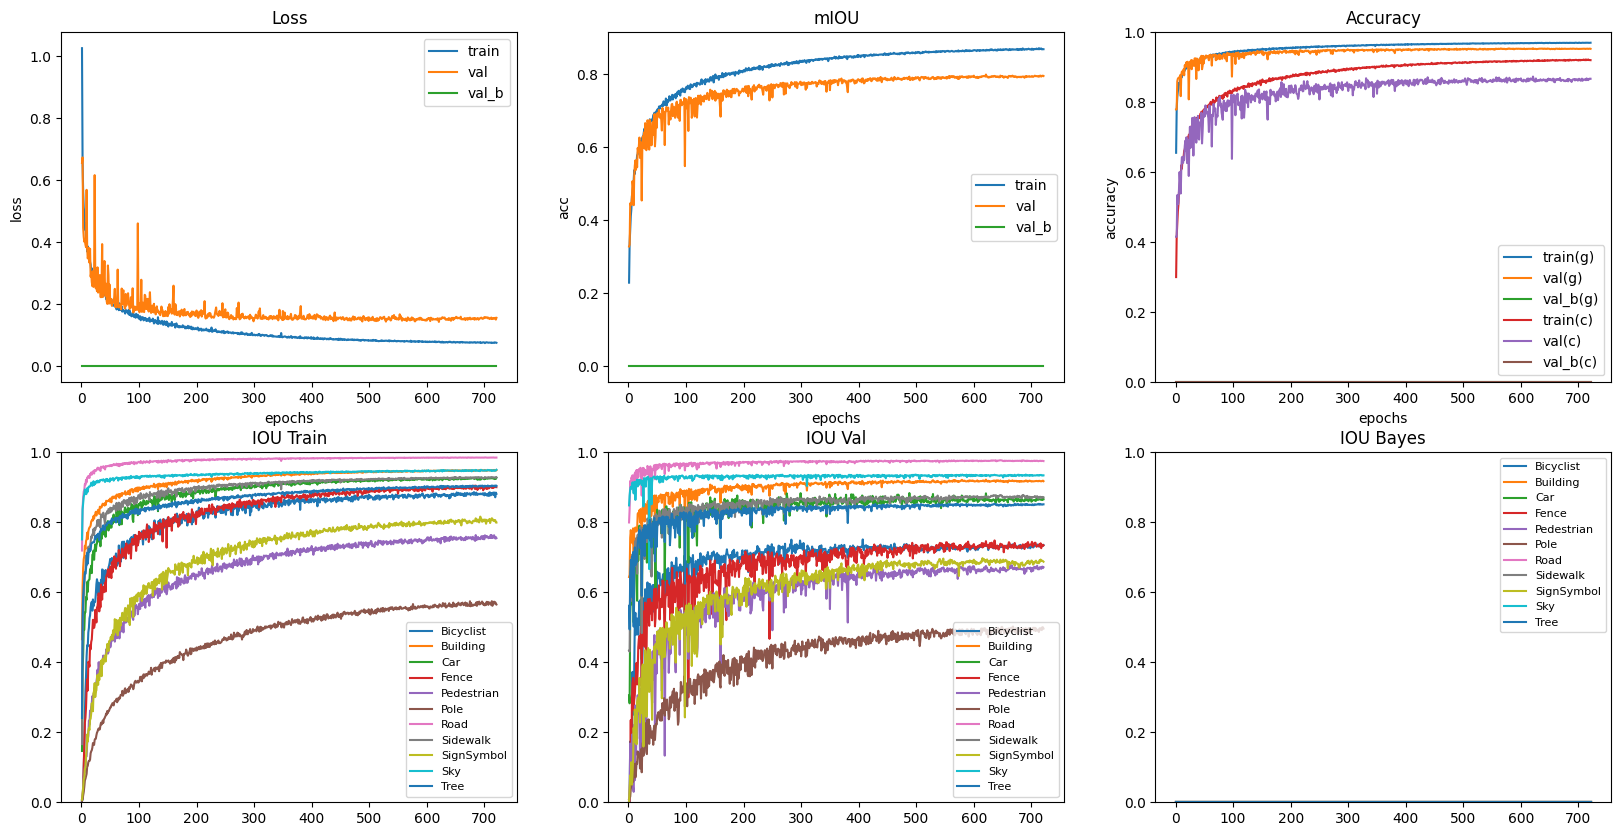

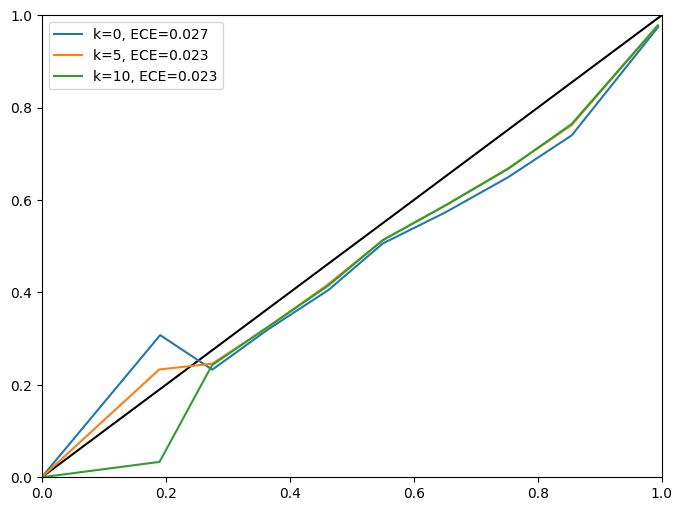

In [ ]:
# result_manager = ResultsManager(training_manager)
result_manager.save(
    save_properties=True,
    save_performance=True,
    save_calibration=True,
    save_pavpu=True,
    save_best=False,
)

# result_manager.plot_qualitative_results(save=True)
# result_manager.plot_uncertainty_decomposition(save=True)

----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline/model.pt
Loading history...
loaded network trained for 200 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline already exists and contains 17 items
evaluating...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline/ks_vs_metric.png
saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/Baseline/ks_vs_metric.json
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.3/model.pt
Loading history...
loaded network trained for 200 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.3 already exists and contains 17 items
evaluating...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.3/ks_vs_metric.png
saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.3/ks_vs_metric.json
Loading config...
----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
------------
Training for 200 iterations
Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5/model.pt
Loading history...
loaded network trained for 200 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5 already exists and contains 17 items
evaluating...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5/ks_vs_metric.png
saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/4-Drop-0.5/ks_vs_metric.json


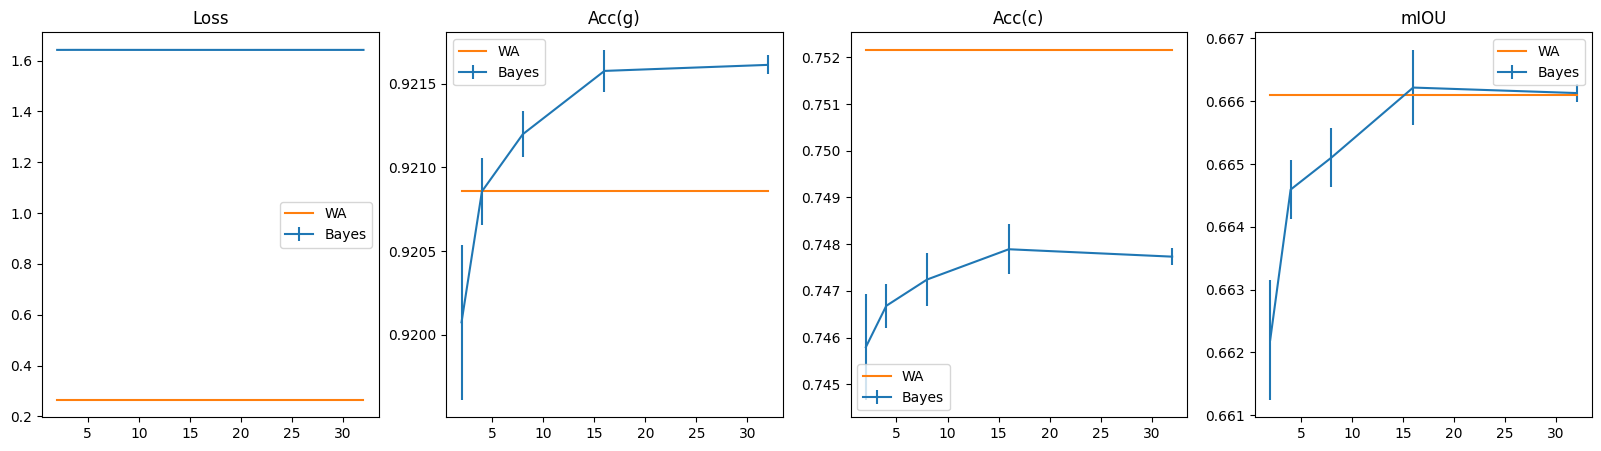

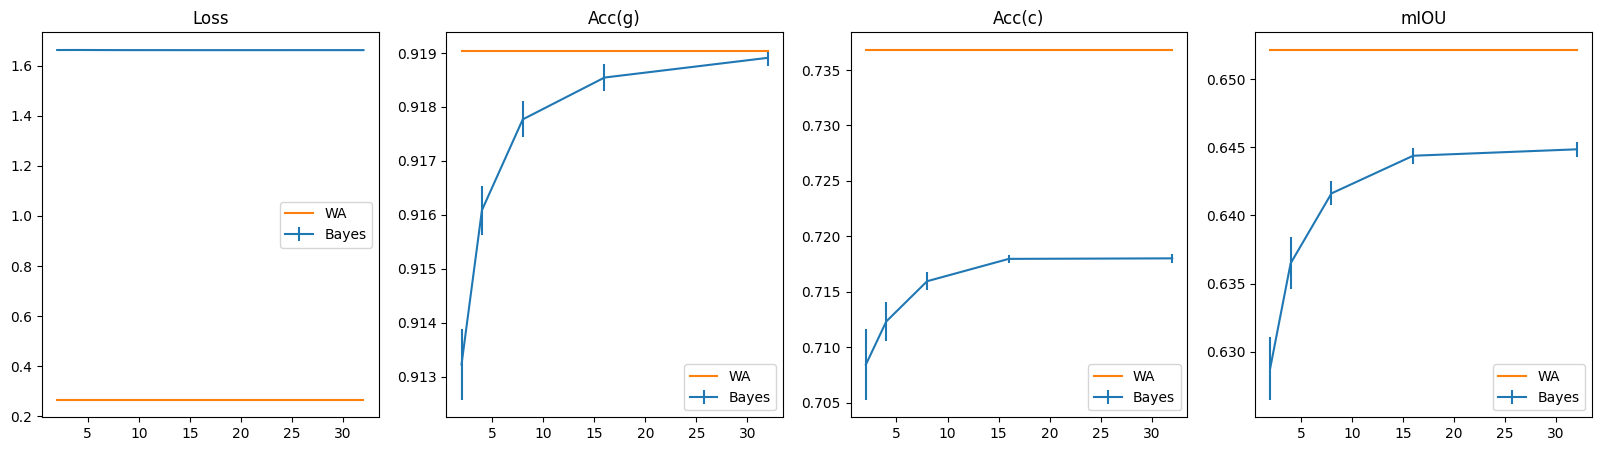

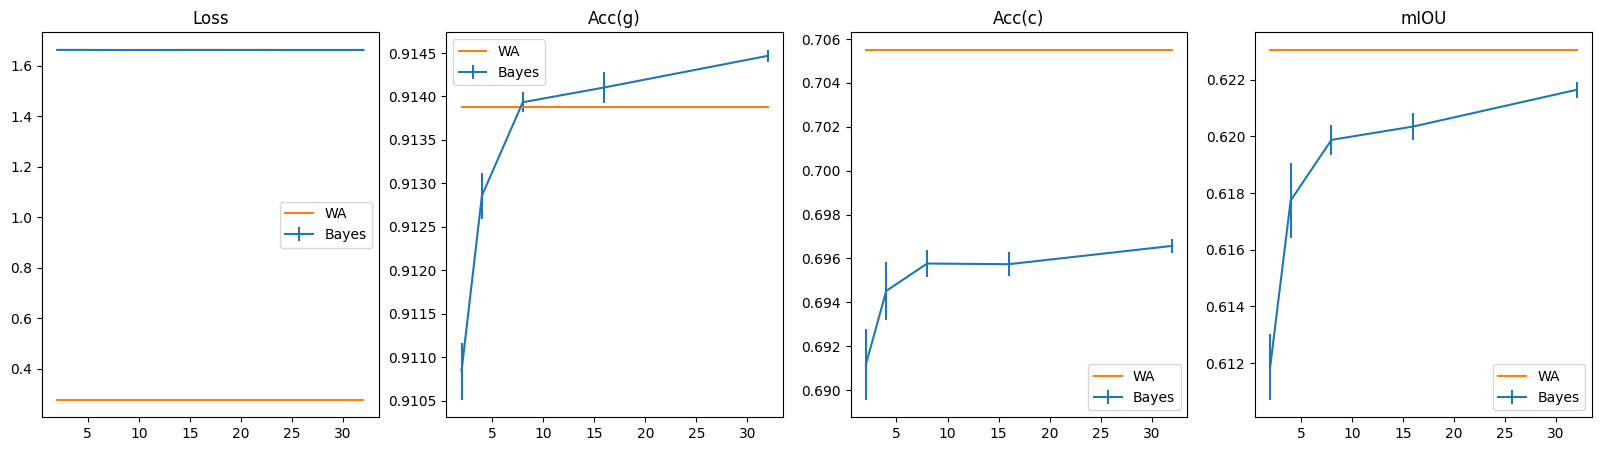

In [ ]:
# initiate empty training_manager
training_manager = TrainingManager(dataset_manager.datasets, config)

dirs = ['Baseline', '4-Drop-0.3', '4-Drop-0.5']

for dir in dirs:
  training_manager.load(f'Thesis/{dir}')
  result_manager = ResultsManager(training_manager)
  result_manager.plot_acc_vs_k(num_repeats=5, ks=[2, 4, 8, 16, 32], save=True)


### Experiment 2

In [ ]:
torch.cuda.empty_cache()

config = {
    'experiment': '3-1w-1.5d',
    'description': 'Additional experiments with scaling UP the network',
    'dataset': 'Thesis',
    'num_classes': NUM_CLASSES,
    'input_dim': (HEIGHT, WIDTH),
    'width_mult': 1,
    'depth_mult': 1.5,
    'model': 'mobilenet-v2',
    'loss': 'CE',
    'lr': 1e-3,
    'scheduler': 'poly',
    'batch_size': 10,
    'total_epochs': 200,
    'weight_decay': 1e-4,
    'stochastic_depth_prob': 0,
    'use_se': False,
    'dropout_p': 0.1,
    'dropout_mode': 'linear', # linear, constant
    'dropout_loc': None, # None(default), middle, last, all
    'shallowDeconv': False,
    'skip_mode': 'upsample', # upsample (default), none, all
    'skip_op': 'concat',
    'last_channel': 0, # set to None for default, 0 to disable
    'k': 10,
    'eval_subset': None,
    'patience': 100,
}

training_manager = TrainingManager(dataset_manager.datasets, config)
result_manager = ResultsManager(training_manager)

----UNET----
Buffer size: 0.418 MB
model size: 27.028MB
Total Trainable Params: 6.976M
------------
Training for 200 iterations
created directory /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/3-1w-1.5d
saving config...


In [ ]:
training_manager.train(epochs=200, eval_mode='regular')

In [ ]:
# result_manager = ResultsManager(training_manager)
result_manager.save(
    save_properties=True,
    save_performance=True,
    save_calibration=False,
    save_pavpu=False,
)

# result_manager.plot_qualitative_results(save=True)
# result_manager.plot_uncertainty_decomposition(save=True)

In [ ]:
from google.colab import runtime
runtime.unassign()

## Qualitative performance

In [ ]:
SAVE = True

In [ ]:
result_manager.plot_qualitative_results(save=False)

## Uncertainty Decomposition

In [ ]:
result_manager.plot_uncertainty_decomposition(save=False)

## Additional Plots

### Plot acc vs k

In [ ]:
# result_manager = ResultsManager(training_manager)
torch.cuda.empty_cache()
result_manager.plot_acc_vs_k(ks=[20, 10, 5, 1], num_repeats=1, save=True)

### Reliability plot

In [ ]:
# plot_calibration(training_manager.net, dataloaders['test'], ks=[0, 1, 5, 20], num_buckets=50)
# plt.savefig(result_manager)
# result_manager = ResultsManager(training_manager)

result_manager.plot_calibration(
    num_buckets=10,
    dataloader=dataloaders['test'],
    net=training_manager.net,
    ks=[0, 5, 10],
    save=False
)

In [ ]:
SAVE=True

In [ ]:
result_manager.config

### PAvPU

Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/1-decoder-dw already exists and contains 10 items
saving config...
computing uncertainty ranges...


  0%|          | 0/100 [00:00<?, ?it/s]

WA: min=1.1471894140413497e-05, max=2.2595698833465576
PE: min=2.2360991351888515e-05, max=2.252326488494873
MI: min=4.0322993299923837e-07, max=0.5439916849136353
computing pavpu on test set...


  0%|          | 0/232 [00:00<?, ?it/s]

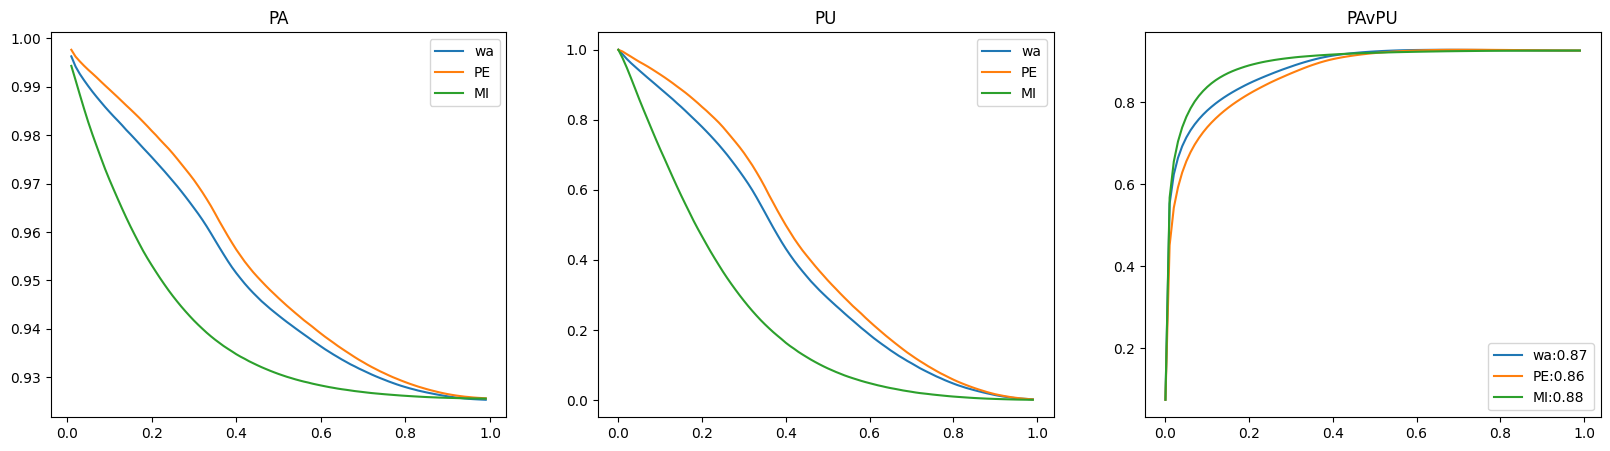

In [ ]:
torch.cuda.empty_cache()
result_manager = ResultsManager(training_manager)

output = result_manager.compute_and_plot_PAvPU(k=10, window=4, save=False)

In [ ]:
torch.cuda.empty_cache()

result_manager = ResultsManager(training_manager)

output = result_manager.compute_and_plot_PAvPU_prob(k=10, window=1, save=False)

In [ ]:
# def PAvPU(gt: Tensor,
#           pred: Tensor,
#           uncertainty: Tensor,
#           min_uncertainty: float,
#           max_uncertainty: float,
#           acc_threshold: Optional[float]=0.5,
#           window: Optional[int]=4,
#           num_buckets=100)->float:

output = PAvPU(y, y_pred, mutual_info, 0, 0.5, 0.5, window=4, num_buckets=50)

In [ ]:
print(mutual_info.mean())
print(mutual_info.std())

print(entropy.mean())
print(entropy.std())



In [ ]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plt.plot(output[0])

plt.subplot(1, 3, 2)
plt.plot(output[1])

plt.subplot(1, 3, 3)
plt.plot(output[2])

In [ ]:
# WA: min=5.964948712744444e-08, max=2.3146274089813232
# PE: min=2.8625896675293916e-07, max=2.311171531677246
# MI: min=-6.530444807140157e-08, max=0.6384855508804321

# WA: min=5.964948712744444e-08, max=2.3146274089813232
# PE: min=3.0355587909980386e-07, max=2.3152565956115723
# MI: min=-9.023187885759398e-08, max=0.6919202208518982


output.keys()


In [ ]:
output['pa/PE']